## Convolutional Neural Network

In [15]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
%matplotlib inline

In [16]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [17]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. Vectorize the datapoints for visualization and preliminary questions.

In [18]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

In [19]:
print(x_train.shape)

(60000, 784)


### Convolutional Neural Network 
compares with a Convolutional Neural Network (CNN). CNNs leverage dependencies between neighbouring pixels, making them more efficient and light weight compared to their fully connected counter part. In this section we will implement a Class CNN similar to the one we defined before for MLP.

Implement a CNN of the shape [32, 64, 128]; where 32, 64, 128 represent the number of convolutional filters for each hidden layer. We will use a kernel size of size $4\times4$. 

Use a stride of 1 in the first convolutional layer, followed by a stride of 2 for the following layers (a stride of two help downsampling without requiring the use of pooling layers). Vectorize the obtained output using tf.layer.flatten, and end the model with a fully connected layer of 10 neurons. Use ReLU as the non linear activation for the hidden layers.

### Denoising Auto-Encoder 

While CNNs make very good classifiers, they can also be used for many various tasks such as regression, image generation, image reconstruction and so on. In this part of the coursework you should implement a fully convolutional de-noising auto-encoder, i.e. a network that takes a noisy image as input and outputs the corresponding cleaned output. In this exercise we will introduce a gaussian noise on each input. Our goal is to recover the original noiseless images in the output.

Similarly as before we will define the class DAE, and you will need to complete the method 'create_model' and 'compute_loss' accordingly. 

Using the functions tf.layers.conv2d and tf.layers.conv2d_transpose complete the method 'create_model' in the class DAE below. 

conv2d should be used for the encoding part while conv2d_transpose should be used for the decoding part. 
We will use ReLu as the non linear activation for the hidden layers and tanh as the activation for the output layer. 
The network architecture is as follows:

+ Encoding part: a series of conv2d layers with [32, 64, 128] filters of size 4\times4, a stride of 1 in the first layer and a stride of 2 for the second and third layers.  
+ Decodind part: a series of two conv2d_transpose followed by one, one strided conv2d with [64,32,1] filters of size 4\times4. 

The output dimension of the final layer should match the input dimension [batch_size, 28, 28]. If necesseray use the argument padding or the function tf.pad to make the input and ouput dimensions match. 

In [6]:
class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50, stddev=1):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28,1])
        self.im_n = tf.clip_by_value(self.im + tf.random_normal(tf.shape(self.im), mean=0, stddev=stddev),-1,1) #inject noise
        self.x_train = x_train
        
    def create_model(self):
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            self.hl_1 = tf.layers.conv2d(self.im, 32, kernel_size=(4, 4), strides=1, activation=tf.nn.relu, name='self.hl_1')
            hl_2 = tf.layers.conv2d(self.hl_1, 64, kernel_size=(4, 4), strides=2, activation=tf.nn.relu, name='hl_2')
            hl_3 = tf.layers.conv2d(hl_2, 128, kernel_size=(4, 4), strides=2, activation=tf.nn.relu, name='hl_3')
            
            hl_4 = tf.layers.conv2d_transpose(hl_3, 64, kernel_size=(4, 4), strides=2, activation=tf.nn.relu, name='hl_4')
            hl_5 = tf.layers.conv2d_transpose(hl_4, 32, kernel_size=(4, 4), strides=2, activation=tf.nn.relu, name='hl_5')
            hl_6 = tf.layers.conv2d(hl_5, 1, kernel_size=(4, 4), strides=1, activation=tf.nn.tanh, name='hl_6')
#             print(hl_1.shape)
            pad  = [[0,0],[5, 4], [5, 4],[0,0]]
            hl_7 = tf.pad(hl_6, pad, constant_values=-1)
            self.recon_im =  hl_7
            print(self.im_n,self.recon_im)
            tf.summary.image('denoising', tf.concat([self.im_n, self.recon_im], axis=2))
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.losses.mean_squared_error(labels= self.recon_im,predictions=self.im)
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
            print(self.loss_summ)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [7]:
from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
X_train, X_test = train_test_split(x_train, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(x_train, test_size=0.25, random_state=1)

In [8]:
stddev = 1
tf.reset_default_graph()
model = DAE(X_train.reshape(-1, 28, 28), './DAE_logdir/', 0.001, 2, 10,stddev)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Tensor("clip_by_value:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("DAE/PadV2:0", shape=(?, 28, 28, 1), dtype=float32)
ssssssssssssssssssssssssssssssssssssssssssssssssum Tensor("loss/reconstruction_loss:0", shape=(), dtype=string)


Similar to the previous questions, train the DAE by looping over all the mini-batches. For proper training you should input enough noisy versions per image. 
- Plot the training/validation curves and discuss why your trained model is not under/over fitting.
When the training is finished, inject noise into the test data and reconstruct them through a forward pass. For each test image, input 20 noisy versions of it and compute the average accuracies. 

In [11]:
train_loss = []
for epoch in range(model.nb_epochs):
    randomize = np.arange(X_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]

    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size,:,:,np.newaxis]
#         input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , loss, loss_summ = sess.run([model.trainer, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train})
        print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
        train_loss.append(loss)

        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
sess.close()

Epoch 0, Iteration 0, loss 0.017
Epoch 0, Iteration 1, loss 0.018
Epoch 0, Iteration 2, loss 0.034
Epoch 0, Iteration 3, loss 0.024
Epoch 0, Iteration 4, loss 0.020
Epoch 0, Iteration 5, loss 0.022
Epoch 0, Iteration 6, loss 0.026
Epoch 0, Iteration 7, loss 0.017
Epoch 0, Iteration 8, loss 0.024
Epoch 0, Iteration 9, loss 0.017
Epoch 0, Iteration 10, loss 0.019
Epoch 0, Iteration 11, loss 0.025
Epoch 0, Iteration 12, loss 0.024
Epoch 0, Iteration 13, loss 0.019
Epoch 0, Iteration 14, loss 0.016
Epoch 0, Iteration 15, loss 0.018
Epoch 0, Iteration 16, loss 0.024
Epoch 0, Iteration 17, loss 0.024
Epoch 0, Iteration 18, loss 0.022
Epoch 0, Iteration 19, loss 0.020
Epoch 0, Iteration 20, loss 0.016
Epoch 0, Iteration 21, loss 0.025
Epoch 0, Iteration 22, loss 0.019
Epoch 0, Iteration 23, loss 0.018
Epoch 0, Iteration 24, loss 0.017
Epoch 0, Iteration 25, loss 0.014
Epoch 0, Iteration 26, loss 0.026
Epoch 0, Iteration 27, loss 0.033
Epoch 0, Iteration 28, loss 0.020
Epoch 0, Iteration 29, l

KeyboardInterrupt: 

In [11]:
# re-trained model again for calculate the validation loss
stddev = 1
tf.reset_default_graph()
model = DAE(X_train.reshape(-1, 28, 28), './DAE_logdir/', 0.001, 2, 10,stddev)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Tensor("clip_by_value:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("DAE/PadV2:0", shape=(?, 28, 28, 1), dtype=float32)
ssssssssssssssssssssssssssssssssssssssssssssssssum Tensor("loss/reconstruction_loss:0", shape=(), dtype=string)


In [12]:
val_loss = []
for epoch in range(model.nb_epochs):
    randomize = np.arange(X_val.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]

    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size,:,:,np.newaxis]
#         input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , loss, loss_summ = sess.run([model.trainer, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train})
        print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
        val_loss.append(loss)

        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
sess.close()

Epoch 0, Iteration 0, loss 0.412
Epoch 0, Iteration 1, loss 0.394
Epoch 0, Iteration 2, loss 0.352
Epoch 0, Iteration 3, loss 0.373
Epoch 0, Iteration 4, loss 0.309
Epoch 0, Iteration 5, loss 0.286
Epoch 0, Iteration 6, loss 0.283
Epoch 0, Iteration 7, loss 0.234
Epoch 0, Iteration 8, loss 0.252
Epoch 0, Iteration 9, loss 0.234
Epoch 0, Iteration 10, loss 0.168
Epoch 0, Iteration 11, loss 0.198
Epoch 0, Iteration 12, loss 0.176
Epoch 0, Iteration 13, loss 0.196
Epoch 0, Iteration 14, loss 0.137
Epoch 0, Iteration 15, loss 0.138
Epoch 0, Iteration 16, loss 0.119
Epoch 0, Iteration 17, loss 0.104
Epoch 0, Iteration 18, loss 0.104
Epoch 0, Iteration 19, loss 0.107
Epoch 0, Iteration 20, loss 0.114
Epoch 0, Iteration 21, loss 0.116
Epoch 0, Iteration 22, loss 0.099
Epoch 0, Iteration 23, loss 0.080
Epoch 0, Iteration 24, loss 0.072
Epoch 0, Iteration 25, loss 0.075
Epoch 0, Iteration 26, loss 0.066
Epoch 0, Iteration 27, loss 0.079
Epoch 0, Iteration 28, loss 0.077
Epoch 0, Iteration 29, l

Epoch 0, Iteration 239, loss 0.036
Epoch 0, Iteration 240, loss 0.040
Epoch 0, Iteration 241, loss 0.025
Epoch 0, Iteration 242, loss 0.028
Epoch 0, Iteration 243, loss 0.026
Epoch 0, Iteration 244, loss 0.020
Epoch 0, Iteration 245, loss 0.030
Epoch 0, Iteration 246, loss 0.029
Epoch 0, Iteration 247, loss 0.032
Epoch 0, Iteration 248, loss 0.031
Epoch 0, Iteration 249, loss 0.036
Epoch 0, Iteration 250, loss 0.053
Epoch 0, Iteration 251, loss 0.035
Epoch 0, Iteration 252, loss 0.033
Epoch 0, Iteration 253, loss 0.025
Epoch 0, Iteration 254, loss 0.025
Epoch 0, Iteration 255, loss 0.025
Epoch 0, Iteration 256, loss 0.026
Epoch 0, Iteration 257, loss 0.028
Epoch 0, Iteration 258, loss 0.037
Epoch 0, Iteration 259, loss 0.040
Epoch 0, Iteration 260, loss 0.036
Epoch 0, Iteration 261, loss 0.032
Epoch 0, Iteration 262, loss 0.032
Epoch 0, Iteration 263, loss 0.033
Epoch 0, Iteration 264, loss 0.031
Epoch 0, Iteration 265, loss 0.033
Epoch 0, Iteration 266, loss 0.035
Epoch 0, Iteration 2

Epoch 0, Iteration 475, loss 0.032
Epoch 0, Iteration 476, loss 0.032
Epoch 0, Iteration 477, loss 0.027
Epoch 0, Iteration 478, loss 0.022
Epoch 0, Iteration 479, loss 0.029
Epoch 0, Iteration 480, loss 0.030
Epoch 0, Iteration 481, loss 0.027
Epoch 0, Iteration 482, loss 0.019
Epoch 0, Iteration 483, loss 0.030
Epoch 0, Iteration 484, loss 0.024
Epoch 0, Iteration 485, loss 0.026
Epoch 0, Iteration 486, loss 0.030
Epoch 0, Iteration 487, loss 0.026
Epoch 0, Iteration 488, loss 0.025
Epoch 0, Iteration 489, loss 0.042
Epoch 0, Iteration 490, loss 0.026
Epoch 0, Iteration 491, loss 0.030
Epoch 0, Iteration 492, loss 0.028
Epoch 0, Iteration 493, loss 0.032
Epoch 0, Iteration 494, loss 0.035
Epoch 0, Iteration 495, loss 0.023
Epoch 0, Iteration 496, loss 0.025
Epoch 0, Iteration 497, loss 0.030
Epoch 0, Iteration 498, loss 0.027
Epoch 0, Iteration 499, loss 0.027
Epoch 0, Iteration 500, loss 0.025
Epoch 0, Iteration 501, loss 0.027
Epoch 0, Iteration 502, loss 0.029
Epoch 0, Iteration 5

Epoch 0, Iteration 712, loss 0.023
Epoch 0, Iteration 713, loss 0.026
Epoch 0, Iteration 714, loss 0.033
Epoch 0, Iteration 715, loss 0.027
Epoch 0, Iteration 716, loss 0.023
Epoch 0, Iteration 717, loss 0.026
Epoch 0, Iteration 718, loss 0.026
Epoch 0, Iteration 719, loss 0.027
Epoch 0, Iteration 720, loss 0.023
Epoch 0, Iteration 721, loss 0.029
Epoch 0, Iteration 722, loss 0.029
Epoch 0, Iteration 723, loss 0.025
Epoch 0, Iteration 724, loss 0.016
Epoch 0, Iteration 725, loss 0.037
Epoch 0, Iteration 726, loss 0.019
Epoch 0, Iteration 727, loss 0.026
Epoch 0, Iteration 728, loss 0.028
Epoch 0, Iteration 729, loss 0.025
Epoch 0, Iteration 730, loss 0.023
Epoch 0, Iteration 731, loss 0.020
Epoch 0, Iteration 732, loss 0.024
Epoch 0, Iteration 733, loss 0.020
Epoch 0, Iteration 734, loss 0.029
Epoch 0, Iteration 735, loss 0.023
Epoch 0, Iteration 736, loss 0.030
Epoch 0, Iteration 737, loss 0.026
Epoch 0, Iteration 738, loss 0.022
Epoch 0, Iteration 739, loss 0.025
Epoch 0, Iteration 7

Epoch 0, Iteration 947, loss 0.019
Epoch 0, Iteration 948, loss 0.022
Epoch 0, Iteration 949, loss 0.020
Epoch 0, Iteration 950, loss 0.023
Epoch 0, Iteration 951, loss 0.024
Epoch 0, Iteration 952, loss 0.027
Epoch 0, Iteration 953, loss 0.027
Epoch 0, Iteration 954, loss 0.024
Epoch 0, Iteration 955, loss 0.023
Epoch 0, Iteration 956, loss 0.024
Epoch 0, Iteration 957, loss 0.020
Epoch 0, Iteration 958, loss 0.025
Epoch 0, Iteration 959, loss 0.016
Epoch 0, Iteration 960, loss 0.029
Epoch 0, Iteration 961, loss 0.025
Epoch 0, Iteration 962, loss 0.019
Epoch 0, Iteration 963, loss 0.024
Epoch 0, Iteration 964, loss 0.031
Epoch 0, Iteration 965, loss 0.024
Epoch 0, Iteration 966, loss 0.030
Epoch 0, Iteration 967, loss 0.020
Epoch 0, Iteration 968, loss 0.031
Epoch 0, Iteration 969, loss 0.024
Epoch 0, Iteration 970, loss 0.021
Epoch 0, Iteration 971, loss 0.021
Epoch 0, Iteration 972, loss 0.027
Epoch 0, Iteration 973, loss 0.028
Epoch 0, Iteration 974, loss 0.033
Epoch 0, Iteration 9

Epoch 0, Iteration 1177, loss 0.025
Epoch 0, Iteration 1178, loss 0.033
Epoch 0, Iteration 1179, loss 0.018
Epoch 0, Iteration 1180, loss 0.019
Epoch 0, Iteration 1181, loss 0.025
Epoch 0, Iteration 1182, loss 0.026
Epoch 0, Iteration 1183, loss 0.033
Epoch 0, Iteration 1184, loss 0.029
Epoch 0, Iteration 1185, loss 0.028
Epoch 0, Iteration 1186, loss 0.015
Epoch 0, Iteration 1187, loss 0.032
Epoch 0, Iteration 1188, loss 0.023
Epoch 0, Iteration 1189, loss 0.019
Epoch 0, Iteration 1190, loss 0.036
Epoch 0, Iteration 1191, loss 0.022
Epoch 0, Iteration 1192, loss 0.023
Epoch 0, Iteration 1193, loss 0.027
Epoch 0, Iteration 1194, loss 0.031
Epoch 0, Iteration 1195, loss 0.032
Epoch 0, Iteration 1196, loss 0.025
Epoch 0, Iteration 1197, loss 0.024
Epoch 0, Iteration 1198, loss 0.029
Epoch 0, Iteration 1199, loss 0.020
Epoch 0, Iteration 1200, loss 0.018
Epoch 0, Iteration 1201, loss 0.023
Epoch 0, Iteration 1202, loss 0.024
Epoch 0, Iteration 1203, loss 0.032
Epoch 0, Iteration 1204, los

Epoch 0, Iteration 1405, loss 0.033
Epoch 0, Iteration 1406, loss 0.029
Epoch 0, Iteration 1407, loss 0.030
Epoch 0, Iteration 1408, loss 0.021
Epoch 0, Iteration 1409, loss 0.030
Epoch 0, Iteration 1410, loss 0.026
Epoch 0, Iteration 1411, loss 0.026
Epoch 0, Iteration 1412, loss 0.021
Epoch 0, Iteration 1413, loss 0.022
Epoch 0, Iteration 1414, loss 0.019
Epoch 0, Iteration 1415, loss 0.027
Epoch 0, Iteration 1416, loss 0.033
Epoch 0, Iteration 1417, loss 0.019
Epoch 0, Iteration 1418, loss 0.029
Epoch 0, Iteration 1419, loss 0.028
Epoch 0, Iteration 1420, loss 0.027
Epoch 0, Iteration 1421, loss 0.027
Epoch 0, Iteration 1422, loss 0.022
Epoch 0, Iteration 1423, loss 0.019
Epoch 0, Iteration 1424, loss 0.022
Epoch 0, Iteration 1425, loss 0.030
Epoch 0, Iteration 1426, loss 0.030
Epoch 0, Iteration 1427, loss 0.019
Epoch 0, Iteration 1428, loss 0.022
Epoch 0, Iteration 1429, loss 0.022
Epoch 0, Iteration 1430, loss 0.028
Epoch 0, Iteration 1431, loss 0.030
Epoch 0, Iteration 1432, los

InvalidArgumentError: input and filter must have the same depth: 1 vs 32
	 [[node DAE/hl_2/BiasAdd (defined at <ipython-input-7-ef9c830d32ce>:18) ]]

Caused by op 'DAE/hl_2/BiasAdd', defined at:
  File "C:\Users\vaio\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\vaio\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\vaio\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\vaio\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\vaio\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\vaio\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\vaio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-7dd97aeaaba5>", line 5, in <module>
    model.create_model()
  File "<ipython-input-7-ef9c830d32ce>", line 18, in create_model
    hl_2 = tf.layers.conv2d(self.hl_1, 64, kernel_size=(4, 4), strides=2, activation=tf.nn.relu, name='hl_2')
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\layers\convolutional.py", line 424, in conv2d
    return layer.apply(inputs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 554, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 218, in call
    outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1980, in bias_add
    return gen_nn_ops.bias_add(value, bias, data_format=data_format, name=name)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 744, in bias_add
    "BiasAdd", value=value, bias=bias, data_format=data_format, name=name)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\vaio\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): input and filter must have the same depth: 1 vs 32
	 [[node DAE/hl_2/BiasAdd (defined at <ipython-input-7-ef9c830d32ce>:18) ]]


In [13]:
# sum_loss
np.mean(train_loss)

0.024372833

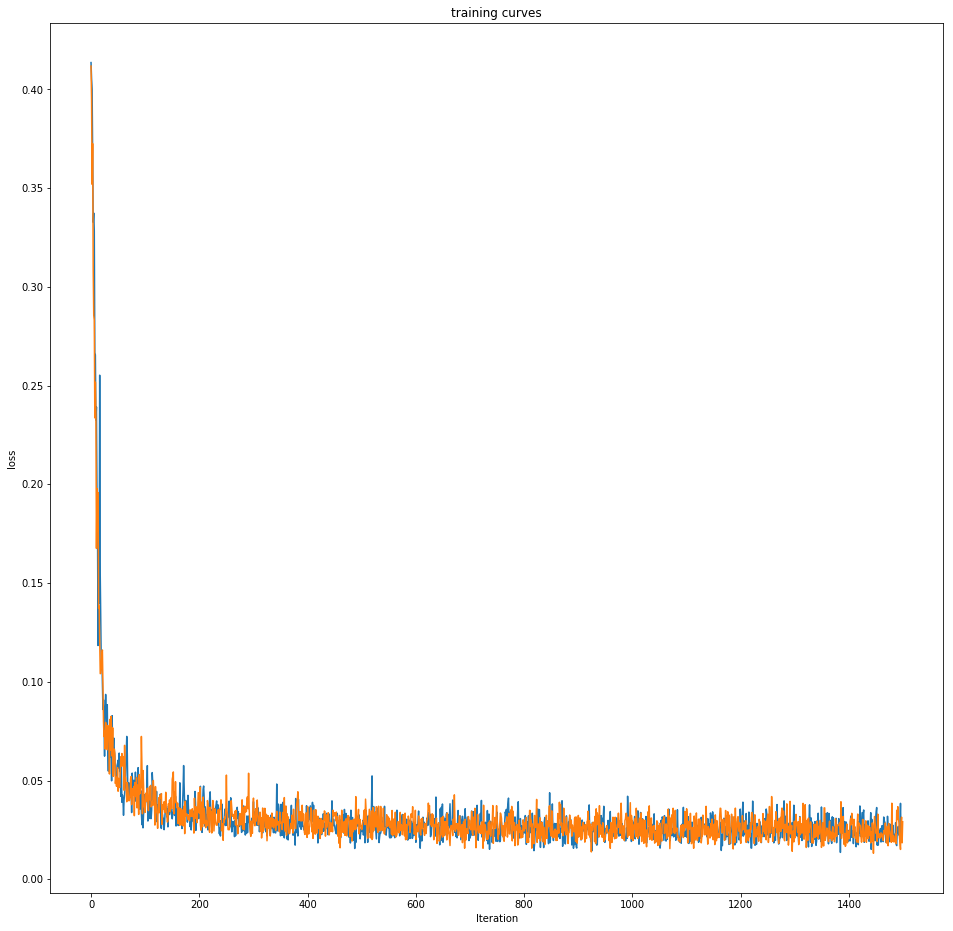

In [19]:
# plot the train loss and validation loss curves
plt.figure(figsize=(16,16))

plt.plot(train_loss[:1499])
plt.plot(val_loss)
plt.title("training curves")
plt.xlabel("Iteration")
plt.ylabel("loss");

In [20]:
# input 20 noisy form 1 to 20, and compute the average accuracies
noise_accuracy = []
for stddev in range(20):
    tf.reset_default_graph()
    model = DAE(X_test.reshape(-1, 28, 28), './DAE_logdir/', 0.001, 2, 10, stddev)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)

    sum_loss = []
    for epoch in range(model.nb_epochs):
        randomize = np.arange(X_test.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]

        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size,:,:,np.newaxis]
    #         input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , loss, loss_summ = sess.run([model.trainer, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train})
            print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
            sum_loss.append(loss)

            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  
    sess.close()

    single = np.mean(sum_loss)
    accuracy = 1 - single
    noise_accuracy.append(accuracy)

Tensor("clip_by_value:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("DAE/PadV2:0", shape=(?, 28, 28, 1), dtype=float32)
ssssssssssssssssssssssssssssssssssssssssssssssssum Tensor("loss/reconstruction_loss:0", shape=(), dtype=string)
Epoch 0, Iteration 0, loss 0.416
Epoch 0, Iteration 1, loss 0.414
Epoch 0, Iteration 2, loss 0.400
Epoch 0, Iteration 3, loss 0.335
Epoch 0, Iteration 4, loss 0.376
Epoch 0, Iteration 5, loss 0.291
Epoch 0, Iteration 6, loss 0.319
Epoch 0, Iteration 7, loss 0.260
Epoch 0, Iteration 8, loss 0.248
Epoch 0, Iteration 9, loss 0.216
Epoch 0, Iteration 10, loss 0.262
Epoch 0, Iteration 11, loss 0.182
Epoch 0, Iteration 12, loss 0.161
Epoch 0, Iteration 13, loss 0.173
Epoch 0, Iteration 14, loss 0.152
Epoch 0, Iteration 15, loss 0.144
Epoch 0, Iteration 16, loss 0.110
Epoch 0, Iteration 17, loss 0.108
Epoch 0, Iteration 18, loss 0.111
Epoch 0, Iteration 19, loss 0.198
Epoch 0, Iteration 20, loss 0.136
Epoch 0, Iteration 21, loss 0.100
Epoch 0, Iteration 22, loss 

Epoch 0, Iteration 233, loss 0.039
Epoch 0, Iteration 234, loss 0.037
Epoch 0, Iteration 235, loss 0.032
Epoch 0, Iteration 236, loss 0.039
Epoch 0, Iteration 237, loss 0.035
Epoch 0, Iteration 238, loss 0.036
Epoch 0, Iteration 239, loss 0.029
Epoch 0, Iteration 240, loss 0.036
Epoch 0, Iteration 241, loss 0.032
Epoch 0, Iteration 242, loss 0.032
Epoch 0, Iteration 243, loss 0.033
Epoch 0, Iteration 244, loss 0.035
Epoch 0, Iteration 245, loss 0.025
Epoch 0, Iteration 246, loss 0.031
Epoch 0, Iteration 247, loss 0.022
Epoch 0, Iteration 248, loss 0.027
Epoch 0, Iteration 249, loss 0.024
Epoch 0, Iteration 250, loss 0.030
Epoch 0, Iteration 251, loss 0.038
Epoch 0, Iteration 252, loss 0.026
Epoch 0, Iteration 253, loss 0.026
Epoch 0, Iteration 254, loss 0.028
Epoch 0, Iteration 255, loss 0.028
Epoch 0, Iteration 256, loss 0.025
Epoch 0, Iteration 257, loss 0.027
Epoch 0, Iteration 258, loss 0.034
Epoch 0, Iteration 259, loss 0.020
Epoch 0, Iteration 260, loss 0.031
Epoch 0, Iteration 2

Epoch 0, Iteration 468, loss 0.024
Epoch 0, Iteration 469, loss 0.019
Epoch 0, Iteration 470, loss 0.025
Epoch 0, Iteration 471, loss 0.032
Epoch 0, Iteration 472, loss 0.019
Epoch 0, Iteration 473, loss 0.029
Epoch 0, Iteration 474, loss 0.026
Epoch 0, Iteration 475, loss 0.027
Epoch 0, Iteration 476, loss 0.027
Epoch 0, Iteration 477, loss 0.034
Epoch 0, Iteration 478, loss 0.021
Epoch 0, Iteration 479, loss 0.032
Epoch 0, Iteration 480, loss 0.025
Epoch 0, Iteration 481, loss 0.031
Epoch 0, Iteration 482, loss 0.028
Epoch 0, Iteration 483, loss 0.033
Epoch 0, Iteration 484, loss 0.027
Epoch 0, Iteration 485, loss 0.024
Epoch 0, Iteration 486, loss 0.036
Epoch 0, Iteration 487, loss 0.035
Epoch 0, Iteration 488, loss 0.037
Epoch 0, Iteration 489, loss 0.043
Epoch 0, Iteration 490, loss 0.030
Epoch 0, Iteration 491, loss 0.027
Epoch 0, Iteration 492, loss 0.024
Epoch 0, Iteration 493, loss 0.022
Epoch 0, Iteration 494, loss 0.027
Epoch 0, Iteration 495, loss 0.020
Epoch 0, Iteration 4

Epoch 0, Iteration 705, loss 0.019
Epoch 0, Iteration 706, loss 0.031
Epoch 0, Iteration 707, loss 0.022
Epoch 0, Iteration 708, loss 0.028
Epoch 0, Iteration 709, loss 0.026
Epoch 0, Iteration 710, loss 0.014
Epoch 0, Iteration 711, loss 0.030
Epoch 0, Iteration 712, loss 0.027
Epoch 0, Iteration 713, loss 0.021
Epoch 0, Iteration 714, loss 0.029
Epoch 0, Iteration 715, loss 0.027
Epoch 0, Iteration 716, loss 0.027
Epoch 0, Iteration 717, loss 0.022
Epoch 0, Iteration 718, loss 0.020
Epoch 0, Iteration 719, loss 0.032
Epoch 0, Iteration 720, loss 0.022
Epoch 0, Iteration 721, loss 0.028
Epoch 0, Iteration 722, loss 0.018
Epoch 0, Iteration 723, loss 0.025
Epoch 0, Iteration 724, loss 0.029
Epoch 0, Iteration 725, loss 0.023
Epoch 0, Iteration 726, loss 0.024
Epoch 0, Iteration 727, loss 0.020
Epoch 0, Iteration 728, loss 0.020
Epoch 0, Iteration 729, loss 0.018
Epoch 0, Iteration 730, loss 0.020
Epoch 0, Iteration 731, loss 0.028
Epoch 0, Iteration 732, loss 0.025
Epoch 0, Iteration 7

Epoch 0, Iteration 941, loss 0.027
Epoch 0, Iteration 942, loss 0.026
Epoch 0, Iteration 943, loss 0.032
Epoch 0, Iteration 944, loss 0.026
Epoch 0, Iteration 945, loss 0.027
Epoch 0, Iteration 946, loss 0.025
Epoch 0, Iteration 947, loss 0.026
Epoch 0, Iteration 948, loss 0.039
Epoch 0, Iteration 949, loss 0.023
Epoch 0, Iteration 950, loss 0.030
Epoch 0, Iteration 951, loss 0.028
Epoch 0, Iteration 952, loss 0.026
Epoch 0, Iteration 953, loss 0.029
Epoch 0, Iteration 954, loss 0.028
Epoch 0, Iteration 955, loss 0.020
Epoch 0, Iteration 956, loss 0.025
Epoch 0, Iteration 957, loss 0.029
Epoch 0, Iteration 958, loss 0.023
Epoch 0, Iteration 959, loss 0.028
Epoch 0, Iteration 960, loss 0.023
Epoch 0, Iteration 961, loss 0.025
Epoch 0, Iteration 962, loss 0.024
Epoch 0, Iteration 963, loss 0.016
Epoch 0, Iteration 964, loss 0.018
Epoch 0, Iteration 965, loss 0.027
Epoch 0, Iteration 966, loss 0.025
Epoch 0, Iteration 967, loss 0.026
Epoch 0, Iteration 968, loss 0.024
Epoch 0, Iteration 9

Epoch 0, Iteration 1172, loss 0.026
Epoch 0, Iteration 1173, loss 0.022
Epoch 0, Iteration 1174, loss 0.017
Epoch 0, Iteration 1175, loss 0.026
Epoch 0, Iteration 1176, loss 0.025
Epoch 0, Iteration 1177, loss 0.022
Epoch 0, Iteration 1178, loss 0.029
Epoch 0, Iteration 1179, loss 0.022
Epoch 0, Iteration 1180, loss 0.024
Epoch 0, Iteration 1181, loss 0.022
Epoch 0, Iteration 1182, loss 0.029
Epoch 0, Iteration 1183, loss 0.035
Epoch 0, Iteration 1184, loss 0.027
Epoch 0, Iteration 1185, loss 0.025
Epoch 0, Iteration 1186, loss 0.023
Epoch 0, Iteration 1187, loss 0.022
Epoch 0, Iteration 1188, loss 0.017
Epoch 0, Iteration 1189, loss 0.024
Epoch 0, Iteration 1190, loss 0.030
Epoch 0, Iteration 1191, loss 0.019
Epoch 0, Iteration 1192, loss 0.020
Epoch 0, Iteration 1193, loss 0.018
Epoch 0, Iteration 1194, loss 0.023
Epoch 0, Iteration 1195, loss 0.032
Epoch 0, Iteration 1196, loss 0.038
Epoch 0, Iteration 1197, loss 0.025
Epoch 0, Iteration 1198, loss 0.027
Epoch 0, Iteration 1199, los

Epoch 1, Iteration 211, loss 0.025
Epoch 1, Iteration 212, loss 0.028
Epoch 1, Iteration 213, loss 0.021
Epoch 1, Iteration 214, loss 0.021
Epoch 1, Iteration 215, loss 0.023
Epoch 1, Iteration 216, loss 0.029
Epoch 1, Iteration 217, loss 0.024
Epoch 1, Iteration 218, loss 0.028
Epoch 1, Iteration 219, loss 0.031
Epoch 1, Iteration 220, loss 0.031
Epoch 1, Iteration 221, loss 0.030
Epoch 1, Iteration 222, loss 0.027
Epoch 1, Iteration 223, loss 0.031
Epoch 1, Iteration 224, loss 0.030
Epoch 1, Iteration 225, loss 0.022
Epoch 1, Iteration 226, loss 0.034
Epoch 1, Iteration 227, loss 0.031
Epoch 1, Iteration 228, loss 0.021
Epoch 1, Iteration 229, loss 0.030
Epoch 1, Iteration 230, loss 0.026
Epoch 1, Iteration 231, loss 0.031
Epoch 1, Iteration 232, loss 0.025
Epoch 1, Iteration 233, loss 0.017
Epoch 1, Iteration 234, loss 0.023
Epoch 1, Iteration 235, loss 0.027
Epoch 1, Iteration 236, loss 0.033
Epoch 1, Iteration 237, loss 0.022
Epoch 1, Iteration 238, loss 0.029
Epoch 1, Iteration 2

Epoch 1, Iteration 447, loss 0.029
Epoch 1, Iteration 448, loss 0.026
Epoch 1, Iteration 449, loss 0.025
Epoch 1, Iteration 450, loss 0.017
Epoch 1, Iteration 451, loss 0.022
Epoch 1, Iteration 452, loss 0.027
Epoch 1, Iteration 453, loss 0.017
Epoch 1, Iteration 454, loss 0.033
Epoch 1, Iteration 455, loss 0.022
Epoch 1, Iteration 456, loss 0.015
Epoch 1, Iteration 457, loss 0.016
Epoch 1, Iteration 458, loss 0.022
Epoch 1, Iteration 459, loss 0.019
Epoch 1, Iteration 460, loss 0.035
Epoch 1, Iteration 461, loss 0.030
Epoch 1, Iteration 462, loss 0.022
Epoch 1, Iteration 463, loss 0.025
Epoch 1, Iteration 464, loss 0.020
Epoch 1, Iteration 465, loss 0.019
Epoch 1, Iteration 466, loss 0.038
Epoch 1, Iteration 467, loss 0.028
Epoch 1, Iteration 468, loss 0.015
Epoch 1, Iteration 469, loss 0.020
Epoch 1, Iteration 470, loss 0.024
Epoch 1, Iteration 471, loss 0.021
Epoch 1, Iteration 472, loss 0.017
Epoch 1, Iteration 473, loss 0.024
Epoch 1, Iteration 474, loss 0.029
Epoch 1, Iteration 4

Epoch 1, Iteration 684, loss 0.025
Epoch 1, Iteration 685, loss 0.031
Epoch 1, Iteration 686, loss 0.024
Epoch 1, Iteration 687, loss 0.022
Epoch 1, Iteration 688, loss 0.016
Epoch 1, Iteration 689, loss 0.024
Epoch 1, Iteration 690, loss 0.030
Epoch 1, Iteration 691, loss 0.020
Epoch 1, Iteration 692, loss 0.018
Epoch 1, Iteration 693, loss 0.020
Epoch 1, Iteration 694, loss 0.027
Epoch 1, Iteration 695, loss 0.027
Epoch 1, Iteration 696, loss 0.019
Epoch 1, Iteration 697, loss 0.020
Epoch 1, Iteration 698, loss 0.018
Epoch 1, Iteration 699, loss 0.027
Epoch 1, Iteration 700, loss 0.039
Epoch 1, Iteration 701, loss 0.029
Epoch 1, Iteration 702, loss 0.023
Epoch 1, Iteration 703, loss 0.025
Epoch 1, Iteration 704, loss 0.020
Epoch 1, Iteration 705, loss 0.019
Epoch 1, Iteration 706, loss 0.019
Epoch 1, Iteration 707, loss 0.021
Epoch 1, Iteration 708, loss 0.023
Epoch 1, Iteration 709, loss 0.046
Epoch 1, Iteration 710, loss 0.038
Epoch 1, Iteration 711, loss 0.021
Epoch 1, Iteration 7

Epoch 1, Iteration 921, loss 0.018
Epoch 1, Iteration 922, loss 0.020
Epoch 1, Iteration 923, loss 0.016
Epoch 1, Iteration 924, loss 0.019
Epoch 1, Iteration 925, loss 0.021
Epoch 1, Iteration 926, loss 0.024
Epoch 1, Iteration 927, loss 0.024
Epoch 1, Iteration 928, loss 0.018
Epoch 1, Iteration 929, loss 0.014
Epoch 1, Iteration 930, loss 0.023
Epoch 1, Iteration 931, loss 0.027
Epoch 1, Iteration 932, loss 0.022
Epoch 1, Iteration 933, loss 0.027
Epoch 1, Iteration 934, loss 0.020
Epoch 1, Iteration 935, loss 0.018
Epoch 1, Iteration 936, loss 0.025
Epoch 1, Iteration 937, loss 0.033
Epoch 1, Iteration 938, loss 0.018
Epoch 1, Iteration 939, loss 0.022
Epoch 1, Iteration 940, loss 0.030
Epoch 1, Iteration 941, loss 0.026
Epoch 1, Iteration 942, loss 0.025
Epoch 1, Iteration 943, loss 0.034
Epoch 1, Iteration 944, loss 0.021
Epoch 1, Iteration 945, loss 0.024
Epoch 1, Iteration 946, loss 0.027
Epoch 1, Iteration 947, loss 0.029
Epoch 1, Iteration 948, loss 0.018
Epoch 1, Iteration 9

Epoch 1, Iteration 1154, loss 0.034
Epoch 1, Iteration 1155, loss 0.019
Epoch 1, Iteration 1156, loss 0.032
Epoch 1, Iteration 1157, loss 0.031
Epoch 1, Iteration 1158, loss 0.021
Epoch 1, Iteration 1159, loss 0.018
Epoch 1, Iteration 1160, loss 0.022
Epoch 1, Iteration 1161, loss 0.032
Epoch 1, Iteration 1162, loss 0.016
Epoch 1, Iteration 1163, loss 0.026
Epoch 1, Iteration 1164, loss 0.014
Epoch 1, Iteration 1165, loss 0.031
Epoch 1, Iteration 1166, loss 0.027
Epoch 1, Iteration 1167, loss 0.025
Epoch 1, Iteration 1168, loss 0.014
Epoch 1, Iteration 1169, loss 0.021
Epoch 1, Iteration 1170, loss 0.018
Epoch 1, Iteration 1171, loss 0.031
Epoch 1, Iteration 1172, loss 0.023
Epoch 1, Iteration 1173, loss 0.022
Epoch 1, Iteration 1174, loss 0.023
Epoch 1, Iteration 1175, loss 0.030
Epoch 1, Iteration 1176, loss 0.020
Epoch 1, Iteration 1177, loss 0.028
Epoch 1, Iteration 1178, loss 0.028
Epoch 1, Iteration 1179, loss 0.026
Epoch 1, Iteration 1180, loss 0.025
Epoch 1, Iteration 1181, los

Epoch 0, Iteration 185, loss 0.028
Epoch 0, Iteration 186, loss 0.031
Epoch 0, Iteration 187, loss 0.031
Epoch 0, Iteration 188, loss 0.028
Epoch 0, Iteration 189, loss 0.031
Epoch 0, Iteration 190, loss 0.026
Epoch 0, Iteration 191, loss 0.026
Epoch 0, Iteration 192, loss 0.042
Epoch 0, Iteration 193, loss 0.032
Epoch 0, Iteration 194, loss 0.033
Epoch 0, Iteration 195, loss 0.020
Epoch 0, Iteration 196, loss 0.035
Epoch 0, Iteration 197, loss 0.041
Epoch 0, Iteration 198, loss 0.030
Epoch 0, Iteration 199, loss 0.040
Epoch 0, Iteration 200, loss 0.040
Epoch 0, Iteration 201, loss 0.030
Epoch 0, Iteration 202, loss 0.029
Epoch 0, Iteration 203, loss 0.035
Epoch 0, Iteration 204, loss 0.029
Epoch 0, Iteration 205, loss 0.029
Epoch 0, Iteration 206, loss 0.030
Epoch 0, Iteration 207, loss 0.024
Epoch 0, Iteration 208, loss 0.034
Epoch 0, Iteration 209, loss 0.031
Epoch 0, Iteration 210, loss 0.030
Epoch 0, Iteration 211, loss 0.031
Epoch 0, Iteration 212, loss 0.035
Epoch 0, Iteration 2

Epoch 0, Iteration 422, loss 0.026
Epoch 0, Iteration 423, loss 0.029
Epoch 0, Iteration 424, loss 0.023
Epoch 0, Iteration 425, loss 0.030
Epoch 0, Iteration 426, loss 0.029
Epoch 0, Iteration 427, loss 0.033
Epoch 0, Iteration 428, loss 0.026
Epoch 0, Iteration 429, loss 0.030
Epoch 0, Iteration 430, loss 0.041
Epoch 0, Iteration 431, loss 0.025
Epoch 0, Iteration 432, loss 0.043
Epoch 0, Iteration 433, loss 0.019
Epoch 0, Iteration 434, loss 0.029
Epoch 0, Iteration 435, loss 0.027
Epoch 0, Iteration 436, loss 0.037
Epoch 0, Iteration 437, loss 0.025
Epoch 0, Iteration 438, loss 0.027
Epoch 0, Iteration 439, loss 0.029
Epoch 0, Iteration 440, loss 0.024
Epoch 0, Iteration 441, loss 0.023
Epoch 0, Iteration 442, loss 0.026
Epoch 0, Iteration 443, loss 0.038
Epoch 0, Iteration 444, loss 0.035
Epoch 0, Iteration 445, loss 0.026
Epoch 0, Iteration 446, loss 0.030
Epoch 0, Iteration 447, loss 0.031
Epoch 0, Iteration 448, loss 0.027
Epoch 0, Iteration 449, loss 0.025
Epoch 0, Iteration 4

Epoch 0, Iteration 659, loss 0.026
Epoch 0, Iteration 660, loss 0.029
Epoch 0, Iteration 661, loss 0.034
Epoch 0, Iteration 662, loss 0.033
Epoch 0, Iteration 663, loss 0.027
Epoch 0, Iteration 664, loss 0.027
Epoch 0, Iteration 665, loss 0.027
Epoch 0, Iteration 666, loss 0.030
Epoch 0, Iteration 667, loss 0.030
Epoch 0, Iteration 668, loss 0.025
Epoch 0, Iteration 669, loss 0.028
Epoch 0, Iteration 670, loss 0.027
Epoch 0, Iteration 671, loss 0.021
Epoch 0, Iteration 672, loss 0.014
Epoch 0, Iteration 673, loss 0.024
Epoch 0, Iteration 674, loss 0.043
Epoch 0, Iteration 675, loss 0.021
Epoch 0, Iteration 676, loss 0.024
Epoch 0, Iteration 677, loss 0.027
Epoch 0, Iteration 678, loss 0.031
Epoch 0, Iteration 679, loss 0.025
Epoch 0, Iteration 680, loss 0.031
Epoch 0, Iteration 681, loss 0.028
Epoch 0, Iteration 682, loss 0.021
Epoch 0, Iteration 683, loss 0.024
Epoch 0, Iteration 684, loss 0.029
Epoch 0, Iteration 685, loss 0.028
Epoch 0, Iteration 686, loss 0.026
Epoch 0, Iteration 6

Epoch 0, Iteration 894, loss 0.035
Epoch 0, Iteration 895, loss 0.019
Epoch 0, Iteration 896, loss 0.018
Epoch 0, Iteration 897, loss 0.020
Epoch 0, Iteration 898, loss 0.024
Epoch 0, Iteration 899, loss 0.023
Epoch 0, Iteration 900, loss 0.030
Epoch 0, Iteration 901, loss 0.028
Epoch 0, Iteration 902, loss 0.023
Epoch 0, Iteration 903, loss 0.023
Epoch 0, Iteration 904, loss 0.031
Epoch 0, Iteration 905, loss 0.024
Epoch 0, Iteration 906, loss 0.023
Epoch 0, Iteration 907, loss 0.021
Epoch 0, Iteration 908, loss 0.031
Epoch 0, Iteration 909, loss 0.030
Epoch 0, Iteration 910, loss 0.028
Epoch 0, Iteration 911, loss 0.026
Epoch 0, Iteration 912, loss 0.028
Epoch 0, Iteration 913, loss 0.025
Epoch 0, Iteration 914, loss 0.023
Epoch 0, Iteration 915, loss 0.021
Epoch 0, Iteration 916, loss 0.034
Epoch 0, Iteration 917, loss 0.029
Epoch 0, Iteration 918, loss 0.024
Epoch 0, Iteration 919, loss 0.026
Epoch 0, Iteration 920, loss 0.026
Epoch 0, Iteration 921, loss 0.026
Epoch 0, Iteration 9

Epoch 0, Iteration 1126, loss 0.029
Epoch 0, Iteration 1127, loss 0.024
Epoch 0, Iteration 1128, loss 0.026
Epoch 0, Iteration 1129, loss 0.026
Epoch 0, Iteration 1130, loss 0.023
Epoch 0, Iteration 1131, loss 0.022
Epoch 0, Iteration 1132, loss 0.031
Epoch 0, Iteration 1133, loss 0.021
Epoch 0, Iteration 1134, loss 0.027
Epoch 0, Iteration 1135, loss 0.020
Epoch 0, Iteration 1136, loss 0.029
Epoch 0, Iteration 1137, loss 0.023
Epoch 0, Iteration 1138, loss 0.021
Epoch 0, Iteration 1139, loss 0.018
Epoch 0, Iteration 1140, loss 0.021
Epoch 0, Iteration 1141, loss 0.019
Epoch 0, Iteration 1142, loss 0.022
Epoch 0, Iteration 1143, loss 0.032
Epoch 0, Iteration 1144, loss 0.030
Epoch 0, Iteration 1145, loss 0.017
Epoch 0, Iteration 1146, loss 0.032
Epoch 0, Iteration 1147, loss 0.024
Epoch 0, Iteration 1148, loss 0.024
Epoch 0, Iteration 1149, loss 0.030
Epoch 0, Iteration 1150, loss 0.033
Epoch 0, Iteration 1151, loss 0.019
Epoch 0, Iteration 1152, loss 0.026
Epoch 0, Iteration 1153, los

Epoch 1, Iteration 162, loss 0.020
Epoch 1, Iteration 163, loss 0.019
Epoch 1, Iteration 164, loss 0.014
Epoch 1, Iteration 165, loss 0.026
Epoch 1, Iteration 166, loss 0.026
Epoch 1, Iteration 167, loss 0.021
Epoch 1, Iteration 168, loss 0.020
Epoch 1, Iteration 169, loss 0.025
Epoch 1, Iteration 170, loss 0.022
Epoch 1, Iteration 171, loss 0.025
Epoch 1, Iteration 172, loss 0.027
Epoch 1, Iteration 173, loss 0.023
Epoch 1, Iteration 174, loss 0.031
Epoch 1, Iteration 175, loss 0.030
Epoch 1, Iteration 176, loss 0.024
Epoch 1, Iteration 177, loss 0.026
Epoch 1, Iteration 178, loss 0.018
Epoch 1, Iteration 179, loss 0.016
Epoch 1, Iteration 180, loss 0.015
Epoch 1, Iteration 181, loss 0.020
Epoch 1, Iteration 182, loss 0.025
Epoch 1, Iteration 183, loss 0.029
Epoch 1, Iteration 184, loss 0.018
Epoch 1, Iteration 185, loss 0.021
Epoch 1, Iteration 186, loss 0.026
Epoch 1, Iteration 187, loss 0.028
Epoch 1, Iteration 188, loss 0.029
Epoch 1, Iteration 189, loss 0.023
Epoch 1, Iteration 1

Epoch 1, Iteration 400, loss 0.026
Epoch 1, Iteration 401, loss 0.029
Epoch 1, Iteration 402, loss 0.026
Epoch 1, Iteration 403, loss 0.017
Epoch 1, Iteration 404, loss 0.027
Epoch 1, Iteration 405, loss 0.029
Epoch 1, Iteration 406, loss 0.025
Epoch 1, Iteration 407, loss 0.018
Epoch 1, Iteration 408, loss 0.023
Epoch 1, Iteration 409, loss 0.029
Epoch 1, Iteration 410, loss 0.034
Epoch 1, Iteration 411, loss 0.026
Epoch 1, Iteration 412, loss 0.030
Epoch 1, Iteration 413, loss 0.025
Epoch 1, Iteration 414, loss 0.020
Epoch 1, Iteration 415, loss 0.020
Epoch 1, Iteration 416, loss 0.025
Epoch 1, Iteration 417, loss 0.030
Epoch 1, Iteration 418, loss 0.029
Epoch 1, Iteration 419, loss 0.024
Epoch 1, Iteration 420, loss 0.025
Epoch 1, Iteration 421, loss 0.019
Epoch 1, Iteration 422, loss 0.027
Epoch 1, Iteration 423, loss 0.021
Epoch 1, Iteration 424, loss 0.021
Epoch 1, Iteration 425, loss 0.016
Epoch 1, Iteration 426, loss 0.035
Epoch 1, Iteration 427, loss 0.016
Epoch 1, Iteration 4

Epoch 1, Iteration 638, loss 0.024
Epoch 1, Iteration 639, loss 0.020
Epoch 1, Iteration 640, loss 0.024
Epoch 1, Iteration 641, loss 0.029
Epoch 1, Iteration 642, loss 0.026
Epoch 1, Iteration 643, loss 0.025
Epoch 1, Iteration 644, loss 0.019
Epoch 1, Iteration 645, loss 0.025
Epoch 1, Iteration 646, loss 0.023
Epoch 1, Iteration 647, loss 0.034
Epoch 1, Iteration 648, loss 0.023
Epoch 1, Iteration 649, loss 0.022
Epoch 1, Iteration 650, loss 0.023
Epoch 1, Iteration 651, loss 0.024
Epoch 1, Iteration 652, loss 0.023
Epoch 1, Iteration 653, loss 0.030
Epoch 1, Iteration 654, loss 0.023
Epoch 1, Iteration 655, loss 0.024
Epoch 1, Iteration 656, loss 0.030
Epoch 1, Iteration 657, loss 0.021
Epoch 1, Iteration 658, loss 0.030
Epoch 1, Iteration 659, loss 0.031
Epoch 1, Iteration 660, loss 0.027
Epoch 1, Iteration 661, loss 0.020
Epoch 1, Iteration 662, loss 0.023
Epoch 1, Iteration 663, loss 0.024
Epoch 1, Iteration 664, loss 0.019
Epoch 1, Iteration 665, loss 0.024
Epoch 1, Iteration 6

Epoch 1, Iteration 876, loss 0.015
Epoch 1, Iteration 877, loss 0.022
Epoch 1, Iteration 878, loss 0.025
Epoch 1, Iteration 879, loss 0.021
Epoch 1, Iteration 880, loss 0.022
Epoch 1, Iteration 881, loss 0.014
Epoch 1, Iteration 882, loss 0.020
Epoch 1, Iteration 883, loss 0.017
Epoch 1, Iteration 884, loss 0.026
Epoch 1, Iteration 885, loss 0.020
Epoch 1, Iteration 886, loss 0.020
Epoch 1, Iteration 887, loss 0.020
Epoch 1, Iteration 888, loss 0.023
Epoch 1, Iteration 889, loss 0.031
Epoch 1, Iteration 890, loss 0.022
Epoch 1, Iteration 891, loss 0.026
Epoch 1, Iteration 892, loss 0.025
Epoch 1, Iteration 893, loss 0.025
Epoch 1, Iteration 894, loss 0.016
Epoch 1, Iteration 895, loss 0.024
Epoch 1, Iteration 896, loss 0.029
Epoch 1, Iteration 897, loss 0.018
Epoch 1, Iteration 898, loss 0.025
Epoch 1, Iteration 899, loss 0.020
Epoch 1, Iteration 900, loss 0.020
Epoch 1, Iteration 901, loss 0.030
Epoch 1, Iteration 902, loss 0.032
Epoch 1, Iteration 903, loss 0.021
Epoch 1, Iteration 9

Epoch 1, Iteration 1108, loss 0.016
Epoch 1, Iteration 1109, loss 0.029
Epoch 1, Iteration 1110, loss 0.025
Epoch 1, Iteration 1111, loss 0.025
Epoch 1, Iteration 1112, loss 0.024
Epoch 1, Iteration 1113, loss 0.019
Epoch 1, Iteration 1114, loss 0.023
Epoch 1, Iteration 1115, loss 0.031
Epoch 1, Iteration 1116, loss 0.020
Epoch 1, Iteration 1117, loss 0.020
Epoch 1, Iteration 1118, loss 0.022
Epoch 1, Iteration 1119, loss 0.025
Epoch 1, Iteration 1120, loss 0.024
Epoch 1, Iteration 1121, loss 0.025
Epoch 1, Iteration 1122, loss 0.028
Epoch 1, Iteration 1123, loss 0.022
Epoch 1, Iteration 1124, loss 0.030
Epoch 1, Iteration 1125, loss 0.027
Epoch 1, Iteration 1126, loss 0.025
Epoch 1, Iteration 1127, loss 0.016
Epoch 1, Iteration 1128, loss 0.026
Epoch 1, Iteration 1129, loss 0.021
Epoch 1, Iteration 1130, loss 0.025
Epoch 1, Iteration 1131, loss 0.020
Epoch 1, Iteration 1132, loss 0.021
Epoch 1, Iteration 1133, loss 0.019
Epoch 1, Iteration 1134, loss 0.019
Epoch 1, Iteration 1135, los

Epoch 0, Iteration 139, loss 0.034
Epoch 0, Iteration 140, loss 0.040
Epoch 0, Iteration 141, loss 0.036
Epoch 0, Iteration 142, loss 0.041
Epoch 0, Iteration 143, loss 0.041
Epoch 0, Iteration 144, loss 0.038
Epoch 0, Iteration 145, loss 0.029
Epoch 0, Iteration 146, loss 0.026
Epoch 0, Iteration 147, loss 0.026
Epoch 0, Iteration 148, loss 0.029
Epoch 0, Iteration 149, loss 0.027
Epoch 0, Iteration 150, loss 0.033
Epoch 0, Iteration 151, loss 0.043
Epoch 0, Iteration 152, loss 0.035
Epoch 0, Iteration 153, loss 0.030
Epoch 0, Iteration 154, loss 0.032
Epoch 0, Iteration 155, loss 0.033
Epoch 0, Iteration 156, loss 0.030
Epoch 0, Iteration 157, loss 0.027
Epoch 0, Iteration 158, loss 0.030
Epoch 0, Iteration 159, loss 0.024
Epoch 0, Iteration 160, loss 0.033
Epoch 0, Iteration 161, loss 0.028
Epoch 0, Iteration 162, loss 0.038
Epoch 0, Iteration 163, loss 0.030
Epoch 0, Iteration 164, loss 0.037
Epoch 0, Iteration 165, loss 0.030
Epoch 0, Iteration 166, loss 0.032
Epoch 0, Iteration 1

Epoch 0, Iteration 376, loss 0.030
Epoch 0, Iteration 377, loss 0.034
Epoch 0, Iteration 378, loss 0.025
Epoch 0, Iteration 379, loss 0.031
Epoch 0, Iteration 380, loss 0.031
Epoch 0, Iteration 381, loss 0.024
Epoch 0, Iteration 382, loss 0.037
Epoch 0, Iteration 383, loss 0.042
Epoch 0, Iteration 384, loss 0.030
Epoch 0, Iteration 385, loss 0.019
Epoch 0, Iteration 386, loss 0.027
Epoch 0, Iteration 387, loss 0.036
Epoch 0, Iteration 388, loss 0.024
Epoch 0, Iteration 389, loss 0.025
Epoch 0, Iteration 390, loss 0.026
Epoch 0, Iteration 391, loss 0.027
Epoch 0, Iteration 392, loss 0.026
Epoch 0, Iteration 393, loss 0.022
Epoch 0, Iteration 394, loss 0.025
Epoch 0, Iteration 395, loss 0.036
Epoch 0, Iteration 396, loss 0.030
Epoch 0, Iteration 397, loss 0.032
Epoch 0, Iteration 398, loss 0.024
Epoch 0, Iteration 399, loss 0.022
Epoch 0, Iteration 400, loss 0.025
Epoch 0, Iteration 401, loss 0.030
Epoch 0, Iteration 402, loss 0.025
Epoch 0, Iteration 403, loss 0.032
Epoch 0, Iteration 4

Epoch 0, Iteration 611, loss 0.018
Epoch 0, Iteration 612, loss 0.026
Epoch 0, Iteration 613, loss 0.027
Epoch 0, Iteration 614, loss 0.029
Epoch 0, Iteration 615, loss 0.023
Epoch 0, Iteration 616, loss 0.019
Epoch 0, Iteration 617, loss 0.024
Epoch 0, Iteration 618, loss 0.023
Epoch 0, Iteration 619, loss 0.027
Epoch 0, Iteration 620, loss 0.024
Epoch 0, Iteration 621, loss 0.023
Epoch 0, Iteration 622, loss 0.031
Epoch 0, Iteration 623, loss 0.026
Epoch 0, Iteration 624, loss 0.023
Epoch 0, Iteration 625, loss 0.025
Epoch 0, Iteration 626, loss 0.036
Epoch 0, Iteration 627, loss 0.023
Epoch 0, Iteration 628, loss 0.024
Epoch 0, Iteration 629, loss 0.025
Epoch 0, Iteration 630, loss 0.034
Epoch 0, Iteration 631, loss 0.018
Epoch 0, Iteration 632, loss 0.026
Epoch 0, Iteration 633, loss 0.024
Epoch 0, Iteration 634, loss 0.023
Epoch 0, Iteration 635, loss 0.032
Epoch 0, Iteration 636, loss 0.021
Epoch 0, Iteration 637, loss 0.038
Epoch 0, Iteration 638, loss 0.021
Epoch 0, Iteration 6

Epoch 0, Iteration 849, loss 0.025
Epoch 0, Iteration 850, loss 0.028
Epoch 0, Iteration 851, loss 0.021
Epoch 0, Iteration 852, loss 0.020
Epoch 0, Iteration 853, loss 0.023
Epoch 0, Iteration 854, loss 0.016
Epoch 0, Iteration 855, loss 0.016
Epoch 0, Iteration 856, loss 0.025
Epoch 0, Iteration 857, loss 0.024
Epoch 0, Iteration 858, loss 0.032
Epoch 0, Iteration 859, loss 0.022
Epoch 0, Iteration 860, loss 0.025
Epoch 0, Iteration 861, loss 0.021
Epoch 0, Iteration 862, loss 0.028
Epoch 0, Iteration 863, loss 0.024
Epoch 0, Iteration 864, loss 0.028
Epoch 0, Iteration 865, loss 0.027
Epoch 0, Iteration 866, loss 0.025
Epoch 0, Iteration 867, loss 0.026
Epoch 0, Iteration 868, loss 0.035
Epoch 0, Iteration 869, loss 0.029
Epoch 0, Iteration 870, loss 0.019
Epoch 0, Iteration 871, loss 0.021
Epoch 0, Iteration 872, loss 0.029
Epoch 0, Iteration 873, loss 0.020
Epoch 0, Iteration 874, loss 0.027
Epoch 0, Iteration 875, loss 0.031
Epoch 0, Iteration 876, loss 0.025
Epoch 0, Iteration 8

Epoch 0, Iteration 1083, loss 0.032
Epoch 0, Iteration 1084, loss 0.021
Epoch 0, Iteration 1085, loss 0.029
Epoch 0, Iteration 1086, loss 0.025
Epoch 0, Iteration 1087, loss 0.019
Epoch 0, Iteration 1088, loss 0.024
Epoch 0, Iteration 1089, loss 0.032
Epoch 0, Iteration 1090, loss 0.017
Epoch 0, Iteration 1091, loss 0.021
Epoch 0, Iteration 1092, loss 0.026
Epoch 0, Iteration 1093, loss 0.019
Epoch 0, Iteration 1094, loss 0.026
Epoch 0, Iteration 1095, loss 0.024
Epoch 0, Iteration 1096, loss 0.024
Epoch 0, Iteration 1097, loss 0.020
Epoch 0, Iteration 1098, loss 0.027
Epoch 0, Iteration 1099, loss 0.025
Epoch 0, Iteration 1100, loss 0.023
Epoch 0, Iteration 1101, loss 0.023
Epoch 0, Iteration 1102, loss 0.023
Epoch 0, Iteration 1103, loss 0.027
Epoch 0, Iteration 1104, loss 0.028
Epoch 0, Iteration 1105, loss 0.019
Epoch 0, Iteration 1106, loss 0.034
Epoch 0, Iteration 1107, loss 0.025
Epoch 0, Iteration 1108, loss 0.025
Epoch 0, Iteration 1109, loss 0.023
Epoch 0, Iteration 1110, los

Epoch 1, Iteration 118, loss 0.032
Epoch 1, Iteration 119, loss 0.019
Epoch 1, Iteration 120, loss 0.020
Epoch 1, Iteration 121, loss 0.026
Epoch 1, Iteration 122, loss 0.027
Epoch 1, Iteration 123, loss 0.028
Epoch 1, Iteration 124, loss 0.026
Epoch 1, Iteration 125, loss 0.039
Epoch 1, Iteration 126, loss 0.027
Epoch 1, Iteration 127, loss 0.029
Epoch 1, Iteration 128, loss 0.031
Epoch 1, Iteration 129, loss 0.031
Epoch 1, Iteration 130, loss 0.025
Epoch 1, Iteration 131, loss 0.028
Epoch 1, Iteration 132, loss 0.026
Epoch 1, Iteration 133, loss 0.030
Epoch 1, Iteration 134, loss 0.025
Epoch 1, Iteration 135, loss 0.018
Epoch 1, Iteration 136, loss 0.029
Epoch 1, Iteration 137, loss 0.030
Epoch 1, Iteration 138, loss 0.032
Epoch 1, Iteration 139, loss 0.021
Epoch 1, Iteration 140, loss 0.020
Epoch 1, Iteration 141, loss 0.017
Epoch 1, Iteration 142, loss 0.028
Epoch 1, Iteration 143, loss 0.018
Epoch 1, Iteration 144, loss 0.022
Epoch 1, Iteration 145, loss 0.017
Epoch 1, Iteration 1

Epoch 1, Iteration 354, loss 0.029
Epoch 1, Iteration 355, loss 0.030
Epoch 1, Iteration 356, loss 0.030
Epoch 1, Iteration 357, loss 0.014
Epoch 1, Iteration 358, loss 0.025
Epoch 1, Iteration 359, loss 0.032
Epoch 1, Iteration 360, loss 0.030
Epoch 1, Iteration 361, loss 0.022
Epoch 1, Iteration 362, loss 0.023
Epoch 1, Iteration 363, loss 0.027
Epoch 1, Iteration 364, loss 0.020
Epoch 1, Iteration 365, loss 0.023
Epoch 1, Iteration 366, loss 0.040
Epoch 1, Iteration 367, loss 0.035
Epoch 1, Iteration 368, loss 0.030
Epoch 1, Iteration 369, loss 0.030
Epoch 1, Iteration 370, loss 0.026
Epoch 1, Iteration 371, loss 0.029
Epoch 1, Iteration 372, loss 0.026
Epoch 1, Iteration 373, loss 0.023
Epoch 1, Iteration 374, loss 0.025
Epoch 1, Iteration 375, loss 0.028
Epoch 1, Iteration 376, loss 0.025
Epoch 1, Iteration 377, loss 0.019
Epoch 1, Iteration 378, loss 0.017
Epoch 1, Iteration 379, loss 0.026
Epoch 1, Iteration 380, loss 0.022
Epoch 1, Iteration 381, loss 0.024
Epoch 1, Iteration 3

Epoch 1, Iteration 590, loss 0.028
Epoch 1, Iteration 591, loss 0.017
Epoch 1, Iteration 592, loss 0.017
Epoch 1, Iteration 593, loss 0.021
Epoch 1, Iteration 594, loss 0.033
Epoch 1, Iteration 595, loss 0.016
Epoch 1, Iteration 596, loss 0.018
Epoch 1, Iteration 597, loss 0.029
Epoch 1, Iteration 598, loss 0.031
Epoch 1, Iteration 599, loss 0.017
Epoch 1, Iteration 600, loss 0.021
Epoch 1, Iteration 601, loss 0.018
Epoch 1, Iteration 602, loss 0.020
Epoch 1, Iteration 603, loss 0.026
Epoch 1, Iteration 604, loss 0.019
Epoch 1, Iteration 605, loss 0.022
Epoch 1, Iteration 606, loss 0.029
Epoch 1, Iteration 607, loss 0.029
Epoch 1, Iteration 608, loss 0.018
Epoch 1, Iteration 609, loss 0.031
Epoch 1, Iteration 610, loss 0.027
Epoch 1, Iteration 611, loss 0.027
Epoch 1, Iteration 612, loss 0.035
Epoch 1, Iteration 613, loss 0.026
Epoch 1, Iteration 614, loss 0.027
Epoch 1, Iteration 615, loss 0.023
Epoch 1, Iteration 616, loss 0.036
Epoch 1, Iteration 617, loss 0.033
Epoch 1, Iteration 6

Epoch 1, Iteration 825, loss 0.038
Epoch 1, Iteration 826, loss 0.037
Epoch 1, Iteration 827, loss 0.024
Epoch 1, Iteration 828, loss 0.022
Epoch 1, Iteration 829, loss 0.033
Epoch 1, Iteration 830, loss 0.032
Epoch 1, Iteration 831, loss 0.022
Epoch 1, Iteration 832, loss 0.017
Epoch 1, Iteration 833, loss 0.025
Epoch 1, Iteration 834, loss 0.024
Epoch 1, Iteration 835, loss 0.019
Epoch 1, Iteration 836, loss 0.026
Epoch 1, Iteration 837, loss 0.024
Epoch 1, Iteration 838, loss 0.021
Epoch 1, Iteration 839, loss 0.030
Epoch 1, Iteration 840, loss 0.019
Epoch 1, Iteration 841, loss 0.031
Epoch 1, Iteration 842, loss 0.023
Epoch 1, Iteration 843, loss 0.028
Epoch 1, Iteration 844, loss 0.022
Epoch 1, Iteration 845, loss 0.020
Epoch 1, Iteration 846, loss 0.016
Epoch 1, Iteration 847, loss 0.028
Epoch 1, Iteration 848, loss 0.023
Epoch 1, Iteration 849, loss 0.031
Epoch 1, Iteration 850, loss 0.017
Epoch 1, Iteration 851, loss 0.019
Epoch 1, Iteration 852, loss 0.016
Epoch 1, Iteration 8

Epoch 1, Iteration 1058, loss 0.029
Epoch 1, Iteration 1059, loss 0.025
Epoch 1, Iteration 1060, loss 0.019
Epoch 1, Iteration 1061, loss 0.017
Epoch 1, Iteration 1062, loss 0.027
Epoch 1, Iteration 1063, loss 0.017
Epoch 1, Iteration 1064, loss 0.019
Epoch 1, Iteration 1065, loss 0.028
Epoch 1, Iteration 1066, loss 0.031
Epoch 1, Iteration 1067, loss 0.032
Epoch 1, Iteration 1068, loss 0.025
Epoch 1, Iteration 1069, loss 0.022
Epoch 1, Iteration 1070, loss 0.021
Epoch 1, Iteration 1071, loss 0.029
Epoch 1, Iteration 1072, loss 0.020
Epoch 1, Iteration 1073, loss 0.023
Epoch 1, Iteration 1074, loss 0.022
Epoch 1, Iteration 1075, loss 0.025
Epoch 1, Iteration 1076, loss 0.026
Epoch 1, Iteration 1077, loss 0.019
Epoch 1, Iteration 1078, loss 0.020
Epoch 1, Iteration 1079, loss 0.019
Epoch 1, Iteration 1080, loss 0.026
Epoch 1, Iteration 1081, loss 0.019
Epoch 1, Iteration 1082, loss 0.022
Epoch 1, Iteration 1083, loss 0.021
Epoch 1, Iteration 1084, loss 0.027
Epoch 1, Iteration 1085, los

Epoch 0, Iteration 86, loss 0.039
Epoch 0, Iteration 87, loss 0.036
Epoch 0, Iteration 88, loss 0.055
Epoch 0, Iteration 89, loss 0.033
Epoch 0, Iteration 90, loss 0.039
Epoch 0, Iteration 91, loss 0.046
Epoch 0, Iteration 92, loss 0.045
Epoch 0, Iteration 93, loss 0.039
Epoch 0, Iteration 94, loss 0.035
Epoch 0, Iteration 95, loss 0.034
Epoch 0, Iteration 96, loss 0.034
Epoch 0, Iteration 97, loss 0.032
Epoch 0, Iteration 98, loss 0.047
Epoch 0, Iteration 99, loss 0.046
Epoch 0, Iteration 100, loss 0.051
Epoch 0, Iteration 101, loss 0.038
Epoch 0, Iteration 102, loss 0.037
Epoch 0, Iteration 103, loss 0.038
Epoch 0, Iteration 104, loss 0.042
Epoch 0, Iteration 105, loss 0.037
Epoch 0, Iteration 106, loss 0.039
Epoch 0, Iteration 107, loss 0.039
Epoch 0, Iteration 108, loss 0.041
Epoch 0, Iteration 109, loss 0.039
Epoch 0, Iteration 110, loss 0.028
Epoch 0, Iteration 111, loss 0.033
Epoch 0, Iteration 112, loss 0.034
Epoch 0, Iteration 113, loss 0.037
Epoch 0, Iteration 114, loss 0.041

Epoch 0, Iteration 322, loss 0.030
Epoch 0, Iteration 323, loss 0.043
Epoch 0, Iteration 324, loss 0.032
Epoch 0, Iteration 325, loss 0.032
Epoch 0, Iteration 326, loss 0.025
Epoch 0, Iteration 327, loss 0.028
Epoch 0, Iteration 328, loss 0.024
Epoch 0, Iteration 329, loss 0.028
Epoch 0, Iteration 330, loss 0.032
Epoch 0, Iteration 331, loss 0.024
Epoch 0, Iteration 332, loss 0.024
Epoch 0, Iteration 333, loss 0.029
Epoch 0, Iteration 334, loss 0.030
Epoch 0, Iteration 335, loss 0.029
Epoch 0, Iteration 336, loss 0.029
Epoch 0, Iteration 337, loss 0.031
Epoch 0, Iteration 338, loss 0.020
Epoch 0, Iteration 339, loss 0.026
Epoch 0, Iteration 340, loss 0.030
Epoch 0, Iteration 341, loss 0.022
Epoch 0, Iteration 342, loss 0.024
Epoch 0, Iteration 343, loss 0.034
Epoch 0, Iteration 344, loss 0.033
Epoch 0, Iteration 345, loss 0.025
Epoch 0, Iteration 346, loss 0.031
Epoch 0, Iteration 347, loss 0.026
Epoch 0, Iteration 348, loss 0.034
Epoch 0, Iteration 349, loss 0.027
Epoch 0, Iteration 3

Epoch 0, Iteration 559, loss 0.026
Epoch 0, Iteration 560, loss 0.030
Epoch 0, Iteration 561, loss 0.029
Epoch 0, Iteration 562, loss 0.024
Epoch 0, Iteration 563, loss 0.027
Epoch 0, Iteration 564, loss 0.031
Epoch 0, Iteration 565, loss 0.032
Epoch 0, Iteration 566, loss 0.028
Epoch 0, Iteration 567, loss 0.018
Epoch 0, Iteration 568, loss 0.028
Epoch 0, Iteration 569, loss 0.026
Epoch 0, Iteration 570, loss 0.023
Epoch 0, Iteration 571, loss 0.034
Epoch 0, Iteration 572, loss 0.033
Epoch 0, Iteration 573, loss 0.021
Epoch 0, Iteration 574, loss 0.031
Epoch 0, Iteration 575, loss 0.024
Epoch 0, Iteration 576, loss 0.024
Epoch 0, Iteration 577, loss 0.019
Epoch 0, Iteration 578, loss 0.034
Epoch 0, Iteration 579, loss 0.022
Epoch 0, Iteration 580, loss 0.032
Epoch 0, Iteration 581, loss 0.020
Epoch 0, Iteration 582, loss 0.038
Epoch 0, Iteration 583, loss 0.023
Epoch 0, Iteration 584, loss 0.023
Epoch 0, Iteration 585, loss 0.031
Epoch 0, Iteration 586, loss 0.025
Epoch 0, Iteration 5

Epoch 0, Iteration 796, loss 0.034
Epoch 0, Iteration 797, loss 0.031
Epoch 0, Iteration 798, loss 0.029
Epoch 0, Iteration 799, loss 0.024
Epoch 0, Iteration 800, loss 0.027
Epoch 0, Iteration 801, loss 0.017
Epoch 0, Iteration 802, loss 0.026
Epoch 0, Iteration 803, loss 0.029
Epoch 0, Iteration 804, loss 0.028
Epoch 0, Iteration 805, loss 0.024
Epoch 0, Iteration 806, loss 0.019
Epoch 0, Iteration 807, loss 0.020
Epoch 0, Iteration 808, loss 0.021
Epoch 0, Iteration 809, loss 0.018
Epoch 0, Iteration 810, loss 0.026
Epoch 0, Iteration 811, loss 0.024
Epoch 0, Iteration 812, loss 0.023
Epoch 0, Iteration 813, loss 0.023
Epoch 0, Iteration 814, loss 0.021
Epoch 0, Iteration 815, loss 0.025
Epoch 0, Iteration 816, loss 0.026
Epoch 0, Iteration 817, loss 0.028
Epoch 0, Iteration 818, loss 0.026
Epoch 0, Iteration 819, loss 0.025
Epoch 0, Iteration 820, loss 0.030
Epoch 0, Iteration 821, loss 0.023
Epoch 0, Iteration 822, loss 0.030
Epoch 0, Iteration 823, loss 0.024
Epoch 0, Iteration 8

Epoch 0, Iteration 1032, loss 0.028
Epoch 0, Iteration 1033, loss 0.023
Epoch 0, Iteration 1034, loss 0.023
Epoch 0, Iteration 1035, loss 0.034
Epoch 0, Iteration 1036, loss 0.021
Epoch 0, Iteration 1037, loss 0.034
Epoch 0, Iteration 1038, loss 0.029
Epoch 0, Iteration 1039, loss 0.031
Epoch 0, Iteration 1040, loss 0.042
Epoch 0, Iteration 1041, loss 0.022
Epoch 0, Iteration 1042, loss 0.027
Epoch 0, Iteration 1043, loss 0.028
Epoch 0, Iteration 1044, loss 0.018
Epoch 0, Iteration 1045, loss 0.026
Epoch 0, Iteration 1046, loss 0.026
Epoch 0, Iteration 1047, loss 0.028
Epoch 0, Iteration 1048, loss 0.031
Epoch 0, Iteration 1049, loss 0.032
Epoch 0, Iteration 1050, loss 0.032
Epoch 0, Iteration 1051, loss 0.032
Epoch 0, Iteration 1052, loss 0.029
Epoch 0, Iteration 1053, loss 0.026
Epoch 0, Iteration 1054, loss 0.032
Epoch 0, Iteration 1055, loss 0.021
Epoch 0, Iteration 1056, loss 0.028
Epoch 0, Iteration 1057, loss 0.030
Epoch 0, Iteration 1058, loss 0.029
Epoch 0, Iteration 1059, los

Epoch 1, Iteration 67, loss 0.032
Epoch 1, Iteration 68, loss 0.031
Epoch 1, Iteration 69, loss 0.022
Epoch 1, Iteration 70, loss 0.029
Epoch 1, Iteration 71, loss 0.018
Epoch 1, Iteration 72, loss 0.020
Epoch 1, Iteration 73, loss 0.017
Epoch 1, Iteration 74, loss 0.025
Epoch 1, Iteration 75, loss 0.029
Epoch 1, Iteration 76, loss 0.031
Epoch 1, Iteration 77, loss 0.025
Epoch 1, Iteration 78, loss 0.023
Epoch 1, Iteration 79, loss 0.018
Epoch 1, Iteration 80, loss 0.039
Epoch 1, Iteration 81, loss 0.023
Epoch 1, Iteration 82, loss 0.027
Epoch 1, Iteration 83, loss 0.022
Epoch 1, Iteration 84, loss 0.025
Epoch 1, Iteration 85, loss 0.030
Epoch 1, Iteration 86, loss 0.025
Epoch 1, Iteration 87, loss 0.020
Epoch 1, Iteration 88, loss 0.024
Epoch 1, Iteration 89, loss 0.035
Epoch 1, Iteration 90, loss 0.028
Epoch 1, Iteration 91, loss 0.021
Epoch 1, Iteration 92, loss 0.027
Epoch 1, Iteration 93, loss 0.020
Epoch 1, Iteration 94, loss 0.024
Epoch 1, Iteration 95, loss 0.028
Epoch 1, Itera

Epoch 1, Iteration 303, loss 0.022
Epoch 1, Iteration 304, loss 0.025
Epoch 1, Iteration 305, loss 0.020
Epoch 1, Iteration 306, loss 0.024
Epoch 1, Iteration 307, loss 0.028
Epoch 1, Iteration 308, loss 0.020
Epoch 1, Iteration 309, loss 0.017
Epoch 1, Iteration 310, loss 0.030
Epoch 1, Iteration 311, loss 0.028
Epoch 1, Iteration 312, loss 0.031
Epoch 1, Iteration 313, loss 0.027
Epoch 1, Iteration 314, loss 0.018
Epoch 1, Iteration 315, loss 0.032
Epoch 1, Iteration 316, loss 0.017
Epoch 1, Iteration 317, loss 0.022
Epoch 1, Iteration 318, loss 0.026
Epoch 1, Iteration 319, loss 0.028
Epoch 1, Iteration 320, loss 0.029
Epoch 1, Iteration 321, loss 0.021
Epoch 1, Iteration 322, loss 0.025
Epoch 1, Iteration 323, loss 0.018
Epoch 1, Iteration 324, loss 0.024
Epoch 1, Iteration 325, loss 0.023
Epoch 1, Iteration 326, loss 0.035
Epoch 1, Iteration 327, loss 0.022
Epoch 1, Iteration 328, loss 0.024
Epoch 1, Iteration 329, loss 0.019
Epoch 1, Iteration 330, loss 0.027
Epoch 1, Iteration 3

Epoch 1, Iteration 538, loss 0.026
Epoch 1, Iteration 539, loss 0.028
Epoch 1, Iteration 540, loss 0.025
Epoch 1, Iteration 541, loss 0.031
Epoch 1, Iteration 542, loss 0.021
Epoch 1, Iteration 543, loss 0.028
Epoch 1, Iteration 544, loss 0.024
Epoch 1, Iteration 545, loss 0.032
Epoch 1, Iteration 546, loss 0.029
Epoch 1, Iteration 547, loss 0.016
Epoch 1, Iteration 548, loss 0.032
Epoch 1, Iteration 549, loss 0.022
Epoch 1, Iteration 550, loss 0.023
Epoch 1, Iteration 551, loss 0.022
Epoch 1, Iteration 552, loss 0.025
Epoch 1, Iteration 553, loss 0.028
Epoch 1, Iteration 554, loss 0.023
Epoch 1, Iteration 555, loss 0.019
Epoch 1, Iteration 556, loss 0.023
Epoch 1, Iteration 557, loss 0.021
Epoch 1, Iteration 558, loss 0.023
Epoch 1, Iteration 559, loss 0.025
Epoch 1, Iteration 560, loss 0.019
Epoch 1, Iteration 561, loss 0.032
Epoch 1, Iteration 562, loss 0.027
Epoch 1, Iteration 563, loss 0.036
Epoch 1, Iteration 564, loss 0.020
Epoch 1, Iteration 565, loss 0.031
Epoch 1, Iteration 5

Epoch 1, Iteration 773, loss 0.028
Epoch 1, Iteration 774, loss 0.031
Epoch 1, Iteration 775, loss 0.028
Epoch 1, Iteration 776, loss 0.024
Epoch 1, Iteration 777, loss 0.027
Epoch 1, Iteration 778, loss 0.024
Epoch 1, Iteration 779, loss 0.036
Epoch 1, Iteration 780, loss 0.026
Epoch 1, Iteration 781, loss 0.023
Epoch 1, Iteration 782, loss 0.027
Epoch 1, Iteration 783, loss 0.019
Epoch 1, Iteration 784, loss 0.021
Epoch 1, Iteration 785, loss 0.033
Epoch 1, Iteration 786, loss 0.031
Epoch 1, Iteration 787, loss 0.032
Epoch 1, Iteration 788, loss 0.026
Epoch 1, Iteration 789, loss 0.020
Epoch 1, Iteration 790, loss 0.029
Epoch 1, Iteration 791, loss 0.019
Epoch 1, Iteration 792, loss 0.024
Epoch 1, Iteration 793, loss 0.023
Epoch 1, Iteration 794, loss 0.018
Epoch 1, Iteration 795, loss 0.018
Epoch 1, Iteration 796, loss 0.022
Epoch 1, Iteration 797, loss 0.021
Epoch 1, Iteration 798, loss 0.027
Epoch 1, Iteration 799, loss 0.027
Epoch 1, Iteration 800, loss 0.028
Epoch 1, Iteration 8

Epoch 1, Iteration 1009, loss 0.017
Epoch 1, Iteration 1010, loss 0.021
Epoch 1, Iteration 1011, loss 0.030
Epoch 1, Iteration 1012, loss 0.020
Epoch 1, Iteration 1013, loss 0.023
Epoch 1, Iteration 1014, loss 0.033
Epoch 1, Iteration 1015, loss 0.029
Epoch 1, Iteration 1016, loss 0.029
Epoch 1, Iteration 1017, loss 0.024
Epoch 1, Iteration 1018, loss 0.027
Epoch 1, Iteration 1019, loss 0.024
Epoch 1, Iteration 1020, loss 0.026
Epoch 1, Iteration 1021, loss 0.028
Epoch 1, Iteration 1022, loss 0.022
Epoch 1, Iteration 1023, loss 0.024
Epoch 1, Iteration 1024, loss 0.020
Epoch 1, Iteration 1025, loss 0.024
Epoch 1, Iteration 1026, loss 0.026
Epoch 1, Iteration 1027, loss 0.029
Epoch 1, Iteration 1028, loss 0.027
Epoch 1, Iteration 1029, loss 0.022
Epoch 1, Iteration 1030, loss 0.021
Epoch 1, Iteration 1031, loss 0.020
Epoch 1, Iteration 1032, loss 0.018
Epoch 1, Iteration 1033, loss 0.024
Epoch 1, Iteration 1034, loss 0.022
Epoch 1, Iteration 1035, loss 0.025
Epoch 1, Iteration 1036, los

Epoch 0, Iteration 35, loss 0.058
Epoch 0, Iteration 36, loss 0.075
Epoch 0, Iteration 37, loss 0.057
Epoch 0, Iteration 38, loss 0.083
Epoch 0, Iteration 39, loss 0.094
Epoch 0, Iteration 40, loss 0.082
Epoch 0, Iteration 41, loss 0.062
Epoch 0, Iteration 42, loss 0.091
Epoch 0, Iteration 43, loss 0.061
Epoch 0, Iteration 44, loss 0.056
Epoch 0, Iteration 45, loss 0.065
Epoch 0, Iteration 46, loss 0.059
Epoch 0, Iteration 47, loss 0.059
Epoch 0, Iteration 48, loss 0.084
Epoch 0, Iteration 49, loss 0.061
Epoch 0, Iteration 50, loss 0.064
Epoch 0, Iteration 51, loss 0.072
Epoch 0, Iteration 52, loss 0.048
Epoch 0, Iteration 53, loss 0.056
Epoch 0, Iteration 54, loss 0.050
Epoch 0, Iteration 55, loss 0.051
Epoch 0, Iteration 56, loss 0.051
Epoch 0, Iteration 57, loss 0.049
Epoch 0, Iteration 58, loss 0.068
Epoch 0, Iteration 59, loss 0.066
Epoch 0, Iteration 60, loss 0.064
Epoch 0, Iteration 61, loss 0.046
Epoch 0, Iteration 62, loss 0.058
Epoch 0, Iteration 63, loss 0.054
Epoch 0, Itera

Epoch 0, Iteration 272, loss 0.031
Epoch 0, Iteration 273, loss 0.041
Epoch 0, Iteration 274, loss 0.033
Epoch 0, Iteration 275, loss 0.034
Epoch 0, Iteration 276, loss 0.031
Epoch 0, Iteration 277, loss 0.031
Epoch 0, Iteration 278, loss 0.036
Epoch 0, Iteration 279, loss 0.035
Epoch 0, Iteration 280, loss 0.044
Epoch 0, Iteration 281, loss 0.030
Epoch 0, Iteration 282, loss 0.026
Epoch 0, Iteration 283, loss 0.033
Epoch 0, Iteration 284, loss 0.034
Epoch 0, Iteration 285, loss 0.032
Epoch 0, Iteration 286, loss 0.031
Epoch 0, Iteration 287, loss 0.041
Epoch 0, Iteration 288, loss 0.037
Epoch 0, Iteration 289, loss 0.025
Epoch 0, Iteration 290, loss 0.035
Epoch 0, Iteration 291, loss 0.025
Epoch 0, Iteration 292, loss 0.042
Epoch 0, Iteration 293, loss 0.028
Epoch 0, Iteration 294, loss 0.027
Epoch 0, Iteration 295, loss 0.027
Epoch 0, Iteration 296, loss 0.030
Epoch 0, Iteration 297, loss 0.024
Epoch 0, Iteration 298, loss 0.024
Epoch 0, Iteration 299, loss 0.028
Epoch 0, Iteration 3

Epoch 0, Iteration 508, loss 0.022
Epoch 0, Iteration 509, loss 0.024
Epoch 0, Iteration 510, loss 0.030
Epoch 0, Iteration 511, loss 0.021
Epoch 0, Iteration 512, loss 0.025
Epoch 0, Iteration 513, loss 0.025
Epoch 0, Iteration 514, loss 0.024
Epoch 0, Iteration 515, loss 0.034
Epoch 0, Iteration 516, loss 0.026
Epoch 0, Iteration 517, loss 0.020
Epoch 0, Iteration 518, loss 0.029
Epoch 0, Iteration 519, loss 0.029
Epoch 0, Iteration 520, loss 0.021
Epoch 0, Iteration 521, loss 0.039
Epoch 0, Iteration 522, loss 0.021
Epoch 0, Iteration 523, loss 0.040
Epoch 0, Iteration 524, loss 0.025
Epoch 0, Iteration 525, loss 0.036
Epoch 0, Iteration 526, loss 0.029
Epoch 0, Iteration 527, loss 0.023
Epoch 0, Iteration 528, loss 0.031
Epoch 0, Iteration 529, loss 0.040
Epoch 0, Iteration 530, loss 0.021
Epoch 0, Iteration 531, loss 0.028
Epoch 0, Iteration 532, loss 0.026
Epoch 0, Iteration 533, loss 0.028
Epoch 0, Iteration 534, loss 0.027
Epoch 0, Iteration 535, loss 0.024
Epoch 0, Iteration 5

Epoch 0, Iteration 743, loss 0.031
Epoch 0, Iteration 744, loss 0.029
Epoch 0, Iteration 745, loss 0.032
Epoch 0, Iteration 746, loss 0.026
Epoch 0, Iteration 747, loss 0.020
Epoch 0, Iteration 748, loss 0.021
Epoch 0, Iteration 749, loss 0.031
Epoch 0, Iteration 750, loss 0.028
Epoch 0, Iteration 751, loss 0.021
Epoch 0, Iteration 752, loss 0.024
Epoch 0, Iteration 753, loss 0.034
Epoch 0, Iteration 754, loss 0.029
Epoch 0, Iteration 755, loss 0.021
Epoch 0, Iteration 756, loss 0.025
Epoch 0, Iteration 757, loss 0.030
Epoch 0, Iteration 758, loss 0.027
Epoch 0, Iteration 759, loss 0.031
Epoch 0, Iteration 760, loss 0.029
Epoch 0, Iteration 761, loss 0.024
Epoch 0, Iteration 762, loss 0.028
Epoch 0, Iteration 763, loss 0.027
Epoch 0, Iteration 764, loss 0.020
Epoch 0, Iteration 765, loss 0.024
Epoch 0, Iteration 766, loss 0.024
Epoch 0, Iteration 767, loss 0.024
Epoch 0, Iteration 768, loss 0.025
Epoch 0, Iteration 769, loss 0.030
Epoch 0, Iteration 770, loss 0.023
Epoch 0, Iteration 7

Epoch 0, Iteration 980, loss 0.035
Epoch 0, Iteration 981, loss 0.025
Epoch 0, Iteration 982, loss 0.018
Epoch 0, Iteration 983, loss 0.023
Epoch 0, Iteration 984, loss 0.015
Epoch 0, Iteration 985, loss 0.027
Epoch 0, Iteration 986, loss 0.025
Epoch 0, Iteration 987, loss 0.022
Epoch 0, Iteration 988, loss 0.027
Epoch 0, Iteration 989, loss 0.039
Epoch 0, Iteration 990, loss 0.030
Epoch 0, Iteration 991, loss 0.031
Epoch 0, Iteration 992, loss 0.028
Epoch 0, Iteration 993, loss 0.024
Epoch 0, Iteration 994, loss 0.031
Epoch 0, Iteration 995, loss 0.027
Epoch 0, Iteration 996, loss 0.034
Epoch 0, Iteration 997, loss 0.026
Epoch 0, Iteration 998, loss 0.022
Epoch 0, Iteration 999, loss 0.028
Epoch 0, Iteration 1000, loss 0.025
Epoch 0, Iteration 1001, loss 0.028
Epoch 0, Iteration 1002, loss 0.028
Epoch 0, Iteration 1003, loss 0.026
Epoch 0, Iteration 1004, loss 0.022
Epoch 0, Iteration 1005, loss 0.032
Epoch 0, Iteration 1006, loss 0.032
Epoch 0, Iteration 1007, loss 0.027
Epoch 0, Ite

Epoch 1, Iteration 12, loss 0.021
Epoch 1, Iteration 13, loss 0.035
Epoch 1, Iteration 14, loss 0.015
Epoch 1, Iteration 15, loss 0.025
Epoch 1, Iteration 16, loss 0.022
Epoch 1, Iteration 17, loss 0.025
Epoch 1, Iteration 18, loss 0.018
Epoch 1, Iteration 19, loss 0.027
Epoch 1, Iteration 20, loss 0.018
Epoch 1, Iteration 21, loss 0.026
Epoch 1, Iteration 22, loss 0.029
Epoch 1, Iteration 23, loss 0.023
Epoch 1, Iteration 24, loss 0.032
Epoch 1, Iteration 25, loss 0.028
Epoch 1, Iteration 26, loss 0.019
Epoch 1, Iteration 27, loss 0.021
Epoch 1, Iteration 28, loss 0.040
Epoch 1, Iteration 29, loss 0.031
Epoch 1, Iteration 30, loss 0.021
Epoch 1, Iteration 31, loss 0.029
Epoch 1, Iteration 32, loss 0.045
Epoch 1, Iteration 33, loss 0.024
Epoch 1, Iteration 34, loss 0.035
Epoch 1, Iteration 35, loss 0.025
Epoch 1, Iteration 36, loss 0.023
Epoch 1, Iteration 37, loss 0.017
Epoch 1, Iteration 38, loss 0.030
Epoch 1, Iteration 39, loss 0.020
Epoch 1, Iteration 40, loss 0.018
Epoch 1, Itera

Epoch 1, Iteration 252, loss 0.027
Epoch 1, Iteration 253, loss 0.019
Epoch 1, Iteration 254, loss 0.028
Epoch 1, Iteration 255, loss 0.020
Epoch 1, Iteration 256, loss 0.029
Epoch 1, Iteration 257, loss 0.025
Epoch 1, Iteration 258, loss 0.029
Epoch 1, Iteration 259, loss 0.024
Epoch 1, Iteration 260, loss 0.023
Epoch 1, Iteration 261, loss 0.022
Epoch 1, Iteration 262, loss 0.024
Epoch 1, Iteration 263, loss 0.024
Epoch 1, Iteration 264, loss 0.033
Epoch 1, Iteration 265, loss 0.019
Epoch 1, Iteration 266, loss 0.032
Epoch 1, Iteration 267, loss 0.032
Epoch 1, Iteration 268, loss 0.024
Epoch 1, Iteration 269, loss 0.029
Epoch 1, Iteration 270, loss 0.022
Epoch 1, Iteration 271, loss 0.026
Epoch 1, Iteration 272, loss 0.020
Epoch 1, Iteration 273, loss 0.023
Epoch 1, Iteration 274, loss 0.024
Epoch 1, Iteration 275, loss 0.023
Epoch 1, Iteration 276, loss 0.020
Epoch 1, Iteration 277, loss 0.019
Epoch 1, Iteration 278, loss 0.025
Epoch 1, Iteration 279, loss 0.020
Epoch 1, Iteration 2

Epoch 1, Iteration 489, loss 0.018
Epoch 1, Iteration 490, loss 0.019
Epoch 1, Iteration 491, loss 0.020
Epoch 1, Iteration 492, loss 0.029
Epoch 1, Iteration 493, loss 0.033
Epoch 1, Iteration 494, loss 0.025
Epoch 1, Iteration 495, loss 0.023
Epoch 1, Iteration 496, loss 0.021
Epoch 1, Iteration 497, loss 0.024
Epoch 1, Iteration 498, loss 0.038
Epoch 1, Iteration 499, loss 0.020
Epoch 1, Iteration 500, loss 0.025
Epoch 1, Iteration 501, loss 0.027
Epoch 1, Iteration 502, loss 0.026
Epoch 1, Iteration 503, loss 0.022
Epoch 1, Iteration 504, loss 0.022
Epoch 1, Iteration 505, loss 0.022
Epoch 1, Iteration 506, loss 0.023
Epoch 1, Iteration 507, loss 0.024
Epoch 1, Iteration 508, loss 0.020
Epoch 1, Iteration 509, loss 0.019
Epoch 1, Iteration 510, loss 0.024
Epoch 1, Iteration 511, loss 0.028
Epoch 1, Iteration 512, loss 0.020
Epoch 1, Iteration 513, loss 0.023
Epoch 1, Iteration 514, loss 0.021
Epoch 1, Iteration 515, loss 0.017
Epoch 1, Iteration 516, loss 0.023
Epoch 1, Iteration 5

Epoch 1, Iteration 725, loss 0.028
Epoch 1, Iteration 726, loss 0.024
Epoch 1, Iteration 727, loss 0.029
Epoch 1, Iteration 728, loss 0.024
Epoch 1, Iteration 729, loss 0.012
Epoch 1, Iteration 730, loss 0.021
Epoch 1, Iteration 731, loss 0.028
Epoch 1, Iteration 732, loss 0.021
Epoch 1, Iteration 733, loss 0.025
Epoch 1, Iteration 734, loss 0.030
Epoch 1, Iteration 735, loss 0.020
Epoch 1, Iteration 736, loss 0.021
Epoch 1, Iteration 737, loss 0.017
Epoch 1, Iteration 738, loss 0.025
Epoch 1, Iteration 739, loss 0.027
Epoch 1, Iteration 740, loss 0.021
Epoch 1, Iteration 741, loss 0.022
Epoch 1, Iteration 742, loss 0.031
Epoch 1, Iteration 743, loss 0.024
Epoch 1, Iteration 744, loss 0.036
Epoch 1, Iteration 745, loss 0.025
Epoch 1, Iteration 746, loss 0.021
Epoch 1, Iteration 747, loss 0.025
Epoch 1, Iteration 748, loss 0.026
Epoch 1, Iteration 749, loss 0.020
Epoch 1, Iteration 750, loss 0.018
Epoch 1, Iteration 751, loss 0.020
Epoch 1, Iteration 752, loss 0.025
Epoch 1, Iteration 7

Epoch 1, Iteration 961, loss 0.023
Epoch 1, Iteration 962, loss 0.021
Epoch 1, Iteration 963, loss 0.024
Epoch 1, Iteration 964, loss 0.025
Epoch 1, Iteration 965, loss 0.024
Epoch 1, Iteration 966, loss 0.022
Epoch 1, Iteration 967, loss 0.029
Epoch 1, Iteration 968, loss 0.018
Epoch 1, Iteration 969, loss 0.022
Epoch 1, Iteration 970, loss 0.022
Epoch 1, Iteration 971, loss 0.024
Epoch 1, Iteration 972, loss 0.034
Epoch 1, Iteration 973, loss 0.030
Epoch 1, Iteration 974, loss 0.026
Epoch 1, Iteration 975, loss 0.023
Epoch 1, Iteration 976, loss 0.022
Epoch 1, Iteration 977, loss 0.024
Epoch 1, Iteration 978, loss 0.025
Epoch 1, Iteration 979, loss 0.030
Epoch 1, Iteration 980, loss 0.026
Epoch 1, Iteration 981, loss 0.029
Epoch 1, Iteration 982, loss 0.021
Epoch 1, Iteration 983, loss 0.029
Epoch 1, Iteration 984, loss 0.026
Epoch 1, Iteration 985, loss 0.032
Epoch 1, Iteration 986, loss 0.025
Epoch 1, Iteration 987, loss 0.026
Epoch 1, Iteration 988, loss 0.014
Epoch 1, Iteration 9

Epoch 1, Iteration 1190, loss 0.018
Epoch 1, Iteration 1191, loss 0.027
Epoch 1, Iteration 1192, loss 0.029
Epoch 1, Iteration 1193, loss 0.017
Epoch 1, Iteration 1194, loss 0.021
Epoch 1, Iteration 1195, loss 0.019
Epoch 1, Iteration 1196, loss 0.025
Epoch 1, Iteration 1197, loss 0.021
Epoch 1, Iteration 1198, loss 0.022
Epoch 1, Iteration 1199, loss 0.019
Tensor("clip_by_value:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("DAE/PadV2:0", shape=(?, 28, 28, 1), dtype=float32)
ssssssssssssssssssssssssssssssssssssssssssssssssum Tensor("loss/reconstruction_loss:0", shape=(), dtype=string)
Epoch 0, Iteration 0, loss 0.416
Epoch 0, Iteration 1, loss 0.401
Epoch 0, Iteration 2, loss 0.378
Epoch 0, Iteration 3, loss 0.347
Epoch 0, Iteration 4, loss 0.406
Epoch 0, Iteration 5, loss 0.294
Epoch 0, Iteration 6, loss 0.264
Epoch 0, Iteration 7, loss 0.293
Epoch 0, Iteration 8, loss 0.243
Epoch 0, Iteration 9, loss 0.210
Epoch 0, Iteration 10, loss 0.176
Epoch 0, Iteration 11, loss 0.208
Epoch 0,

Epoch 0, Iteration 222, loss 0.038
Epoch 0, Iteration 223, loss 0.028
Epoch 0, Iteration 224, loss 0.033
Epoch 0, Iteration 225, loss 0.034
Epoch 0, Iteration 226, loss 0.038
Epoch 0, Iteration 227, loss 0.028
Epoch 0, Iteration 228, loss 0.034
Epoch 0, Iteration 229, loss 0.029
Epoch 0, Iteration 230, loss 0.027
Epoch 0, Iteration 231, loss 0.036
Epoch 0, Iteration 232, loss 0.033
Epoch 0, Iteration 233, loss 0.039
Epoch 0, Iteration 234, loss 0.024
Epoch 0, Iteration 235, loss 0.028
Epoch 0, Iteration 236, loss 0.046
Epoch 0, Iteration 237, loss 0.026
Epoch 0, Iteration 238, loss 0.029
Epoch 0, Iteration 239, loss 0.024
Epoch 0, Iteration 240, loss 0.034
Epoch 0, Iteration 241, loss 0.029
Epoch 0, Iteration 242, loss 0.033
Epoch 0, Iteration 243, loss 0.037
Epoch 0, Iteration 244, loss 0.029
Epoch 0, Iteration 245, loss 0.039
Epoch 0, Iteration 246, loss 0.033
Epoch 0, Iteration 247, loss 0.033
Epoch 0, Iteration 248, loss 0.025
Epoch 0, Iteration 249, loss 0.037
Epoch 0, Iteration 2

Epoch 0, Iteration 458, loss 0.032
Epoch 0, Iteration 459, loss 0.024
Epoch 0, Iteration 460, loss 0.029
Epoch 0, Iteration 461, loss 0.033
Epoch 0, Iteration 462, loss 0.033
Epoch 0, Iteration 463, loss 0.023
Epoch 0, Iteration 464, loss 0.034
Epoch 0, Iteration 465, loss 0.040
Epoch 0, Iteration 466, loss 0.032
Epoch 0, Iteration 467, loss 0.027
Epoch 0, Iteration 468, loss 0.041
Epoch 0, Iteration 469, loss 0.035
Epoch 0, Iteration 470, loss 0.032
Epoch 0, Iteration 471, loss 0.024
Epoch 0, Iteration 472, loss 0.042
Epoch 0, Iteration 473, loss 0.021
Epoch 0, Iteration 474, loss 0.023
Epoch 0, Iteration 475, loss 0.035
Epoch 0, Iteration 476, loss 0.021
Epoch 0, Iteration 477, loss 0.024
Epoch 0, Iteration 478, loss 0.027
Epoch 0, Iteration 479, loss 0.026
Epoch 0, Iteration 480, loss 0.028
Epoch 0, Iteration 481, loss 0.028
Epoch 0, Iteration 482, loss 0.029
Epoch 0, Iteration 483, loss 0.028
Epoch 0, Iteration 484, loss 0.023
Epoch 0, Iteration 485, loss 0.029
Epoch 0, Iteration 4

Epoch 0, Iteration 695, loss 0.027
Epoch 0, Iteration 696, loss 0.019
Epoch 0, Iteration 697, loss 0.028
Epoch 0, Iteration 698, loss 0.025
Epoch 0, Iteration 699, loss 0.034
Epoch 0, Iteration 700, loss 0.022
Epoch 0, Iteration 701, loss 0.027
Epoch 0, Iteration 702, loss 0.030
Epoch 0, Iteration 703, loss 0.020
Epoch 0, Iteration 704, loss 0.035
Epoch 0, Iteration 705, loss 0.028
Epoch 0, Iteration 706, loss 0.022
Epoch 0, Iteration 707, loss 0.040
Epoch 0, Iteration 708, loss 0.031
Epoch 0, Iteration 709, loss 0.022
Epoch 0, Iteration 710, loss 0.032
Epoch 0, Iteration 711, loss 0.025
Epoch 0, Iteration 712, loss 0.036
Epoch 0, Iteration 713, loss 0.019
Epoch 0, Iteration 714, loss 0.026
Epoch 0, Iteration 715, loss 0.020
Epoch 0, Iteration 716, loss 0.027
Epoch 0, Iteration 717, loss 0.028
Epoch 0, Iteration 718, loss 0.033
Epoch 0, Iteration 719, loss 0.033
Epoch 0, Iteration 720, loss 0.026
Epoch 0, Iteration 721, loss 0.025
Epoch 0, Iteration 722, loss 0.022
Epoch 0, Iteration 7

Epoch 0, Iteration 931, loss 0.029
Epoch 0, Iteration 932, loss 0.018
Epoch 0, Iteration 933, loss 0.023
Epoch 0, Iteration 934, loss 0.024
Epoch 0, Iteration 935, loss 0.034
Epoch 0, Iteration 936, loss 0.025
Epoch 0, Iteration 937, loss 0.027
Epoch 0, Iteration 938, loss 0.028
Epoch 0, Iteration 939, loss 0.027
Epoch 0, Iteration 940, loss 0.041
Epoch 0, Iteration 941, loss 0.024
Epoch 0, Iteration 942, loss 0.020
Epoch 0, Iteration 943, loss 0.023
Epoch 0, Iteration 944, loss 0.026
Epoch 0, Iteration 945, loss 0.030
Epoch 0, Iteration 946, loss 0.028
Epoch 0, Iteration 947, loss 0.035
Epoch 0, Iteration 948, loss 0.032
Epoch 0, Iteration 949, loss 0.023
Epoch 0, Iteration 950, loss 0.022
Epoch 0, Iteration 951, loss 0.030
Epoch 0, Iteration 952, loss 0.025
Epoch 0, Iteration 953, loss 0.030
Epoch 0, Iteration 954, loss 0.025
Epoch 0, Iteration 955, loss 0.026
Epoch 0, Iteration 956, loss 0.030
Epoch 0, Iteration 957, loss 0.022
Epoch 0, Iteration 958, loss 0.035
Epoch 0, Iteration 9

Epoch 0, Iteration 1161, loss 0.025
Epoch 0, Iteration 1162, loss 0.026
Epoch 0, Iteration 1163, loss 0.022
Epoch 0, Iteration 1164, loss 0.030
Epoch 0, Iteration 1165, loss 0.024
Epoch 0, Iteration 1166, loss 0.021
Epoch 0, Iteration 1167, loss 0.024
Epoch 0, Iteration 1168, loss 0.022
Epoch 0, Iteration 1169, loss 0.033
Epoch 0, Iteration 1170, loss 0.025
Epoch 0, Iteration 1171, loss 0.032
Epoch 0, Iteration 1172, loss 0.024
Epoch 0, Iteration 1173, loss 0.023
Epoch 0, Iteration 1174, loss 0.019
Epoch 0, Iteration 1175, loss 0.019
Epoch 0, Iteration 1176, loss 0.023
Epoch 0, Iteration 1177, loss 0.023
Epoch 0, Iteration 1178, loss 0.019
Epoch 0, Iteration 1179, loss 0.025
Epoch 0, Iteration 1180, loss 0.023
Epoch 0, Iteration 1181, loss 0.016
Epoch 0, Iteration 1182, loss 0.025
Epoch 0, Iteration 1183, loss 0.027
Epoch 0, Iteration 1184, loss 0.012
Epoch 0, Iteration 1185, loss 0.018
Epoch 0, Iteration 1186, loss 0.024
Epoch 0, Iteration 1187, loss 0.018
Epoch 0, Iteration 1188, los

Epoch 1, Iteration 199, loss 0.032
Epoch 1, Iteration 200, loss 0.027
Epoch 1, Iteration 201, loss 0.028
Epoch 1, Iteration 202, loss 0.036
Epoch 1, Iteration 203, loss 0.031
Epoch 1, Iteration 204, loss 0.026
Epoch 1, Iteration 205, loss 0.020
Epoch 1, Iteration 206, loss 0.026
Epoch 1, Iteration 207, loss 0.024
Epoch 1, Iteration 208, loss 0.028
Epoch 1, Iteration 209, loss 0.028
Epoch 1, Iteration 210, loss 0.021
Epoch 1, Iteration 211, loss 0.021
Epoch 1, Iteration 212, loss 0.031
Epoch 1, Iteration 213, loss 0.028
Epoch 1, Iteration 214, loss 0.026
Epoch 1, Iteration 215, loss 0.021
Epoch 1, Iteration 216, loss 0.029
Epoch 1, Iteration 217, loss 0.016
Epoch 1, Iteration 218, loss 0.029
Epoch 1, Iteration 219, loss 0.023
Epoch 1, Iteration 220, loss 0.038
Epoch 1, Iteration 221, loss 0.029
Epoch 1, Iteration 222, loss 0.021
Epoch 1, Iteration 223, loss 0.015
Epoch 1, Iteration 224, loss 0.037
Epoch 1, Iteration 225, loss 0.021
Epoch 1, Iteration 226, loss 0.020
Epoch 1, Iteration 2

Epoch 1, Iteration 434, loss 0.014
Epoch 1, Iteration 435, loss 0.027
Epoch 1, Iteration 436, loss 0.025
Epoch 1, Iteration 437, loss 0.029
Epoch 1, Iteration 438, loss 0.022
Epoch 1, Iteration 439, loss 0.024
Epoch 1, Iteration 440, loss 0.017
Epoch 1, Iteration 441, loss 0.033
Epoch 1, Iteration 442, loss 0.024
Epoch 1, Iteration 443, loss 0.021
Epoch 1, Iteration 444, loss 0.019
Epoch 1, Iteration 445, loss 0.024
Epoch 1, Iteration 446, loss 0.027
Epoch 1, Iteration 447, loss 0.021
Epoch 1, Iteration 448, loss 0.037
Epoch 1, Iteration 449, loss 0.034
Epoch 1, Iteration 450, loss 0.018
Epoch 1, Iteration 451, loss 0.024
Epoch 1, Iteration 452, loss 0.025
Epoch 1, Iteration 453, loss 0.019
Epoch 1, Iteration 454, loss 0.019
Epoch 1, Iteration 455, loss 0.021
Epoch 1, Iteration 456, loss 0.031
Epoch 1, Iteration 457, loss 0.027
Epoch 1, Iteration 458, loss 0.025
Epoch 1, Iteration 459, loss 0.028
Epoch 1, Iteration 460, loss 0.018
Epoch 1, Iteration 461, loss 0.022
Epoch 1, Iteration 4

Epoch 1, Iteration 671, loss 0.024
Epoch 1, Iteration 672, loss 0.028
Epoch 1, Iteration 673, loss 0.020
Epoch 1, Iteration 674, loss 0.028
Epoch 1, Iteration 675, loss 0.026
Epoch 1, Iteration 676, loss 0.022
Epoch 1, Iteration 677, loss 0.027
Epoch 1, Iteration 678, loss 0.025
Epoch 1, Iteration 679, loss 0.021
Epoch 1, Iteration 680, loss 0.023
Epoch 1, Iteration 681, loss 0.028
Epoch 1, Iteration 682, loss 0.033
Epoch 1, Iteration 683, loss 0.029
Epoch 1, Iteration 684, loss 0.020
Epoch 1, Iteration 685, loss 0.019
Epoch 1, Iteration 686, loss 0.024
Epoch 1, Iteration 687, loss 0.030
Epoch 1, Iteration 688, loss 0.024
Epoch 1, Iteration 689, loss 0.020
Epoch 1, Iteration 690, loss 0.026
Epoch 1, Iteration 691, loss 0.023
Epoch 1, Iteration 692, loss 0.034
Epoch 1, Iteration 693, loss 0.013
Epoch 1, Iteration 694, loss 0.019
Epoch 1, Iteration 695, loss 0.021
Epoch 1, Iteration 696, loss 0.018
Epoch 1, Iteration 697, loss 0.032
Epoch 1, Iteration 698, loss 0.021
Epoch 1, Iteration 6

Epoch 1, Iteration 908, loss 0.018
Epoch 1, Iteration 909, loss 0.025
Epoch 1, Iteration 910, loss 0.022
Epoch 1, Iteration 911, loss 0.029
Epoch 1, Iteration 912, loss 0.019
Epoch 1, Iteration 913, loss 0.018
Epoch 1, Iteration 914, loss 0.020
Epoch 1, Iteration 915, loss 0.026
Epoch 1, Iteration 916, loss 0.026
Epoch 1, Iteration 917, loss 0.028
Epoch 1, Iteration 918, loss 0.019
Epoch 1, Iteration 919, loss 0.020
Epoch 1, Iteration 920, loss 0.021
Epoch 1, Iteration 921, loss 0.025
Epoch 1, Iteration 922, loss 0.028
Epoch 1, Iteration 923, loss 0.035
Epoch 1, Iteration 924, loss 0.022
Epoch 1, Iteration 925, loss 0.027
Epoch 1, Iteration 926, loss 0.023
Epoch 1, Iteration 927, loss 0.024
Epoch 1, Iteration 928, loss 0.025
Epoch 1, Iteration 929, loss 0.014
Epoch 1, Iteration 930, loss 0.021
Epoch 1, Iteration 931, loss 0.018
Epoch 1, Iteration 932, loss 0.024
Epoch 1, Iteration 933, loss 0.027
Epoch 1, Iteration 934, loss 0.019
Epoch 1, Iteration 935, loss 0.021
Epoch 1, Iteration 9

Epoch 1, Iteration 1141, loss 0.023
Epoch 1, Iteration 1142, loss 0.018
Epoch 1, Iteration 1143, loss 0.024
Epoch 1, Iteration 1144, loss 0.030
Epoch 1, Iteration 1145, loss 0.021
Epoch 1, Iteration 1146, loss 0.036
Epoch 1, Iteration 1147, loss 0.017
Epoch 1, Iteration 1148, loss 0.028
Epoch 1, Iteration 1149, loss 0.028
Epoch 1, Iteration 1150, loss 0.025
Epoch 1, Iteration 1151, loss 0.018
Epoch 1, Iteration 1152, loss 0.024
Epoch 1, Iteration 1153, loss 0.022
Epoch 1, Iteration 1154, loss 0.014
Epoch 1, Iteration 1155, loss 0.023
Epoch 1, Iteration 1156, loss 0.021
Epoch 1, Iteration 1157, loss 0.026
Epoch 1, Iteration 1158, loss 0.017
Epoch 1, Iteration 1159, loss 0.024
Epoch 1, Iteration 1160, loss 0.011
Epoch 1, Iteration 1161, loss 0.027
Epoch 1, Iteration 1162, loss 0.020
Epoch 1, Iteration 1163, loss 0.021
Epoch 1, Iteration 1164, loss 0.029
Epoch 1, Iteration 1165, loss 0.020
Epoch 1, Iteration 1166, loss 0.024
Epoch 1, Iteration 1167, loss 0.022
Epoch 1, Iteration 1168, los

Epoch 0, Iteration 173, loss 0.036
Epoch 0, Iteration 174, loss 0.039
Epoch 0, Iteration 175, loss 0.030
Epoch 0, Iteration 176, loss 0.030
Epoch 0, Iteration 177, loss 0.034
Epoch 0, Iteration 178, loss 0.037
Epoch 0, Iteration 179, loss 0.031
Epoch 0, Iteration 180, loss 0.039
Epoch 0, Iteration 181, loss 0.036
Epoch 0, Iteration 182, loss 0.030
Epoch 0, Iteration 183, loss 0.032
Epoch 0, Iteration 184, loss 0.032
Epoch 0, Iteration 185, loss 0.026
Epoch 0, Iteration 186, loss 0.035
Epoch 0, Iteration 187, loss 0.035
Epoch 0, Iteration 188, loss 0.029
Epoch 0, Iteration 189, loss 0.026
Epoch 0, Iteration 190, loss 0.025
Epoch 0, Iteration 191, loss 0.026
Epoch 0, Iteration 192, loss 0.025
Epoch 0, Iteration 193, loss 0.026
Epoch 0, Iteration 194, loss 0.027
Epoch 0, Iteration 195, loss 0.032
Epoch 0, Iteration 196, loss 0.027
Epoch 0, Iteration 197, loss 0.037
Epoch 0, Iteration 198, loss 0.041
Epoch 0, Iteration 199, loss 0.035
Epoch 0, Iteration 200, loss 0.041
Epoch 0, Iteration 2

Epoch 0, Iteration 408, loss 0.032
Epoch 0, Iteration 409, loss 0.017
Epoch 0, Iteration 410, loss 0.022
Epoch 0, Iteration 411, loss 0.028
Epoch 0, Iteration 412, loss 0.033
Epoch 0, Iteration 413, loss 0.028
Epoch 0, Iteration 414, loss 0.022
Epoch 0, Iteration 415, loss 0.027
Epoch 0, Iteration 416, loss 0.027
Epoch 0, Iteration 417, loss 0.032
Epoch 0, Iteration 418, loss 0.034
Epoch 0, Iteration 419, loss 0.029
Epoch 0, Iteration 420, loss 0.031
Epoch 0, Iteration 421, loss 0.027
Epoch 0, Iteration 422, loss 0.027
Epoch 0, Iteration 423, loss 0.024
Epoch 0, Iteration 424, loss 0.026
Epoch 0, Iteration 425, loss 0.031
Epoch 0, Iteration 426, loss 0.026
Epoch 0, Iteration 427, loss 0.025
Epoch 0, Iteration 428, loss 0.023
Epoch 0, Iteration 429, loss 0.025
Epoch 0, Iteration 430, loss 0.026
Epoch 0, Iteration 431, loss 0.032
Epoch 0, Iteration 432, loss 0.033
Epoch 0, Iteration 433, loss 0.046
Epoch 0, Iteration 434, loss 0.044
Epoch 0, Iteration 435, loss 0.029
Epoch 0, Iteration 4

Epoch 0, Iteration 644, loss 0.023
Epoch 0, Iteration 645, loss 0.026
Epoch 0, Iteration 646, loss 0.022
Epoch 0, Iteration 647, loss 0.021
Epoch 0, Iteration 648, loss 0.023
Epoch 0, Iteration 649, loss 0.029
Epoch 0, Iteration 650, loss 0.022
Epoch 0, Iteration 651, loss 0.025
Epoch 0, Iteration 652, loss 0.036
Epoch 0, Iteration 653, loss 0.028
Epoch 0, Iteration 654, loss 0.024
Epoch 0, Iteration 655, loss 0.027
Epoch 0, Iteration 656, loss 0.029
Epoch 0, Iteration 657, loss 0.029
Epoch 0, Iteration 658, loss 0.019
Epoch 0, Iteration 659, loss 0.027
Epoch 0, Iteration 660, loss 0.031
Epoch 0, Iteration 661, loss 0.020
Epoch 0, Iteration 662, loss 0.025
Epoch 0, Iteration 663, loss 0.036
Epoch 0, Iteration 664, loss 0.029
Epoch 0, Iteration 665, loss 0.023
Epoch 0, Iteration 666, loss 0.028
Epoch 0, Iteration 667, loss 0.035
Epoch 0, Iteration 668, loss 0.030
Epoch 0, Iteration 669, loss 0.031
Epoch 0, Iteration 670, loss 0.026
Epoch 0, Iteration 671, loss 0.022
Epoch 0, Iteration 6

Epoch 0, Iteration 881, loss 0.023
Epoch 0, Iteration 882, loss 0.027
Epoch 0, Iteration 883, loss 0.024
Epoch 0, Iteration 884, loss 0.029
Epoch 0, Iteration 885, loss 0.030
Epoch 0, Iteration 886, loss 0.035
Epoch 0, Iteration 887, loss 0.026
Epoch 0, Iteration 888, loss 0.028
Epoch 0, Iteration 889, loss 0.023
Epoch 0, Iteration 890, loss 0.029
Epoch 0, Iteration 891, loss 0.039
Epoch 0, Iteration 892, loss 0.030
Epoch 0, Iteration 893, loss 0.023
Epoch 0, Iteration 894, loss 0.035
Epoch 0, Iteration 895, loss 0.018
Epoch 0, Iteration 896, loss 0.019
Epoch 0, Iteration 897, loss 0.028
Epoch 0, Iteration 898, loss 0.032
Epoch 0, Iteration 899, loss 0.033
Epoch 0, Iteration 900, loss 0.023
Epoch 0, Iteration 901, loss 0.036
Epoch 0, Iteration 902, loss 0.024
Epoch 0, Iteration 903, loss 0.039
Epoch 0, Iteration 904, loss 0.033
Epoch 0, Iteration 905, loss 0.021
Epoch 0, Iteration 906, loss 0.025
Epoch 0, Iteration 907, loss 0.027
Epoch 0, Iteration 908, loss 0.019
Epoch 0, Iteration 9

Epoch 0, Iteration 1113, loss 0.022
Epoch 0, Iteration 1114, loss 0.026
Epoch 0, Iteration 1115, loss 0.018
Epoch 0, Iteration 1116, loss 0.020
Epoch 0, Iteration 1117, loss 0.031
Epoch 0, Iteration 1118, loss 0.023
Epoch 0, Iteration 1119, loss 0.024
Epoch 0, Iteration 1120, loss 0.028
Epoch 0, Iteration 1121, loss 0.023
Epoch 0, Iteration 1122, loss 0.027
Epoch 0, Iteration 1123, loss 0.020
Epoch 0, Iteration 1124, loss 0.022
Epoch 0, Iteration 1125, loss 0.025
Epoch 0, Iteration 1126, loss 0.022
Epoch 0, Iteration 1127, loss 0.024
Epoch 0, Iteration 1128, loss 0.018
Epoch 0, Iteration 1129, loss 0.031
Epoch 0, Iteration 1130, loss 0.022
Epoch 0, Iteration 1131, loss 0.024
Epoch 0, Iteration 1132, loss 0.030
Epoch 0, Iteration 1133, loss 0.026
Epoch 0, Iteration 1134, loss 0.021
Epoch 0, Iteration 1135, loss 0.026
Epoch 0, Iteration 1136, loss 0.026
Epoch 0, Iteration 1137, loss 0.022
Epoch 0, Iteration 1138, loss 0.026
Epoch 0, Iteration 1139, loss 0.022
Epoch 0, Iteration 1140, los

Epoch 1, Iteration 148, loss 0.030
Epoch 1, Iteration 149, loss 0.024
Epoch 1, Iteration 150, loss 0.024
Epoch 1, Iteration 151, loss 0.019
Epoch 1, Iteration 152, loss 0.017
Epoch 1, Iteration 153, loss 0.030
Epoch 1, Iteration 154, loss 0.027
Epoch 1, Iteration 155, loss 0.023
Epoch 1, Iteration 156, loss 0.027
Epoch 1, Iteration 157, loss 0.033
Epoch 1, Iteration 158, loss 0.026
Epoch 1, Iteration 159, loss 0.031
Epoch 1, Iteration 160, loss 0.022
Epoch 1, Iteration 161, loss 0.020
Epoch 1, Iteration 162, loss 0.028
Epoch 1, Iteration 163, loss 0.027
Epoch 1, Iteration 164, loss 0.035
Epoch 1, Iteration 165, loss 0.022
Epoch 1, Iteration 166, loss 0.030
Epoch 1, Iteration 167, loss 0.029
Epoch 1, Iteration 168, loss 0.016
Epoch 1, Iteration 169, loss 0.020
Epoch 1, Iteration 170, loss 0.018
Epoch 1, Iteration 171, loss 0.028
Epoch 1, Iteration 172, loss 0.026
Epoch 1, Iteration 173, loss 0.026
Epoch 1, Iteration 174, loss 0.024
Epoch 1, Iteration 175, loss 0.017
Epoch 1, Iteration 1

Epoch 1, Iteration 385, loss 0.025
Epoch 1, Iteration 386, loss 0.026
Epoch 1, Iteration 387, loss 0.021
Epoch 1, Iteration 388, loss 0.026
Epoch 1, Iteration 389, loss 0.031
Epoch 1, Iteration 390, loss 0.023
Epoch 1, Iteration 391, loss 0.031
Epoch 1, Iteration 392, loss 0.026
Epoch 1, Iteration 393, loss 0.017
Epoch 1, Iteration 394, loss 0.017
Epoch 1, Iteration 395, loss 0.028
Epoch 1, Iteration 396, loss 0.031
Epoch 1, Iteration 397, loss 0.025
Epoch 1, Iteration 398, loss 0.031
Epoch 1, Iteration 399, loss 0.019
Epoch 1, Iteration 400, loss 0.018
Epoch 1, Iteration 401, loss 0.027
Epoch 1, Iteration 402, loss 0.020
Epoch 1, Iteration 403, loss 0.017
Epoch 1, Iteration 404, loss 0.028
Epoch 1, Iteration 405, loss 0.030
Epoch 1, Iteration 406, loss 0.019
Epoch 1, Iteration 407, loss 0.022
Epoch 1, Iteration 408, loss 0.018
Epoch 1, Iteration 409, loss 0.020
Epoch 1, Iteration 410, loss 0.035
Epoch 1, Iteration 411, loss 0.030
Epoch 1, Iteration 412, loss 0.019
Epoch 1, Iteration 4

Epoch 1, Iteration 621, loss 0.020
Epoch 1, Iteration 622, loss 0.028
Epoch 1, Iteration 623, loss 0.022
Epoch 1, Iteration 624, loss 0.029
Epoch 1, Iteration 625, loss 0.024
Epoch 1, Iteration 626, loss 0.034
Epoch 1, Iteration 627, loss 0.019
Epoch 1, Iteration 628, loss 0.031
Epoch 1, Iteration 629, loss 0.018
Epoch 1, Iteration 630, loss 0.019
Epoch 1, Iteration 631, loss 0.022
Epoch 1, Iteration 632, loss 0.023
Epoch 1, Iteration 633, loss 0.030
Epoch 1, Iteration 634, loss 0.035
Epoch 1, Iteration 635, loss 0.039
Epoch 1, Iteration 636, loss 0.020
Epoch 1, Iteration 637, loss 0.023
Epoch 1, Iteration 638, loss 0.030
Epoch 1, Iteration 639, loss 0.019
Epoch 1, Iteration 640, loss 0.032
Epoch 1, Iteration 641, loss 0.024
Epoch 1, Iteration 642, loss 0.027
Epoch 1, Iteration 643, loss 0.023
Epoch 1, Iteration 644, loss 0.016
Epoch 1, Iteration 645, loss 0.025
Epoch 1, Iteration 646, loss 0.025
Epoch 1, Iteration 647, loss 0.024
Epoch 1, Iteration 648, loss 0.030
Epoch 1, Iteration 6

Epoch 1, Iteration 857, loss 0.028
Epoch 1, Iteration 858, loss 0.031
Epoch 1, Iteration 859, loss 0.028
Epoch 1, Iteration 860, loss 0.028
Epoch 1, Iteration 861, loss 0.021
Epoch 1, Iteration 862, loss 0.023
Epoch 1, Iteration 863, loss 0.035
Epoch 1, Iteration 864, loss 0.025
Epoch 1, Iteration 865, loss 0.024
Epoch 1, Iteration 866, loss 0.037
Epoch 1, Iteration 867, loss 0.023
Epoch 1, Iteration 868, loss 0.020
Epoch 1, Iteration 869, loss 0.021
Epoch 1, Iteration 870, loss 0.020
Epoch 1, Iteration 871, loss 0.019
Epoch 1, Iteration 872, loss 0.020
Epoch 1, Iteration 873, loss 0.022
Epoch 1, Iteration 874, loss 0.032
Epoch 1, Iteration 875, loss 0.026
Epoch 1, Iteration 876, loss 0.021
Epoch 1, Iteration 877, loss 0.019
Epoch 1, Iteration 878, loss 0.019
Epoch 1, Iteration 879, loss 0.027
Epoch 1, Iteration 880, loss 0.018
Epoch 1, Iteration 881, loss 0.023
Epoch 1, Iteration 882, loss 0.024
Epoch 1, Iteration 883, loss 0.032
Epoch 1, Iteration 884, loss 0.030
Epoch 1, Iteration 8

Epoch 1, Iteration 1091, loss 0.019
Epoch 1, Iteration 1092, loss 0.012
Epoch 1, Iteration 1093, loss 0.022
Epoch 1, Iteration 1094, loss 0.020
Epoch 1, Iteration 1095, loss 0.034
Epoch 1, Iteration 1096, loss 0.026
Epoch 1, Iteration 1097, loss 0.029
Epoch 1, Iteration 1098, loss 0.015
Epoch 1, Iteration 1099, loss 0.021
Epoch 1, Iteration 1100, loss 0.018
Epoch 1, Iteration 1101, loss 0.019
Epoch 1, Iteration 1102, loss 0.026
Epoch 1, Iteration 1103, loss 0.035
Epoch 1, Iteration 1104, loss 0.030
Epoch 1, Iteration 1105, loss 0.026
Epoch 1, Iteration 1106, loss 0.027
Epoch 1, Iteration 1107, loss 0.023
Epoch 1, Iteration 1108, loss 0.024
Epoch 1, Iteration 1109, loss 0.026
Epoch 1, Iteration 1110, loss 0.024
Epoch 1, Iteration 1111, loss 0.031
Epoch 1, Iteration 1112, loss 0.017
Epoch 1, Iteration 1113, loss 0.024
Epoch 1, Iteration 1114, loss 0.019
Epoch 1, Iteration 1115, loss 0.023
Epoch 1, Iteration 1116, loss 0.028
Epoch 1, Iteration 1117, loss 0.017
Epoch 1, Iteration 1118, los

Epoch 0, Iteration 121, loss 0.044
Epoch 0, Iteration 122, loss 0.041
Epoch 0, Iteration 123, loss 0.036
Epoch 0, Iteration 124, loss 0.034
Epoch 0, Iteration 125, loss 0.029
Epoch 0, Iteration 126, loss 0.029
Epoch 0, Iteration 127, loss 0.031
Epoch 0, Iteration 128, loss 0.034
Epoch 0, Iteration 129, loss 0.034
Epoch 0, Iteration 130, loss 0.029
Epoch 0, Iteration 131, loss 0.038
Epoch 0, Iteration 132, loss 0.042
Epoch 0, Iteration 133, loss 0.039
Epoch 0, Iteration 134, loss 0.044
Epoch 0, Iteration 135, loss 0.033
Epoch 0, Iteration 136, loss 0.036
Epoch 0, Iteration 137, loss 0.030
Epoch 0, Iteration 138, loss 0.053
Epoch 0, Iteration 139, loss 0.044
Epoch 0, Iteration 140, loss 0.047
Epoch 0, Iteration 141, loss 0.042
Epoch 0, Iteration 142, loss 0.034
Epoch 0, Iteration 143, loss 0.032
Epoch 0, Iteration 144, loss 0.043
Epoch 0, Iteration 145, loss 0.024
Epoch 0, Iteration 146, loss 0.032
Epoch 0, Iteration 147, loss 0.037
Epoch 0, Iteration 148, loss 0.045
Epoch 0, Iteration 1

Epoch 0, Iteration 357, loss 0.026
Epoch 0, Iteration 358, loss 0.031
Epoch 0, Iteration 359, loss 0.026
Epoch 0, Iteration 360, loss 0.033
Epoch 0, Iteration 361, loss 0.023
Epoch 0, Iteration 362, loss 0.028
Epoch 0, Iteration 363, loss 0.028
Epoch 0, Iteration 364, loss 0.025
Epoch 0, Iteration 365, loss 0.035
Epoch 0, Iteration 366, loss 0.022
Epoch 0, Iteration 367, loss 0.027
Epoch 0, Iteration 368, loss 0.039
Epoch 0, Iteration 369, loss 0.024
Epoch 0, Iteration 370, loss 0.030
Epoch 0, Iteration 371, loss 0.040
Epoch 0, Iteration 372, loss 0.033
Epoch 0, Iteration 373, loss 0.035
Epoch 0, Iteration 374, loss 0.023
Epoch 0, Iteration 375, loss 0.028
Epoch 0, Iteration 376, loss 0.028
Epoch 0, Iteration 377, loss 0.036
Epoch 0, Iteration 378, loss 0.033
Epoch 0, Iteration 379, loss 0.026
Epoch 0, Iteration 380, loss 0.024
Epoch 0, Iteration 381, loss 0.029
Epoch 0, Iteration 382, loss 0.025
Epoch 0, Iteration 383, loss 0.022
Epoch 0, Iteration 384, loss 0.033
Epoch 0, Iteration 3

Epoch 0, Iteration 594, loss 0.034
Epoch 0, Iteration 595, loss 0.020
Epoch 0, Iteration 596, loss 0.024
Epoch 0, Iteration 597, loss 0.029
Epoch 0, Iteration 598, loss 0.031
Epoch 0, Iteration 599, loss 0.028
Epoch 0, Iteration 600, loss 0.030
Epoch 0, Iteration 601, loss 0.026
Epoch 0, Iteration 602, loss 0.029
Epoch 0, Iteration 603, loss 0.030
Epoch 0, Iteration 604, loss 0.025
Epoch 0, Iteration 605, loss 0.022
Epoch 0, Iteration 606, loss 0.028
Epoch 0, Iteration 607, loss 0.027
Epoch 0, Iteration 608, loss 0.029
Epoch 0, Iteration 609, loss 0.018
Epoch 0, Iteration 610, loss 0.025
Epoch 0, Iteration 611, loss 0.032
Epoch 0, Iteration 612, loss 0.035
Epoch 0, Iteration 613, loss 0.036
Epoch 0, Iteration 614, loss 0.025
Epoch 0, Iteration 615, loss 0.029
Epoch 0, Iteration 616, loss 0.037
Epoch 0, Iteration 617, loss 0.023
Epoch 0, Iteration 618, loss 0.037
Epoch 0, Iteration 619, loss 0.022
Epoch 0, Iteration 620, loss 0.023
Epoch 0, Iteration 621, loss 0.030
Epoch 0, Iteration 6

Epoch 0, Iteration 830, loss 0.031
Epoch 0, Iteration 831, loss 0.026
Epoch 0, Iteration 832, loss 0.025
Epoch 0, Iteration 833, loss 0.024
Epoch 0, Iteration 834, loss 0.033
Epoch 0, Iteration 835, loss 0.023
Epoch 0, Iteration 836, loss 0.020
Epoch 0, Iteration 837, loss 0.028
Epoch 0, Iteration 838, loss 0.023
Epoch 0, Iteration 839, loss 0.026
Epoch 0, Iteration 840, loss 0.025
Epoch 0, Iteration 841, loss 0.029
Epoch 0, Iteration 842, loss 0.027
Epoch 0, Iteration 843, loss 0.032
Epoch 0, Iteration 844, loss 0.022
Epoch 0, Iteration 845, loss 0.024
Epoch 0, Iteration 846, loss 0.020
Epoch 0, Iteration 847, loss 0.022
Epoch 0, Iteration 848, loss 0.026
Epoch 0, Iteration 849, loss 0.029
Epoch 0, Iteration 850, loss 0.027
Epoch 0, Iteration 851, loss 0.031
Epoch 0, Iteration 852, loss 0.029
Epoch 0, Iteration 853, loss 0.023
Epoch 0, Iteration 854, loss 0.022
Epoch 0, Iteration 855, loss 0.022
Epoch 0, Iteration 856, loss 0.027
Epoch 0, Iteration 857, loss 0.030
Epoch 0, Iteration 8

Epoch 0, Iteration 1064, loss 0.025
Epoch 0, Iteration 1065, loss 0.023
Epoch 0, Iteration 1066, loss 0.026
Epoch 0, Iteration 1067, loss 0.029
Epoch 0, Iteration 1068, loss 0.025
Epoch 0, Iteration 1069, loss 0.016
Epoch 0, Iteration 1070, loss 0.021
Epoch 0, Iteration 1071, loss 0.034
Epoch 0, Iteration 1072, loss 0.028
Epoch 0, Iteration 1073, loss 0.024
Epoch 0, Iteration 1074, loss 0.026
Epoch 0, Iteration 1075, loss 0.032
Epoch 0, Iteration 1076, loss 0.027
Epoch 0, Iteration 1077, loss 0.028
Epoch 0, Iteration 1078, loss 0.024
Epoch 0, Iteration 1079, loss 0.021
Epoch 0, Iteration 1080, loss 0.014
Epoch 0, Iteration 1081, loss 0.028
Epoch 0, Iteration 1082, loss 0.027
Epoch 0, Iteration 1083, loss 0.028
Epoch 0, Iteration 1084, loss 0.040
Epoch 0, Iteration 1085, loss 0.032
Epoch 0, Iteration 1086, loss 0.028
Epoch 0, Iteration 1087, loss 0.024
Epoch 0, Iteration 1088, loss 0.029
Epoch 0, Iteration 1089, loss 0.031
Epoch 0, Iteration 1090, loss 0.029
Epoch 0, Iteration 1091, los

Epoch 1, Iteration 99, loss 0.023
Epoch 1, Iteration 100, loss 0.018
Epoch 1, Iteration 101, loss 0.030
Epoch 1, Iteration 102, loss 0.020
Epoch 1, Iteration 103, loss 0.018
Epoch 1, Iteration 104, loss 0.025
Epoch 1, Iteration 105, loss 0.025
Epoch 1, Iteration 106, loss 0.023
Epoch 1, Iteration 107, loss 0.034
Epoch 1, Iteration 108, loss 0.018
Epoch 1, Iteration 109, loss 0.022
Epoch 1, Iteration 110, loss 0.028
Epoch 1, Iteration 111, loss 0.016
Epoch 1, Iteration 112, loss 0.026
Epoch 1, Iteration 113, loss 0.024
Epoch 1, Iteration 114, loss 0.024
Epoch 1, Iteration 115, loss 0.028
Epoch 1, Iteration 116, loss 0.023
Epoch 1, Iteration 117, loss 0.026
Epoch 1, Iteration 118, loss 0.017
Epoch 1, Iteration 119, loss 0.025
Epoch 1, Iteration 120, loss 0.027
Epoch 1, Iteration 121, loss 0.031
Epoch 1, Iteration 122, loss 0.024
Epoch 1, Iteration 123, loss 0.023
Epoch 1, Iteration 124, loss 0.022
Epoch 1, Iteration 125, loss 0.026
Epoch 1, Iteration 126, loss 0.030
Epoch 1, Iteration 12

Epoch 1, Iteration 334, loss 0.015
Epoch 1, Iteration 335, loss 0.027
Epoch 1, Iteration 336, loss 0.024
Epoch 1, Iteration 337, loss 0.024
Epoch 1, Iteration 338, loss 0.030
Epoch 1, Iteration 339, loss 0.030
Epoch 1, Iteration 340, loss 0.038
Epoch 1, Iteration 341, loss 0.020
Epoch 1, Iteration 342, loss 0.031
Epoch 1, Iteration 343, loss 0.022
Epoch 1, Iteration 344, loss 0.032
Epoch 1, Iteration 345, loss 0.027
Epoch 1, Iteration 346, loss 0.016
Epoch 1, Iteration 347, loss 0.021
Epoch 1, Iteration 348, loss 0.025
Epoch 1, Iteration 349, loss 0.019
Epoch 1, Iteration 350, loss 0.019
Epoch 1, Iteration 351, loss 0.028
Epoch 1, Iteration 352, loss 0.021
Epoch 1, Iteration 353, loss 0.023
Epoch 1, Iteration 354, loss 0.034
Epoch 1, Iteration 355, loss 0.019
Epoch 1, Iteration 356, loss 0.030
Epoch 1, Iteration 357, loss 0.026
Epoch 1, Iteration 358, loss 0.014
Epoch 1, Iteration 359, loss 0.020
Epoch 1, Iteration 360, loss 0.024
Epoch 1, Iteration 361, loss 0.032
Epoch 1, Iteration 3

Epoch 1, Iteration 570, loss 0.025
Epoch 1, Iteration 571, loss 0.026
Epoch 1, Iteration 572, loss 0.020
Epoch 1, Iteration 573, loss 0.020
Epoch 1, Iteration 574, loss 0.023
Epoch 1, Iteration 575, loss 0.022
Epoch 1, Iteration 576, loss 0.031
Epoch 1, Iteration 577, loss 0.028
Epoch 1, Iteration 578, loss 0.027
Epoch 1, Iteration 579, loss 0.023
Epoch 1, Iteration 580, loss 0.023
Epoch 1, Iteration 581, loss 0.026
Epoch 1, Iteration 582, loss 0.017
Epoch 1, Iteration 583, loss 0.024
Epoch 1, Iteration 584, loss 0.017
Epoch 1, Iteration 585, loss 0.018
Epoch 1, Iteration 586, loss 0.025
Epoch 1, Iteration 587, loss 0.019
Epoch 1, Iteration 588, loss 0.023
Epoch 1, Iteration 589, loss 0.026
Epoch 1, Iteration 590, loss 0.027
Epoch 1, Iteration 591, loss 0.031
Epoch 1, Iteration 592, loss 0.030
Epoch 1, Iteration 593, loss 0.024
Epoch 1, Iteration 594, loss 0.025
Epoch 1, Iteration 595, loss 0.017
Epoch 1, Iteration 596, loss 0.020
Epoch 1, Iteration 597, loss 0.029
Epoch 1, Iteration 5

Epoch 1, Iteration 807, loss 0.022
Epoch 1, Iteration 808, loss 0.026
Epoch 1, Iteration 809, loss 0.021
Epoch 1, Iteration 810, loss 0.021
Epoch 1, Iteration 811, loss 0.021
Epoch 1, Iteration 812, loss 0.021
Epoch 1, Iteration 813, loss 0.020
Epoch 1, Iteration 814, loss 0.027
Epoch 1, Iteration 815, loss 0.022
Epoch 1, Iteration 816, loss 0.022
Epoch 1, Iteration 817, loss 0.027
Epoch 1, Iteration 818, loss 0.022
Epoch 1, Iteration 819, loss 0.027
Epoch 1, Iteration 820, loss 0.018
Epoch 1, Iteration 821, loss 0.021
Epoch 1, Iteration 822, loss 0.020
Epoch 1, Iteration 823, loss 0.032
Epoch 1, Iteration 824, loss 0.028
Epoch 1, Iteration 825, loss 0.017
Epoch 1, Iteration 826, loss 0.024
Epoch 1, Iteration 827, loss 0.027
Epoch 1, Iteration 828, loss 0.018
Epoch 1, Iteration 829, loss 0.025
Epoch 1, Iteration 830, loss 0.019
Epoch 1, Iteration 831, loss 0.018
Epoch 1, Iteration 832, loss 0.022
Epoch 1, Iteration 833, loss 0.018
Epoch 1, Iteration 834, loss 0.029
Epoch 1, Iteration 8

Epoch 1, Iteration 1040, loss 0.024
Epoch 1, Iteration 1041, loss 0.026
Epoch 1, Iteration 1042, loss 0.014
Epoch 1, Iteration 1043, loss 0.018
Epoch 1, Iteration 1044, loss 0.020
Epoch 1, Iteration 1045, loss 0.026
Epoch 1, Iteration 1046, loss 0.021
Epoch 1, Iteration 1047, loss 0.019
Epoch 1, Iteration 1048, loss 0.036
Epoch 1, Iteration 1049, loss 0.023
Epoch 1, Iteration 1050, loss 0.026
Epoch 1, Iteration 1051, loss 0.024
Epoch 1, Iteration 1052, loss 0.024
Epoch 1, Iteration 1053, loss 0.021
Epoch 1, Iteration 1054, loss 0.023
Epoch 1, Iteration 1055, loss 0.018
Epoch 1, Iteration 1056, loss 0.023
Epoch 1, Iteration 1057, loss 0.015
Epoch 1, Iteration 1058, loss 0.023
Epoch 1, Iteration 1059, loss 0.021
Epoch 1, Iteration 1060, loss 0.019
Epoch 1, Iteration 1061, loss 0.025
Epoch 1, Iteration 1062, loss 0.021
Epoch 1, Iteration 1063, loss 0.023
Epoch 1, Iteration 1064, loss 0.027
Epoch 1, Iteration 1065, loss 0.027
Epoch 1, Iteration 1066, loss 0.013
Epoch 1, Iteration 1067, los

Epoch 0, Iteration 67, loss 0.036
Epoch 0, Iteration 68, loss 0.043
Epoch 0, Iteration 69, loss 0.047
Epoch 0, Iteration 70, loss 0.049
Epoch 0, Iteration 71, loss 0.041
Epoch 0, Iteration 72, loss 0.044
Epoch 0, Iteration 73, loss 0.046
Epoch 0, Iteration 74, loss 0.042
Epoch 0, Iteration 75, loss 0.035
Epoch 0, Iteration 76, loss 0.033
Epoch 0, Iteration 77, loss 0.040
Epoch 0, Iteration 78, loss 0.040
Epoch 0, Iteration 79, loss 0.041
Epoch 0, Iteration 80, loss 0.042
Epoch 0, Iteration 81, loss 0.038
Epoch 0, Iteration 82, loss 0.035
Epoch 0, Iteration 83, loss 0.047
Epoch 0, Iteration 84, loss 0.037
Epoch 0, Iteration 85, loss 0.043
Epoch 0, Iteration 86, loss 0.039
Epoch 0, Iteration 87, loss 0.038
Epoch 0, Iteration 88, loss 0.041
Epoch 0, Iteration 89, loss 0.040
Epoch 0, Iteration 90, loss 0.036
Epoch 0, Iteration 91, loss 0.030
Epoch 0, Iteration 92, loss 0.033
Epoch 0, Iteration 93, loss 0.036
Epoch 0, Iteration 94, loss 0.042
Epoch 0, Iteration 95, loss 0.038
Epoch 0, Itera

Epoch 0, Iteration 305, loss 0.037
Epoch 0, Iteration 306, loss 0.028
Epoch 0, Iteration 307, loss 0.029
Epoch 0, Iteration 308, loss 0.029
Epoch 0, Iteration 309, loss 0.029
Epoch 0, Iteration 310, loss 0.025
Epoch 0, Iteration 311, loss 0.030
Epoch 0, Iteration 312, loss 0.026
Epoch 0, Iteration 313, loss 0.027
Epoch 0, Iteration 314, loss 0.025
Epoch 0, Iteration 315, loss 0.026
Epoch 0, Iteration 316, loss 0.026
Epoch 0, Iteration 317, loss 0.029
Epoch 0, Iteration 318, loss 0.030
Epoch 0, Iteration 319, loss 0.036
Epoch 0, Iteration 320, loss 0.027
Epoch 0, Iteration 321, loss 0.025
Epoch 0, Iteration 322, loss 0.026
Epoch 0, Iteration 323, loss 0.027
Epoch 0, Iteration 324, loss 0.018
Epoch 0, Iteration 325, loss 0.029
Epoch 0, Iteration 326, loss 0.028
Epoch 0, Iteration 327, loss 0.026
Epoch 0, Iteration 328, loss 0.032
Epoch 0, Iteration 329, loss 0.031
Epoch 0, Iteration 330, loss 0.024
Epoch 0, Iteration 331, loss 0.026
Epoch 0, Iteration 332, loss 0.026
Epoch 0, Iteration 3

Epoch 0, Iteration 540, loss 0.030
Epoch 0, Iteration 541, loss 0.041
Epoch 0, Iteration 542, loss 0.023
Epoch 0, Iteration 543, loss 0.024
Epoch 0, Iteration 544, loss 0.030
Epoch 0, Iteration 545, loss 0.021
Epoch 0, Iteration 546, loss 0.024
Epoch 0, Iteration 547, loss 0.029
Epoch 0, Iteration 548, loss 0.021
Epoch 0, Iteration 549, loss 0.029
Epoch 0, Iteration 550, loss 0.029
Epoch 0, Iteration 551, loss 0.028
Epoch 0, Iteration 552, loss 0.027
Epoch 0, Iteration 553, loss 0.018
Epoch 0, Iteration 554, loss 0.022
Epoch 0, Iteration 555, loss 0.027
Epoch 0, Iteration 556, loss 0.022
Epoch 0, Iteration 557, loss 0.022
Epoch 0, Iteration 558, loss 0.023
Epoch 0, Iteration 559, loss 0.019
Epoch 0, Iteration 560, loss 0.022
Epoch 0, Iteration 561, loss 0.022
Epoch 0, Iteration 562, loss 0.034
Epoch 0, Iteration 563, loss 0.026
Epoch 0, Iteration 564, loss 0.023
Epoch 0, Iteration 565, loss 0.033
Epoch 0, Iteration 566, loss 0.028
Epoch 0, Iteration 567, loss 0.029
Epoch 0, Iteration 5

Epoch 0, Iteration 777, loss 0.029
Epoch 0, Iteration 778, loss 0.021
Epoch 0, Iteration 779, loss 0.024
Epoch 0, Iteration 780, loss 0.018
Epoch 0, Iteration 781, loss 0.019
Epoch 0, Iteration 782, loss 0.024
Epoch 0, Iteration 783, loss 0.023
Epoch 0, Iteration 784, loss 0.030
Epoch 0, Iteration 785, loss 0.024
Epoch 0, Iteration 786, loss 0.028
Epoch 0, Iteration 787, loss 0.019
Epoch 0, Iteration 788, loss 0.019
Epoch 0, Iteration 789, loss 0.027
Epoch 0, Iteration 790, loss 0.022
Epoch 0, Iteration 791, loss 0.024
Epoch 0, Iteration 792, loss 0.023
Epoch 0, Iteration 793, loss 0.022
Epoch 0, Iteration 794, loss 0.021
Epoch 0, Iteration 795, loss 0.021
Epoch 0, Iteration 796, loss 0.023
Epoch 0, Iteration 797, loss 0.023
Epoch 0, Iteration 798, loss 0.024
Epoch 0, Iteration 799, loss 0.021
Epoch 0, Iteration 800, loss 0.024
Epoch 0, Iteration 801, loss 0.021
Epoch 0, Iteration 802, loss 0.024
Epoch 0, Iteration 803, loss 0.035
Epoch 0, Iteration 804, loss 0.021
Epoch 0, Iteration 8

Epoch 0, Iteration 1012, loss 0.028
Epoch 0, Iteration 1013, loss 0.031
Epoch 0, Iteration 1014, loss 0.024
Epoch 0, Iteration 1015, loss 0.023
Epoch 0, Iteration 1016, loss 0.028
Epoch 0, Iteration 1017, loss 0.022
Epoch 0, Iteration 1018, loss 0.025
Epoch 0, Iteration 1019, loss 0.018
Epoch 0, Iteration 1020, loss 0.021
Epoch 0, Iteration 1021, loss 0.021
Epoch 0, Iteration 1022, loss 0.027
Epoch 0, Iteration 1023, loss 0.025
Epoch 0, Iteration 1024, loss 0.028
Epoch 0, Iteration 1025, loss 0.023
Epoch 0, Iteration 1026, loss 0.020
Epoch 0, Iteration 1027, loss 0.029
Epoch 0, Iteration 1028, loss 0.019
Epoch 0, Iteration 1029, loss 0.025
Epoch 0, Iteration 1030, loss 0.022
Epoch 0, Iteration 1031, loss 0.026
Epoch 0, Iteration 1032, loss 0.026
Epoch 0, Iteration 1033, loss 0.038
Epoch 0, Iteration 1034, loss 0.032
Epoch 0, Iteration 1035, loss 0.024
Epoch 0, Iteration 1036, loss 0.031
Epoch 0, Iteration 1037, loss 0.015
Epoch 0, Iteration 1038, loss 0.026
Epoch 0, Iteration 1039, los

Epoch 1, Iteration 44, loss 0.038
Epoch 1, Iteration 45, loss 0.020
Epoch 1, Iteration 46, loss 0.019
Epoch 1, Iteration 47, loss 0.033
Epoch 1, Iteration 48, loss 0.025
Epoch 1, Iteration 49, loss 0.029
Epoch 1, Iteration 50, loss 0.020
Epoch 1, Iteration 51, loss 0.033
Epoch 1, Iteration 52, loss 0.022
Epoch 1, Iteration 53, loss 0.021
Epoch 1, Iteration 54, loss 0.019
Epoch 1, Iteration 55, loss 0.033
Epoch 1, Iteration 56, loss 0.027
Epoch 1, Iteration 57, loss 0.022
Epoch 1, Iteration 58, loss 0.029
Epoch 1, Iteration 59, loss 0.019
Epoch 1, Iteration 60, loss 0.024
Epoch 1, Iteration 61, loss 0.026
Epoch 1, Iteration 62, loss 0.029
Epoch 1, Iteration 63, loss 0.026
Epoch 1, Iteration 64, loss 0.034
Epoch 1, Iteration 65, loss 0.029
Epoch 1, Iteration 66, loss 0.024
Epoch 1, Iteration 67, loss 0.027
Epoch 1, Iteration 68, loss 0.023
Epoch 1, Iteration 69, loss 0.025
Epoch 1, Iteration 70, loss 0.027
Epoch 1, Iteration 71, loss 0.019
Epoch 1, Iteration 72, loss 0.021
Epoch 1, Itera

Epoch 1, Iteration 281, loss 0.021
Epoch 1, Iteration 282, loss 0.020
Epoch 1, Iteration 283, loss 0.025
Epoch 1, Iteration 284, loss 0.020
Epoch 1, Iteration 285, loss 0.028
Epoch 1, Iteration 286, loss 0.027
Epoch 1, Iteration 287, loss 0.018
Epoch 1, Iteration 288, loss 0.027
Epoch 1, Iteration 289, loss 0.024
Epoch 1, Iteration 290, loss 0.021
Epoch 1, Iteration 291, loss 0.024
Epoch 1, Iteration 292, loss 0.025
Epoch 1, Iteration 293, loss 0.035
Epoch 1, Iteration 294, loss 0.028
Epoch 1, Iteration 295, loss 0.015
Epoch 1, Iteration 296, loss 0.020
Epoch 1, Iteration 297, loss 0.028
Epoch 1, Iteration 298, loss 0.024
Epoch 1, Iteration 299, loss 0.027
Epoch 1, Iteration 300, loss 0.027
Epoch 1, Iteration 301, loss 0.025
Epoch 1, Iteration 302, loss 0.035
Epoch 1, Iteration 303, loss 0.029
Epoch 1, Iteration 304, loss 0.020
Epoch 1, Iteration 305, loss 0.021
Epoch 1, Iteration 306, loss 0.022
Epoch 1, Iteration 307, loss 0.028
Epoch 1, Iteration 308, loss 0.021
Epoch 1, Iteration 3

Epoch 1, Iteration 516, loss 0.028
Epoch 1, Iteration 517, loss 0.019
Epoch 1, Iteration 518, loss 0.030
Epoch 1, Iteration 519, loss 0.022
Epoch 1, Iteration 520, loss 0.018
Epoch 1, Iteration 521, loss 0.024
Epoch 1, Iteration 522, loss 0.033
Epoch 1, Iteration 523, loss 0.025
Epoch 1, Iteration 524, loss 0.033
Epoch 1, Iteration 525, loss 0.018
Epoch 1, Iteration 526, loss 0.033
Epoch 1, Iteration 527, loss 0.033
Epoch 1, Iteration 528, loss 0.031
Epoch 1, Iteration 529, loss 0.020
Epoch 1, Iteration 530, loss 0.022
Epoch 1, Iteration 531, loss 0.023
Epoch 1, Iteration 532, loss 0.027
Epoch 1, Iteration 533, loss 0.014
Epoch 1, Iteration 534, loss 0.027
Epoch 1, Iteration 535, loss 0.016
Epoch 1, Iteration 536, loss 0.021
Epoch 1, Iteration 537, loss 0.026
Epoch 1, Iteration 538, loss 0.025
Epoch 1, Iteration 539, loss 0.019
Epoch 1, Iteration 540, loss 0.024
Epoch 1, Iteration 541, loss 0.024
Epoch 1, Iteration 542, loss 0.028
Epoch 1, Iteration 543, loss 0.014
Epoch 1, Iteration 5

Epoch 1, Iteration 751, loss 0.023
Epoch 1, Iteration 752, loss 0.021
Epoch 1, Iteration 753, loss 0.020
Epoch 1, Iteration 754, loss 0.025
Epoch 1, Iteration 755, loss 0.021
Epoch 1, Iteration 756, loss 0.021
Epoch 1, Iteration 757, loss 0.013
Epoch 1, Iteration 758, loss 0.015
Epoch 1, Iteration 759, loss 0.020
Epoch 1, Iteration 760, loss 0.024
Epoch 1, Iteration 761, loss 0.022
Epoch 1, Iteration 762, loss 0.026
Epoch 1, Iteration 763, loss 0.021
Epoch 1, Iteration 764, loss 0.022
Epoch 1, Iteration 765, loss 0.020
Epoch 1, Iteration 766, loss 0.025
Epoch 1, Iteration 767, loss 0.025
Epoch 1, Iteration 768, loss 0.021
Epoch 1, Iteration 769, loss 0.021
Epoch 1, Iteration 770, loss 0.014
Epoch 1, Iteration 771, loss 0.030
Epoch 1, Iteration 772, loss 0.014
Epoch 1, Iteration 773, loss 0.024
Epoch 1, Iteration 774, loss 0.026
Epoch 1, Iteration 775, loss 0.018
Epoch 1, Iteration 776, loss 0.029
Epoch 1, Iteration 777, loss 0.025
Epoch 1, Iteration 778, loss 0.020
Epoch 1, Iteration 7

Epoch 1, Iteration 986, loss 0.022
Epoch 1, Iteration 987, loss 0.026
Epoch 1, Iteration 988, loss 0.029
Epoch 1, Iteration 989, loss 0.027
Epoch 1, Iteration 990, loss 0.018
Epoch 1, Iteration 991, loss 0.036
Epoch 1, Iteration 992, loss 0.024
Epoch 1, Iteration 993, loss 0.025
Epoch 1, Iteration 994, loss 0.020
Epoch 1, Iteration 995, loss 0.026
Epoch 1, Iteration 996, loss 0.026
Epoch 1, Iteration 997, loss 0.029
Epoch 1, Iteration 998, loss 0.018
Epoch 1, Iteration 999, loss 0.033
Epoch 1, Iteration 1000, loss 0.020
Epoch 1, Iteration 1001, loss 0.022
Epoch 1, Iteration 1002, loss 0.026
Epoch 1, Iteration 1003, loss 0.031
Epoch 1, Iteration 1004, loss 0.022
Epoch 1, Iteration 1005, loss 0.025
Epoch 1, Iteration 1006, loss 0.022
Epoch 1, Iteration 1007, loss 0.028
Epoch 1, Iteration 1008, loss 0.017
Epoch 1, Iteration 1009, loss 0.020
Epoch 1, Iteration 1010, loss 0.019
Epoch 1, Iteration 1011, loss 0.016
Epoch 1, Iteration 1012, loss 0.024
Epoch 1, Iteration 1013, loss 0.024
Epoch 

Epoch 0, Iteration 10, loss 0.223
Epoch 0, Iteration 11, loss 0.199
Epoch 0, Iteration 12, loss 0.154
Epoch 0, Iteration 13, loss 0.149
Epoch 0, Iteration 14, loss 0.122
Epoch 0, Iteration 15, loss 0.121
Epoch 0, Iteration 16, loss 0.085
Epoch 0, Iteration 17, loss 0.123
Epoch 0, Iteration 18, loss 0.113
Epoch 0, Iteration 19, loss 0.146
Epoch 0, Iteration 20, loss 0.127
Epoch 0, Iteration 21, loss 0.104
Epoch 0, Iteration 22, loss 0.132
Epoch 0, Iteration 23, loss 0.099
Epoch 0, Iteration 24, loss 0.084
Epoch 0, Iteration 25, loss 0.070
Epoch 0, Iteration 26, loss 0.085
Epoch 0, Iteration 27, loss 0.074
Epoch 0, Iteration 28, loss 0.072
Epoch 0, Iteration 29, loss 0.059
Epoch 0, Iteration 30, loss 0.062
Epoch 0, Iteration 31, loss 0.070
Epoch 0, Iteration 32, loss 0.082
Epoch 0, Iteration 33, loss 0.058
Epoch 0, Iteration 34, loss 0.085
Epoch 0, Iteration 35, loss 0.103
Epoch 0, Iteration 36, loss 0.084
Epoch 0, Iteration 37, loss 0.063
Epoch 0, Iteration 38, loss 0.060
Epoch 0, Itera

Epoch 0, Iteration 249, loss 0.040
Epoch 0, Iteration 250, loss 0.025
Epoch 0, Iteration 251, loss 0.029
Epoch 0, Iteration 252, loss 0.029
Epoch 0, Iteration 253, loss 0.031
Epoch 0, Iteration 254, loss 0.030
Epoch 0, Iteration 255, loss 0.031
Epoch 0, Iteration 256, loss 0.033
Epoch 0, Iteration 257, loss 0.026
Epoch 0, Iteration 258, loss 0.024
Epoch 0, Iteration 259, loss 0.043
Epoch 0, Iteration 260, loss 0.027
Epoch 0, Iteration 261, loss 0.025
Epoch 0, Iteration 262, loss 0.027
Epoch 0, Iteration 263, loss 0.028
Epoch 0, Iteration 264, loss 0.030
Epoch 0, Iteration 265, loss 0.033
Epoch 0, Iteration 266, loss 0.027
Epoch 0, Iteration 267, loss 0.032
Epoch 0, Iteration 268, loss 0.031
Epoch 0, Iteration 269, loss 0.037
Epoch 0, Iteration 270, loss 0.024
Epoch 0, Iteration 271, loss 0.039
Epoch 0, Iteration 272, loss 0.031
Epoch 0, Iteration 273, loss 0.032
Epoch 0, Iteration 274, loss 0.028
Epoch 0, Iteration 275, loss 0.031
Epoch 0, Iteration 276, loss 0.033
Epoch 0, Iteration 2

Epoch 0, Iteration 486, loss 0.025
Epoch 0, Iteration 487, loss 0.034
Epoch 0, Iteration 488, loss 0.034
Epoch 0, Iteration 489, loss 0.029
Epoch 0, Iteration 490, loss 0.032
Epoch 0, Iteration 491, loss 0.032
Epoch 0, Iteration 492, loss 0.037
Epoch 0, Iteration 493, loss 0.020
Epoch 0, Iteration 494, loss 0.032
Epoch 0, Iteration 495, loss 0.033
Epoch 0, Iteration 496, loss 0.027
Epoch 0, Iteration 497, loss 0.028
Epoch 0, Iteration 498, loss 0.025
Epoch 0, Iteration 499, loss 0.032
Epoch 0, Iteration 500, loss 0.027
Epoch 0, Iteration 501, loss 0.026
Epoch 0, Iteration 502, loss 0.026
Epoch 0, Iteration 503, loss 0.028
Epoch 0, Iteration 504, loss 0.032
Epoch 0, Iteration 505, loss 0.025
Epoch 0, Iteration 506, loss 0.021
Epoch 0, Iteration 507, loss 0.034
Epoch 0, Iteration 508, loss 0.029
Epoch 0, Iteration 509, loss 0.023
Epoch 0, Iteration 510, loss 0.033
Epoch 0, Iteration 511, loss 0.028
Epoch 0, Iteration 512, loss 0.030
Epoch 0, Iteration 513, loss 0.027
Epoch 0, Iteration 5

Epoch 0, Iteration 723, loss 0.032
Epoch 0, Iteration 724, loss 0.043
Epoch 0, Iteration 725, loss 0.021
Epoch 0, Iteration 726, loss 0.018
Epoch 0, Iteration 727, loss 0.033
Epoch 0, Iteration 728, loss 0.027
Epoch 0, Iteration 729, loss 0.024
Epoch 0, Iteration 730, loss 0.023
Epoch 0, Iteration 731, loss 0.025
Epoch 0, Iteration 732, loss 0.034
Epoch 0, Iteration 733, loss 0.020
Epoch 0, Iteration 734, loss 0.014
Epoch 0, Iteration 735, loss 0.029
Epoch 0, Iteration 736, loss 0.020
Epoch 0, Iteration 737, loss 0.023
Epoch 0, Iteration 738, loss 0.037
Epoch 0, Iteration 739, loss 0.026
Epoch 0, Iteration 740, loss 0.030
Epoch 0, Iteration 741, loss 0.028
Epoch 0, Iteration 742, loss 0.023
Epoch 0, Iteration 743, loss 0.025
Epoch 0, Iteration 744, loss 0.032
Epoch 0, Iteration 745, loss 0.022
Epoch 0, Iteration 746, loss 0.025
Epoch 0, Iteration 747, loss 0.025
Epoch 0, Iteration 748, loss 0.022
Epoch 0, Iteration 749, loss 0.024
Epoch 0, Iteration 750, loss 0.028
Epoch 0, Iteration 7

Epoch 0, Iteration 960, loss 0.023
Epoch 0, Iteration 961, loss 0.025
Epoch 0, Iteration 962, loss 0.028
Epoch 0, Iteration 963, loss 0.022
Epoch 0, Iteration 964, loss 0.029
Epoch 0, Iteration 965, loss 0.023
Epoch 0, Iteration 966, loss 0.029
Epoch 0, Iteration 967, loss 0.030
Epoch 0, Iteration 968, loss 0.025
Epoch 0, Iteration 969, loss 0.034
Epoch 0, Iteration 970, loss 0.024
Epoch 0, Iteration 971, loss 0.020
Epoch 0, Iteration 972, loss 0.023
Epoch 0, Iteration 973, loss 0.016
Epoch 0, Iteration 974, loss 0.023
Epoch 0, Iteration 975, loss 0.029
Epoch 0, Iteration 976, loss 0.028
Epoch 0, Iteration 977, loss 0.014
Epoch 0, Iteration 978, loss 0.026
Epoch 0, Iteration 979, loss 0.035
Epoch 0, Iteration 980, loss 0.034
Epoch 0, Iteration 981, loss 0.026
Epoch 0, Iteration 982, loss 0.034
Epoch 0, Iteration 983, loss 0.022
Epoch 0, Iteration 984, loss 0.020
Epoch 0, Iteration 985, loss 0.024
Epoch 0, Iteration 986, loss 0.025
Epoch 0, Iteration 987, loss 0.024
Epoch 0, Iteration 9

Epoch 0, Iteration 1190, loss 0.020
Epoch 0, Iteration 1191, loss 0.021
Epoch 0, Iteration 1192, loss 0.022
Epoch 0, Iteration 1193, loss 0.026
Epoch 0, Iteration 1194, loss 0.033
Epoch 0, Iteration 1195, loss 0.034
Epoch 0, Iteration 1196, loss 0.024
Epoch 0, Iteration 1197, loss 0.026
Epoch 0, Iteration 1198, loss 0.020
Epoch 0, Iteration 1199, loss 0.021
Epoch 1, Iteration 0, loss 0.038
Epoch 1, Iteration 1, loss 0.024
Epoch 1, Iteration 2, loss 0.024
Epoch 1, Iteration 3, loss 0.020
Epoch 1, Iteration 4, loss 0.020
Epoch 1, Iteration 5, loss 0.038
Epoch 1, Iteration 6, loss 0.019
Epoch 1, Iteration 7, loss 0.025
Epoch 1, Iteration 8, loss 0.024
Epoch 1, Iteration 9, loss 0.021
Epoch 1, Iteration 10, loss 0.027
Epoch 1, Iteration 11, loss 0.031
Epoch 1, Iteration 12, loss 0.034
Epoch 1, Iteration 13, loss 0.019
Epoch 1, Iteration 14, loss 0.016
Epoch 1, Iteration 15, loss 0.020
Epoch 1, Iteration 16, loss 0.019
Epoch 1, Iteration 17, loss 0.030
Epoch 1, Iteration 18, loss 0.028
Epoc

Epoch 1, Iteration 228, loss 0.026
Epoch 1, Iteration 229, loss 0.024
Epoch 1, Iteration 230, loss 0.028
Epoch 1, Iteration 231, loss 0.022
Epoch 1, Iteration 232, loss 0.018
Epoch 1, Iteration 233, loss 0.030
Epoch 1, Iteration 234, loss 0.027
Epoch 1, Iteration 235, loss 0.021
Epoch 1, Iteration 236, loss 0.030
Epoch 1, Iteration 237, loss 0.020
Epoch 1, Iteration 238, loss 0.033
Epoch 1, Iteration 239, loss 0.024
Epoch 1, Iteration 240, loss 0.032
Epoch 1, Iteration 241, loss 0.028
Epoch 1, Iteration 242, loss 0.031
Epoch 1, Iteration 243, loss 0.031
Epoch 1, Iteration 244, loss 0.019
Epoch 1, Iteration 245, loss 0.020
Epoch 1, Iteration 246, loss 0.019
Epoch 1, Iteration 247, loss 0.016
Epoch 1, Iteration 248, loss 0.019
Epoch 1, Iteration 249, loss 0.021
Epoch 1, Iteration 250, loss 0.020
Epoch 1, Iteration 251, loss 0.024
Epoch 1, Iteration 252, loss 0.025
Epoch 1, Iteration 253, loss 0.024
Epoch 1, Iteration 254, loss 0.023
Epoch 1, Iteration 255, loss 0.028
Epoch 1, Iteration 2

Epoch 1, Iteration 464, loss 0.032
Epoch 1, Iteration 465, loss 0.022
Epoch 1, Iteration 466, loss 0.020
Epoch 1, Iteration 467, loss 0.023
Epoch 1, Iteration 468, loss 0.023
Epoch 1, Iteration 469, loss 0.026
Epoch 1, Iteration 470, loss 0.028
Epoch 1, Iteration 471, loss 0.027
Epoch 1, Iteration 472, loss 0.023
Epoch 1, Iteration 473, loss 0.016
Epoch 1, Iteration 474, loss 0.027
Epoch 1, Iteration 475, loss 0.029
Epoch 1, Iteration 476, loss 0.026
Epoch 1, Iteration 477, loss 0.025
Epoch 1, Iteration 478, loss 0.027
Epoch 1, Iteration 479, loss 0.016
Epoch 1, Iteration 480, loss 0.032
Epoch 1, Iteration 481, loss 0.023
Epoch 1, Iteration 482, loss 0.030
Epoch 1, Iteration 483, loss 0.027
Epoch 1, Iteration 484, loss 0.023
Epoch 1, Iteration 485, loss 0.030
Epoch 1, Iteration 486, loss 0.032
Epoch 1, Iteration 487, loss 0.030
Epoch 1, Iteration 488, loss 0.019
Epoch 1, Iteration 489, loss 0.024
Epoch 1, Iteration 490, loss 0.030
Epoch 1, Iteration 491, loss 0.021
Epoch 1, Iteration 4

Epoch 1, Iteration 702, loss 0.034
Epoch 1, Iteration 703, loss 0.032
Epoch 1, Iteration 704, loss 0.028
Epoch 1, Iteration 705, loss 0.024
Epoch 1, Iteration 706, loss 0.028
Epoch 1, Iteration 707, loss 0.018
Epoch 1, Iteration 708, loss 0.023
Epoch 1, Iteration 709, loss 0.022
Epoch 1, Iteration 710, loss 0.012
Epoch 1, Iteration 711, loss 0.024
Epoch 1, Iteration 712, loss 0.018
Epoch 1, Iteration 713, loss 0.022
Epoch 1, Iteration 714, loss 0.030
Epoch 1, Iteration 715, loss 0.026
Epoch 1, Iteration 716, loss 0.020
Epoch 1, Iteration 717, loss 0.031
Epoch 1, Iteration 718, loss 0.024
Epoch 1, Iteration 719, loss 0.027
Epoch 1, Iteration 720, loss 0.029
Epoch 1, Iteration 721, loss 0.022
Epoch 1, Iteration 722, loss 0.028
Epoch 1, Iteration 723, loss 0.033
Epoch 1, Iteration 724, loss 0.018
Epoch 1, Iteration 725, loss 0.018
Epoch 1, Iteration 726, loss 0.026
Epoch 1, Iteration 727, loss 0.025
Epoch 1, Iteration 728, loss 0.031
Epoch 1, Iteration 729, loss 0.035
Epoch 1, Iteration 7

Epoch 1, Iteration 937, loss 0.018
Epoch 1, Iteration 938, loss 0.018
Epoch 1, Iteration 939, loss 0.024
Epoch 1, Iteration 940, loss 0.028
Epoch 1, Iteration 941, loss 0.022
Epoch 1, Iteration 942, loss 0.022
Epoch 1, Iteration 943, loss 0.022
Epoch 1, Iteration 944, loss 0.015
Epoch 1, Iteration 945, loss 0.030
Epoch 1, Iteration 946, loss 0.020
Epoch 1, Iteration 947, loss 0.019
Epoch 1, Iteration 948, loss 0.034
Epoch 1, Iteration 949, loss 0.020
Epoch 1, Iteration 950, loss 0.022
Epoch 1, Iteration 951, loss 0.021
Epoch 1, Iteration 952, loss 0.013
Epoch 1, Iteration 953, loss 0.016
Epoch 1, Iteration 954, loss 0.025
Epoch 1, Iteration 955, loss 0.028
Epoch 1, Iteration 956, loss 0.017
Epoch 1, Iteration 957, loss 0.023
Epoch 1, Iteration 958, loss 0.021
Epoch 1, Iteration 959, loss 0.022
Epoch 1, Iteration 960, loss 0.025
Epoch 1, Iteration 961, loss 0.021
Epoch 1, Iteration 962, loss 0.020
Epoch 1, Iteration 963, loss 0.029
Epoch 1, Iteration 964, loss 0.024
Epoch 1, Iteration 9

Epoch 1, Iteration 1169, loss 0.024
Epoch 1, Iteration 1170, loss 0.029
Epoch 1, Iteration 1171, loss 0.025
Epoch 1, Iteration 1172, loss 0.024
Epoch 1, Iteration 1173, loss 0.018
Epoch 1, Iteration 1174, loss 0.017
Epoch 1, Iteration 1175, loss 0.016
Epoch 1, Iteration 1176, loss 0.017
Epoch 1, Iteration 1177, loss 0.027
Epoch 1, Iteration 1178, loss 0.025
Epoch 1, Iteration 1179, loss 0.013
Epoch 1, Iteration 1180, loss 0.030
Epoch 1, Iteration 1181, loss 0.019
Epoch 1, Iteration 1182, loss 0.025
Epoch 1, Iteration 1183, loss 0.034
Epoch 1, Iteration 1184, loss 0.025
Epoch 1, Iteration 1185, loss 0.019
Epoch 1, Iteration 1186, loss 0.025
Epoch 1, Iteration 1187, loss 0.022
Epoch 1, Iteration 1188, loss 0.019
Epoch 1, Iteration 1189, loss 0.013
Epoch 1, Iteration 1190, loss 0.036
Epoch 1, Iteration 1191, loss 0.018
Epoch 1, Iteration 1192, loss 0.023
Epoch 1, Iteration 1193, loss 0.021
Epoch 1, Iteration 1194, loss 0.027
Epoch 1, Iteration 1195, loss 0.021
Epoch 1, Iteration 1196, los

Epoch 0, Iteration 201, loss 0.031
Epoch 0, Iteration 202, loss 0.029
Epoch 0, Iteration 203, loss 0.033
Epoch 0, Iteration 204, loss 0.030
Epoch 0, Iteration 205, loss 0.036
Epoch 0, Iteration 206, loss 0.028
Epoch 0, Iteration 207, loss 0.034
Epoch 0, Iteration 208, loss 0.042
Epoch 0, Iteration 209, loss 0.036
Epoch 0, Iteration 210, loss 0.034
Epoch 0, Iteration 211, loss 0.037
Epoch 0, Iteration 212, loss 0.046
Epoch 0, Iteration 213, loss 0.032
Epoch 0, Iteration 214, loss 0.031
Epoch 0, Iteration 215, loss 0.034
Epoch 0, Iteration 216, loss 0.029
Epoch 0, Iteration 217, loss 0.020
Epoch 0, Iteration 218, loss 0.032
Epoch 0, Iteration 219, loss 0.039
Epoch 0, Iteration 220, loss 0.032
Epoch 0, Iteration 221, loss 0.039
Epoch 0, Iteration 222, loss 0.026
Epoch 0, Iteration 223, loss 0.039
Epoch 0, Iteration 224, loss 0.023
Epoch 0, Iteration 225, loss 0.027
Epoch 0, Iteration 226, loss 0.036
Epoch 0, Iteration 227, loss 0.032
Epoch 0, Iteration 228, loss 0.032
Epoch 0, Iteration 2

Epoch 0, Iteration 438, loss 0.025
Epoch 0, Iteration 439, loss 0.025
Epoch 0, Iteration 440, loss 0.026
Epoch 0, Iteration 441, loss 0.023
Epoch 0, Iteration 442, loss 0.029
Epoch 0, Iteration 443, loss 0.031
Epoch 0, Iteration 444, loss 0.022
Epoch 0, Iteration 445, loss 0.026
Epoch 0, Iteration 446, loss 0.026
Epoch 0, Iteration 447, loss 0.024
Epoch 0, Iteration 448, loss 0.020
Epoch 0, Iteration 449, loss 0.028
Epoch 0, Iteration 450, loss 0.035
Epoch 0, Iteration 451, loss 0.027
Epoch 0, Iteration 452, loss 0.034
Epoch 0, Iteration 453, loss 0.020
Epoch 0, Iteration 454, loss 0.037
Epoch 0, Iteration 455, loss 0.030
Epoch 0, Iteration 456, loss 0.037
Epoch 0, Iteration 457, loss 0.041
Epoch 0, Iteration 458, loss 0.028
Epoch 0, Iteration 459, loss 0.029
Epoch 0, Iteration 460, loss 0.032
Epoch 0, Iteration 461, loss 0.037
Epoch 0, Iteration 462, loss 0.030
Epoch 0, Iteration 463, loss 0.035
Epoch 0, Iteration 464, loss 0.032
Epoch 0, Iteration 465, loss 0.027
Epoch 0, Iteration 4

Epoch 0, Iteration 673, loss 0.026
Epoch 0, Iteration 674, loss 0.026
Epoch 0, Iteration 675, loss 0.031
Epoch 0, Iteration 676, loss 0.035
Epoch 0, Iteration 677, loss 0.031
Epoch 0, Iteration 678, loss 0.027
Epoch 0, Iteration 679, loss 0.022
Epoch 0, Iteration 680, loss 0.015
Epoch 0, Iteration 681, loss 0.021
Epoch 0, Iteration 682, loss 0.026
Epoch 0, Iteration 683, loss 0.023
Epoch 0, Iteration 684, loss 0.023
Epoch 0, Iteration 685, loss 0.031
Epoch 0, Iteration 686, loss 0.029
Epoch 0, Iteration 687, loss 0.020
Epoch 0, Iteration 688, loss 0.027
Epoch 0, Iteration 689, loss 0.032
Epoch 0, Iteration 690, loss 0.029
Epoch 0, Iteration 691, loss 0.020
Epoch 0, Iteration 692, loss 0.029
Epoch 0, Iteration 693, loss 0.022
Epoch 0, Iteration 694, loss 0.024
Epoch 0, Iteration 695, loss 0.025
Epoch 0, Iteration 696, loss 0.027
Epoch 0, Iteration 697, loss 0.026
Epoch 0, Iteration 698, loss 0.031
Epoch 0, Iteration 699, loss 0.023
Epoch 0, Iteration 700, loss 0.026
Epoch 0, Iteration 7

Epoch 0, Iteration 909, loss 0.018
Epoch 0, Iteration 910, loss 0.028
Epoch 0, Iteration 911, loss 0.022
Epoch 0, Iteration 912, loss 0.040
Epoch 0, Iteration 913, loss 0.021
Epoch 0, Iteration 914, loss 0.027
Epoch 0, Iteration 915, loss 0.021
Epoch 0, Iteration 916, loss 0.025
Epoch 0, Iteration 917, loss 0.023
Epoch 0, Iteration 918, loss 0.027
Epoch 0, Iteration 919, loss 0.021
Epoch 0, Iteration 920, loss 0.024
Epoch 0, Iteration 921, loss 0.021
Epoch 0, Iteration 922, loss 0.019
Epoch 0, Iteration 923, loss 0.032
Epoch 0, Iteration 924, loss 0.019
Epoch 0, Iteration 925, loss 0.025
Epoch 0, Iteration 926, loss 0.019
Epoch 0, Iteration 927, loss 0.027
Epoch 0, Iteration 928, loss 0.019
Epoch 0, Iteration 929, loss 0.022
Epoch 0, Iteration 930, loss 0.021
Epoch 0, Iteration 931, loss 0.019
Epoch 0, Iteration 932, loss 0.030
Epoch 0, Iteration 933, loss 0.024
Epoch 0, Iteration 934, loss 0.029
Epoch 0, Iteration 935, loss 0.027
Epoch 0, Iteration 936, loss 0.031
Epoch 0, Iteration 9

Epoch 0, Iteration 1142, loss 0.024
Epoch 0, Iteration 1143, loss 0.024
Epoch 0, Iteration 1144, loss 0.019
Epoch 0, Iteration 1145, loss 0.021
Epoch 0, Iteration 1146, loss 0.020
Epoch 0, Iteration 1147, loss 0.020
Epoch 0, Iteration 1148, loss 0.023
Epoch 0, Iteration 1149, loss 0.025
Epoch 0, Iteration 1150, loss 0.010
Epoch 0, Iteration 1151, loss 0.028
Epoch 0, Iteration 1152, loss 0.034
Epoch 0, Iteration 1153, loss 0.029
Epoch 0, Iteration 1154, loss 0.024
Epoch 0, Iteration 1155, loss 0.031
Epoch 0, Iteration 1156, loss 0.030
Epoch 0, Iteration 1157, loss 0.034
Epoch 0, Iteration 1158, loss 0.023
Epoch 0, Iteration 1159, loss 0.023
Epoch 0, Iteration 1160, loss 0.023
Epoch 0, Iteration 1161, loss 0.036
Epoch 0, Iteration 1162, loss 0.013
Epoch 0, Iteration 1163, loss 0.019
Epoch 0, Iteration 1164, loss 0.026
Epoch 0, Iteration 1165, loss 0.023
Epoch 0, Iteration 1166, loss 0.021
Epoch 0, Iteration 1167, loss 0.017
Epoch 0, Iteration 1168, loss 0.025
Epoch 0, Iteration 1169, los

Epoch 1, Iteration 178, loss 0.023
Epoch 1, Iteration 179, loss 0.021
Epoch 1, Iteration 180, loss 0.023
Epoch 1, Iteration 181, loss 0.027
Epoch 1, Iteration 182, loss 0.018
Epoch 1, Iteration 183, loss 0.025
Epoch 1, Iteration 184, loss 0.030
Epoch 1, Iteration 185, loss 0.029
Epoch 1, Iteration 186, loss 0.031
Epoch 1, Iteration 187, loss 0.024
Epoch 1, Iteration 188, loss 0.025
Epoch 1, Iteration 189, loss 0.024
Epoch 1, Iteration 190, loss 0.025
Epoch 1, Iteration 191, loss 0.040
Epoch 1, Iteration 192, loss 0.027
Epoch 1, Iteration 193, loss 0.028
Epoch 1, Iteration 194, loss 0.032
Epoch 1, Iteration 195, loss 0.028
Epoch 1, Iteration 196, loss 0.023
Epoch 1, Iteration 197, loss 0.023
Epoch 1, Iteration 198, loss 0.041
Epoch 1, Iteration 199, loss 0.025
Epoch 1, Iteration 200, loss 0.035
Epoch 1, Iteration 201, loss 0.021
Epoch 1, Iteration 202, loss 0.021
Epoch 1, Iteration 203, loss 0.015
Epoch 1, Iteration 204, loss 0.021
Epoch 1, Iteration 205, loss 0.019
Epoch 1, Iteration 2

Epoch 1, Iteration 415, loss 0.018
Epoch 1, Iteration 416, loss 0.019
Epoch 1, Iteration 417, loss 0.022
Epoch 1, Iteration 418, loss 0.020
Epoch 1, Iteration 419, loss 0.022
Epoch 1, Iteration 420, loss 0.028
Epoch 1, Iteration 421, loss 0.027
Epoch 1, Iteration 422, loss 0.029
Epoch 1, Iteration 423, loss 0.018
Epoch 1, Iteration 424, loss 0.026
Epoch 1, Iteration 425, loss 0.018
Epoch 1, Iteration 426, loss 0.023
Epoch 1, Iteration 427, loss 0.025
Epoch 1, Iteration 428, loss 0.022
Epoch 1, Iteration 429, loss 0.026
Epoch 1, Iteration 430, loss 0.023
Epoch 1, Iteration 431, loss 0.026
Epoch 1, Iteration 432, loss 0.019
Epoch 1, Iteration 433, loss 0.020
Epoch 1, Iteration 434, loss 0.025
Epoch 1, Iteration 435, loss 0.026
Epoch 1, Iteration 436, loss 0.017
Epoch 1, Iteration 437, loss 0.019
Epoch 1, Iteration 438, loss 0.027
Epoch 1, Iteration 439, loss 0.025
Epoch 1, Iteration 440, loss 0.024
Epoch 1, Iteration 441, loss 0.026
Epoch 1, Iteration 442, loss 0.027
Epoch 1, Iteration 4

Epoch 1, Iteration 652, loss 0.021
Epoch 1, Iteration 653, loss 0.034
Epoch 1, Iteration 654, loss 0.029
Epoch 1, Iteration 655, loss 0.024
Epoch 1, Iteration 656, loss 0.033
Epoch 1, Iteration 657, loss 0.022
Epoch 1, Iteration 658, loss 0.020
Epoch 1, Iteration 659, loss 0.019
Epoch 1, Iteration 660, loss 0.032
Epoch 1, Iteration 661, loss 0.014
Epoch 1, Iteration 662, loss 0.028
Epoch 1, Iteration 663, loss 0.026
Epoch 1, Iteration 664, loss 0.019
Epoch 1, Iteration 665, loss 0.019
Epoch 1, Iteration 666, loss 0.021
Epoch 1, Iteration 667, loss 0.012
Epoch 1, Iteration 668, loss 0.022
Epoch 1, Iteration 669, loss 0.032
Epoch 1, Iteration 670, loss 0.020
Epoch 1, Iteration 671, loss 0.027
Epoch 1, Iteration 672, loss 0.020
Epoch 1, Iteration 673, loss 0.025
Epoch 1, Iteration 674, loss 0.028
Epoch 1, Iteration 675, loss 0.020
Epoch 1, Iteration 676, loss 0.021
Epoch 1, Iteration 677, loss 0.026
Epoch 1, Iteration 678, loss 0.024
Epoch 1, Iteration 679, loss 0.020
Epoch 1, Iteration 6

Epoch 1, Iteration 888, loss 0.021
Epoch 1, Iteration 889, loss 0.033
Epoch 1, Iteration 890, loss 0.027
Epoch 1, Iteration 891, loss 0.026
Epoch 1, Iteration 892, loss 0.030
Epoch 1, Iteration 893, loss 0.026
Epoch 1, Iteration 894, loss 0.030
Epoch 1, Iteration 895, loss 0.016
Epoch 1, Iteration 896, loss 0.022
Epoch 1, Iteration 897, loss 0.018
Epoch 1, Iteration 898, loss 0.024
Epoch 1, Iteration 899, loss 0.033
Epoch 1, Iteration 900, loss 0.026
Epoch 1, Iteration 901, loss 0.020
Epoch 1, Iteration 902, loss 0.021
Epoch 1, Iteration 903, loss 0.024
Epoch 1, Iteration 904, loss 0.019
Epoch 1, Iteration 905, loss 0.025
Epoch 1, Iteration 906, loss 0.023
Epoch 1, Iteration 907, loss 0.026
Epoch 1, Iteration 908, loss 0.020
Epoch 1, Iteration 909, loss 0.020
Epoch 1, Iteration 910, loss 0.020
Epoch 1, Iteration 911, loss 0.021
Epoch 1, Iteration 912, loss 0.025
Epoch 1, Iteration 913, loss 0.033
Epoch 1, Iteration 914, loss 0.029
Epoch 1, Iteration 915, loss 0.025
Epoch 1, Iteration 9

Epoch 1, Iteration 1121, loss 0.033
Epoch 1, Iteration 1122, loss 0.018
Epoch 1, Iteration 1123, loss 0.030
Epoch 1, Iteration 1124, loss 0.022
Epoch 1, Iteration 1125, loss 0.025
Epoch 1, Iteration 1126, loss 0.027
Epoch 1, Iteration 1127, loss 0.022
Epoch 1, Iteration 1128, loss 0.024
Epoch 1, Iteration 1129, loss 0.022
Epoch 1, Iteration 1130, loss 0.034
Epoch 1, Iteration 1131, loss 0.030
Epoch 1, Iteration 1132, loss 0.037
Epoch 1, Iteration 1133, loss 0.025
Epoch 1, Iteration 1134, loss 0.030
Epoch 1, Iteration 1135, loss 0.035
Epoch 1, Iteration 1136, loss 0.018
Epoch 1, Iteration 1137, loss 0.019
Epoch 1, Iteration 1138, loss 0.029
Epoch 1, Iteration 1139, loss 0.018
Epoch 1, Iteration 1140, loss 0.031
Epoch 1, Iteration 1141, loss 0.022
Epoch 1, Iteration 1142, loss 0.024
Epoch 1, Iteration 1143, loss 0.023
Epoch 1, Iteration 1144, loss 0.027
Epoch 1, Iteration 1145, loss 0.018
Epoch 1, Iteration 1146, loss 0.029
Epoch 1, Iteration 1147, loss 0.021
Epoch 1, Iteration 1148, los

Epoch 0, Iteration 150, loss 0.024
Epoch 0, Iteration 151, loss 0.039
Epoch 0, Iteration 152, loss 0.042
Epoch 0, Iteration 153, loss 0.039
Epoch 0, Iteration 154, loss 0.034
Epoch 0, Iteration 155, loss 0.026
Epoch 0, Iteration 156, loss 0.032
Epoch 0, Iteration 157, loss 0.030
Epoch 0, Iteration 158, loss 0.036
Epoch 0, Iteration 159, loss 0.036
Epoch 0, Iteration 160, loss 0.020
Epoch 0, Iteration 161, loss 0.041
Epoch 0, Iteration 162, loss 0.034
Epoch 0, Iteration 163, loss 0.027
Epoch 0, Iteration 164, loss 0.034
Epoch 0, Iteration 165, loss 0.030
Epoch 0, Iteration 166, loss 0.029
Epoch 0, Iteration 167, loss 0.031
Epoch 0, Iteration 168, loss 0.027
Epoch 0, Iteration 169, loss 0.029
Epoch 0, Iteration 170, loss 0.045
Epoch 0, Iteration 171, loss 0.036
Epoch 0, Iteration 172, loss 0.034
Epoch 0, Iteration 173, loss 0.032
Epoch 0, Iteration 174, loss 0.031
Epoch 0, Iteration 175, loss 0.033
Epoch 0, Iteration 176, loss 0.036
Epoch 0, Iteration 177, loss 0.041
Epoch 0, Iteration 1

Epoch 0, Iteration 387, loss 0.028
Epoch 0, Iteration 388, loss 0.028
Epoch 0, Iteration 389, loss 0.030
Epoch 0, Iteration 390, loss 0.028
Epoch 0, Iteration 391, loss 0.021
Epoch 0, Iteration 392, loss 0.024
Epoch 0, Iteration 393, loss 0.034
Epoch 0, Iteration 394, loss 0.037
Epoch 0, Iteration 395, loss 0.025
Epoch 0, Iteration 396, loss 0.028
Epoch 0, Iteration 397, loss 0.020
Epoch 0, Iteration 398, loss 0.036
Epoch 0, Iteration 399, loss 0.031
Epoch 0, Iteration 400, loss 0.032
Epoch 0, Iteration 401, loss 0.032
Epoch 0, Iteration 402, loss 0.026
Epoch 0, Iteration 403, loss 0.021
Epoch 0, Iteration 404, loss 0.026
Epoch 0, Iteration 405, loss 0.024
Epoch 0, Iteration 406, loss 0.026
Epoch 0, Iteration 407, loss 0.025
Epoch 0, Iteration 408, loss 0.023
Epoch 0, Iteration 409, loss 0.024
Epoch 0, Iteration 410, loss 0.023
Epoch 0, Iteration 411, loss 0.024
Epoch 0, Iteration 412, loss 0.031
Epoch 0, Iteration 413, loss 0.035
Epoch 0, Iteration 414, loss 0.023
Epoch 0, Iteration 4

Epoch 0, Iteration 622, loss 0.018
Epoch 0, Iteration 623, loss 0.034
Epoch 0, Iteration 624, loss 0.025
Epoch 0, Iteration 625, loss 0.025
Epoch 0, Iteration 626, loss 0.023
Epoch 0, Iteration 627, loss 0.027
Epoch 0, Iteration 628, loss 0.020
Epoch 0, Iteration 629, loss 0.026
Epoch 0, Iteration 630, loss 0.020
Epoch 0, Iteration 631, loss 0.027
Epoch 0, Iteration 632, loss 0.029
Epoch 0, Iteration 633, loss 0.027
Epoch 0, Iteration 634, loss 0.021
Epoch 0, Iteration 635, loss 0.026
Epoch 0, Iteration 636, loss 0.025
Epoch 0, Iteration 637, loss 0.024
Epoch 0, Iteration 638, loss 0.021
Epoch 0, Iteration 639, loss 0.028
Epoch 0, Iteration 640, loss 0.024
Epoch 0, Iteration 641, loss 0.022
Epoch 0, Iteration 642, loss 0.022
Epoch 0, Iteration 643, loss 0.027
Epoch 0, Iteration 644, loss 0.028
Epoch 0, Iteration 645, loss 0.026
Epoch 0, Iteration 646, loss 0.025
Epoch 0, Iteration 647, loss 0.026
Epoch 0, Iteration 648, loss 0.027
Epoch 0, Iteration 649, loss 0.022
Epoch 0, Iteration 6

Epoch 0, Iteration 858, loss 0.024
Epoch 0, Iteration 859, loss 0.024
Epoch 0, Iteration 860, loss 0.025
Epoch 0, Iteration 861, loss 0.036
Epoch 0, Iteration 862, loss 0.027
Epoch 0, Iteration 863, loss 0.021
Epoch 0, Iteration 864, loss 0.033
Epoch 0, Iteration 865, loss 0.027
Epoch 0, Iteration 866, loss 0.024
Epoch 0, Iteration 867, loss 0.021
Epoch 0, Iteration 868, loss 0.032
Epoch 0, Iteration 869, loss 0.020
Epoch 0, Iteration 870, loss 0.024
Epoch 0, Iteration 871, loss 0.029
Epoch 0, Iteration 872, loss 0.028
Epoch 0, Iteration 873, loss 0.033
Epoch 0, Iteration 874, loss 0.023
Epoch 0, Iteration 875, loss 0.027
Epoch 0, Iteration 876, loss 0.032
Epoch 0, Iteration 877, loss 0.021
Epoch 0, Iteration 878, loss 0.029
Epoch 0, Iteration 879, loss 0.026
Epoch 0, Iteration 880, loss 0.023
Epoch 0, Iteration 881, loss 0.027
Epoch 0, Iteration 882, loss 0.027
Epoch 0, Iteration 883, loss 0.019
Epoch 0, Iteration 884, loss 0.027
Epoch 0, Iteration 885, loss 0.022
Epoch 0, Iteration 8

Epoch 0, Iteration 1091, loss 0.023
Epoch 0, Iteration 1092, loss 0.023
Epoch 0, Iteration 1093, loss 0.021
Epoch 0, Iteration 1094, loss 0.030
Epoch 0, Iteration 1095, loss 0.026
Epoch 0, Iteration 1096, loss 0.016
Epoch 0, Iteration 1097, loss 0.022
Epoch 0, Iteration 1098, loss 0.020
Epoch 0, Iteration 1099, loss 0.023
Epoch 0, Iteration 1100, loss 0.014
Epoch 0, Iteration 1101, loss 0.027
Epoch 0, Iteration 1102, loss 0.032
Epoch 0, Iteration 1103, loss 0.020
Epoch 0, Iteration 1104, loss 0.026
Epoch 0, Iteration 1105, loss 0.022
Epoch 0, Iteration 1106, loss 0.035
Epoch 0, Iteration 1107, loss 0.044
Epoch 0, Iteration 1108, loss 0.036
Epoch 0, Iteration 1109, loss 0.035
Epoch 0, Iteration 1110, loss 0.027
Epoch 0, Iteration 1111, loss 0.027
Epoch 0, Iteration 1112, loss 0.033
Epoch 0, Iteration 1113, loss 0.033
Epoch 0, Iteration 1114, loss 0.020
Epoch 0, Iteration 1115, loss 0.024
Epoch 0, Iteration 1116, loss 0.022
Epoch 0, Iteration 1117, loss 0.023
Epoch 0, Iteration 1118, los

Epoch 1, Iteration 126, loss 0.026
Epoch 1, Iteration 127, loss 0.025
Epoch 1, Iteration 128, loss 0.030
Epoch 1, Iteration 129, loss 0.017
Epoch 1, Iteration 130, loss 0.018
Epoch 1, Iteration 131, loss 0.023
Epoch 1, Iteration 132, loss 0.029
Epoch 1, Iteration 133, loss 0.028
Epoch 1, Iteration 134, loss 0.026
Epoch 1, Iteration 135, loss 0.021
Epoch 1, Iteration 136, loss 0.033
Epoch 1, Iteration 137, loss 0.028
Epoch 1, Iteration 138, loss 0.011
Epoch 1, Iteration 139, loss 0.023
Epoch 1, Iteration 140, loss 0.018
Epoch 1, Iteration 141, loss 0.029
Epoch 1, Iteration 142, loss 0.025
Epoch 1, Iteration 143, loss 0.027
Epoch 1, Iteration 144, loss 0.031
Epoch 1, Iteration 145, loss 0.030
Epoch 1, Iteration 146, loss 0.028
Epoch 1, Iteration 147, loss 0.030
Epoch 1, Iteration 148, loss 0.028
Epoch 1, Iteration 149, loss 0.021
Epoch 1, Iteration 150, loss 0.021
Epoch 1, Iteration 151, loss 0.021
Epoch 1, Iteration 152, loss 0.028
Epoch 1, Iteration 153, loss 0.023
Epoch 1, Iteration 1

Epoch 1, Iteration 363, loss 0.021
Epoch 1, Iteration 364, loss 0.032
Epoch 1, Iteration 365, loss 0.034
Epoch 1, Iteration 366, loss 0.020
Epoch 1, Iteration 367, loss 0.018
Epoch 1, Iteration 368, loss 0.031
Epoch 1, Iteration 369, loss 0.022
Epoch 1, Iteration 370, loss 0.027
Epoch 1, Iteration 371, loss 0.020
Epoch 1, Iteration 372, loss 0.021
Epoch 1, Iteration 373, loss 0.027
Epoch 1, Iteration 374, loss 0.024
Epoch 1, Iteration 375, loss 0.030
Epoch 1, Iteration 376, loss 0.020
Epoch 1, Iteration 377, loss 0.034
Epoch 1, Iteration 378, loss 0.022
Epoch 1, Iteration 379, loss 0.026
Epoch 1, Iteration 380, loss 0.018
Epoch 1, Iteration 381, loss 0.021
Epoch 1, Iteration 382, loss 0.034
Epoch 1, Iteration 383, loss 0.031
Epoch 1, Iteration 384, loss 0.019
Epoch 1, Iteration 385, loss 0.021
Epoch 1, Iteration 386, loss 0.028
Epoch 1, Iteration 387, loss 0.020
Epoch 1, Iteration 388, loss 0.018
Epoch 1, Iteration 389, loss 0.025
Epoch 1, Iteration 390, loss 0.026
Epoch 1, Iteration 3

Epoch 1, Iteration 600, loss 0.027
Epoch 1, Iteration 601, loss 0.024
Epoch 1, Iteration 602, loss 0.020
Epoch 1, Iteration 603, loss 0.020
Epoch 1, Iteration 604, loss 0.034
Epoch 1, Iteration 605, loss 0.026
Epoch 1, Iteration 606, loss 0.021
Epoch 1, Iteration 607, loss 0.027
Epoch 1, Iteration 608, loss 0.024
Epoch 1, Iteration 609, loss 0.022
Epoch 1, Iteration 610, loss 0.030
Epoch 1, Iteration 611, loss 0.024
Epoch 1, Iteration 612, loss 0.021
Epoch 1, Iteration 613, loss 0.021
Epoch 1, Iteration 614, loss 0.028
Epoch 1, Iteration 615, loss 0.032
Epoch 1, Iteration 616, loss 0.017
Epoch 1, Iteration 617, loss 0.027
Epoch 1, Iteration 618, loss 0.022
Epoch 1, Iteration 619, loss 0.031
Epoch 1, Iteration 620, loss 0.015
Epoch 1, Iteration 621, loss 0.021
Epoch 1, Iteration 622, loss 0.021
Epoch 1, Iteration 623, loss 0.027
Epoch 1, Iteration 624, loss 0.023
Epoch 1, Iteration 625, loss 0.022
Epoch 1, Iteration 626, loss 0.034
Epoch 1, Iteration 627, loss 0.019
Epoch 1, Iteration 6

Epoch 1, Iteration 836, loss 0.019
Epoch 1, Iteration 837, loss 0.026
Epoch 1, Iteration 838, loss 0.025
Epoch 1, Iteration 839, loss 0.020
Epoch 1, Iteration 840, loss 0.022
Epoch 1, Iteration 841, loss 0.023
Epoch 1, Iteration 842, loss 0.027
Epoch 1, Iteration 843, loss 0.024
Epoch 1, Iteration 844, loss 0.019
Epoch 1, Iteration 845, loss 0.026
Epoch 1, Iteration 846, loss 0.031
Epoch 1, Iteration 847, loss 0.028
Epoch 1, Iteration 848, loss 0.025
Epoch 1, Iteration 849, loss 0.017
Epoch 1, Iteration 850, loss 0.015
Epoch 1, Iteration 851, loss 0.020
Epoch 1, Iteration 852, loss 0.018
Epoch 1, Iteration 853, loss 0.018
Epoch 1, Iteration 854, loss 0.023
Epoch 1, Iteration 855, loss 0.017
Epoch 1, Iteration 856, loss 0.027
Epoch 1, Iteration 857, loss 0.015
Epoch 1, Iteration 858, loss 0.028
Epoch 1, Iteration 859, loss 0.017
Epoch 1, Iteration 860, loss 0.022
Epoch 1, Iteration 861, loss 0.024
Epoch 1, Iteration 862, loss 0.032
Epoch 1, Iteration 863, loss 0.027
Epoch 1, Iteration 8

Epoch 1, Iteration 1070, loss 0.038
Epoch 1, Iteration 1071, loss 0.033
Epoch 1, Iteration 1072, loss 0.022
Epoch 1, Iteration 1073, loss 0.021
Epoch 1, Iteration 1074, loss 0.027
Epoch 1, Iteration 1075, loss 0.016
Epoch 1, Iteration 1076, loss 0.014
Epoch 1, Iteration 1077, loss 0.030
Epoch 1, Iteration 1078, loss 0.023
Epoch 1, Iteration 1079, loss 0.027
Epoch 1, Iteration 1080, loss 0.020
Epoch 1, Iteration 1081, loss 0.020
Epoch 1, Iteration 1082, loss 0.037
Epoch 1, Iteration 1083, loss 0.022
Epoch 1, Iteration 1084, loss 0.019
Epoch 1, Iteration 1085, loss 0.022
Epoch 1, Iteration 1086, loss 0.031
Epoch 1, Iteration 1087, loss 0.016
Epoch 1, Iteration 1088, loss 0.025
Epoch 1, Iteration 1089, loss 0.030
Epoch 1, Iteration 1090, loss 0.021
Epoch 1, Iteration 1091, loss 0.019
Epoch 1, Iteration 1092, loss 0.017
Epoch 1, Iteration 1093, loss 0.016
Epoch 1, Iteration 1094, loss 0.032
Epoch 1, Iteration 1095, loss 0.024
Epoch 1, Iteration 1096, loss 0.022
Epoch 1, Iteration 1097, los

Epoch 0, Iteration 97, loss 0.041
Epoch 0, Iteration 98, loss 0.040
Epoch 0, Iteration 99, loss 0.037
Epoch 0, Iteration 100, loss 0.039
Epoch 0, Iteration 101, loss 0.037
Epoch 0, Iteration 102, loss 0.036
Epoch 0, Iteration 103, loss 0.034
Epoch 0, Iteration 104, loss 0.032
Epoch 0, Iteration 105, loss 0.041
Epoch 0, Iteration 106, loss 0.050
Epoch 0, Iteration 107, loss 0.035
Epoch 0, Iteration 108, loss 0.046
Epoch 0, Iteration 109, loss 0.051
Epoch 0, Iteration 110, loss 0.050
Epoch 0, Iteration 111, loss 0.053
Epoch 0, Iteration 112, loss 0.048
Epoch 0, Iteration 113, loss 0.038
Epoch 0, Iteration 114, loss 0.048
Epoch 0, Iteration 115, loss 0.049
Epoch 0, Iteration 116, loss 0.039
Epoch 0, Iteration 117, loss 0.036
Epoch 0, Iteration 118, loss 0.039
Epoch 0, Iteration 119, loss 0.048
Epoch 0, Iteration 120, loss 0.033
Epoch 0, Iteration 121, loss 0.037
Epoch 0, Iteration 122, loss 0.024
Epoch 0, Iteration 123, loss 0.033
Epoch 0, Iteration 124, loss 0.045
Epoch 0, Iteration 125,

Epoch 0, Iteration 334, loss 0.029
Epoch 0, Iteration 335, loss 0.030
Epoch 0, Iteration 336, loss 0.034
Epoch 0, Iteration 337, loss 0.035
Epoch 0, Iteration 338, loss 0.021
Epoch 0, Iteration 339, loss 0.033
Epoch 0, Iteration 340, loss 0.032
Epoch 0, Iteration 341, loss 0.036
Epoch 0, Iteration 342, loss 0.029
Epoch 0, Iteration 343, loss 0.025
Epoch 0, Iteration 344, loss 0.029
Epoch 0, Iteration 345, loss 0.028
Epoch 0, Iteration 346, loss 0.033
Epoch 0, Iteration 347, loss 0.026
Epoch 0, Iteration 348, loss 0.031
Epoch 0, Iteration 349, loss 0.022
Epoch 0, Iteration 350, loss 0.024
Epoch 0, Iteration 351, loss 0.025
Epoch 0, Iteration 352, loss 0.026
Epoch 0, Iteration 353, loss 0.034
Epoch 0, Iteration 354, loss 0.025
Epoch 0, Iteration 355, loss 0.020
Epoch 0, Iteration 356, loss 0.021
Epoch 0, Iteration 357, loss 0.038
Epoch 0, Iteration 358, loss 0.030
Epoch 0, Iteration 359, loss 0.023
Epoch 0, Iteration 360, loss 0.034
Epoch 0, Iteration 361, loss 0.028
Epoch 0, Iteration 3

Epoch 0, Iteration 571, loss 0.028
Epoch 0, Iteration 572, loss 0.023
Epoch 0, Iteration 573, loss 0.025
Epoch 0, Iteration 574, loss 0.031
Epoch 0, Iteration 575, loss 0.027
Epoch 0, Iteration 576, loss 0.019
Epoch 0, Iteration 577, loss 0.032
Epoch 0, Iteration 578, loss 0.039
Epoch 0, Iteration 579, loss 0.025
Epoch 0, Iteration 580, loss 0.024
Epoch 0, Iteration 581, loss 0.033
Epoch 0, Iteration 582, loss 0.024
Epoch 0, Iteration 583, loss 0.032
Epoch 0, Iteration 584, loss 0.022
Epoch 0, Iteration 585, loss 0.030
Epoch 0, Iteration 586, loss 0.035
Epoch 0, Iteration 587, loss 0.024
Epoch 0, Iteration 588, loss 0.027
Epoch 0, Iteration 589, loss 0.039
Epoch 0, Iteration 590, loss 0.023
Epoch 0, Iteration 591, loss 0.026
Epoch 0, Iteration 592, loss 0.020
Epoch 0, Iteration 593, loss 0.028
Epoch 0, Iteration 594, loss 0.026
Epoch 0, Iteration 595, loss 0.021
Epoch 0, Iteration 596, loss 0.032
Epoch 0, Iteration 597, loss 0.034
Epoch 0, Iteration 598, loss 0.027
Epoch 0, Iteration 5

Epoch 0, Iteration 808, loss 0.022
Epoch 0, Iteration 809, loss 0.033
Epoch 0, Iteration 810, loss 0.032
Epoch 0, Iteration 811, loss 0.031
Epoch 0, Iteration 812, loss 0.021
Epoch 0, Iteration 813, loss 0.034
Epoch 0, Iteration 814, loss 0.025
Epoch 0, Iteration 815, loss 0.027
Epoch 0, Iteration 816, loss 0.025
Epoch 0, Iteration 817, loss 0.022
Epoch 0, Iteration 818, loss 0.025
Epoch 0, Iteration 819, loss 0.025
Epoch 0, Iteration 820, loss 0.030
Epoch 0, Iteration 821, loss 0.031
Epoch 0, Iteration 822, loss 0.036
Epoch 0, Iteration 823, loss 0.025
Epoch 0, Iteration 824, loss 0.035
Epoch 0, Iteration 825, loss 0.020
Epoch 0, Iteration 826, loss 0.020
Epoch 0, Iteration 827, loss 0.019
Epoch 0, Iteration 828, loss 0.025
Epoch 0, Iteration 829, loss 0.030
Epoch 0, Iteration 830, loss 0.026
Epoch 0, Iteration 831, loss 0.028
Epoch 0, Iteration 832, loss 0.025
Epoch 0, Iteration 833, loss 0.022
Epoch 0, Iteration 834, loss 0.023
Epoch 0, Iteration 835, loss 0.034
Epoch 0, Iteration 8

Epoch 0, Iteration 1043, loss 0.025
Epoch 0, Iteration 1044, loss 0.022
Epoch 0, Iteration 1045, loss 0.024
Epoch 0, Iteration 1046, loss 0.027
Epoch 0, Iteration 1047, loss 0.018
Epoch 0, Iteration 1048, loss 0.024
Epoch 0, Iteration 1049, loss 0.023
Epoch 0, Iteration 1050, loss 0.030
Epoch 0, Iteration 1051, loss 0.023
Epoch 0, Iteration 1052, loss 0.021
Epoch 0, Iteration 1053, loss 0.028
Epoch 0, Iteration 1054, loss 0.024
Epoch 0, Iteration 1055, loss 0.021
Epoch 0, Iteration 1056, loss 0.029
Epoch 0, Iteration 1057, loss 0.025
Epoch 0, Iteration 1058, loss 0.027
Epoch 0, Iteration 1059, loss 0.031
Epoch 0, Iteration 1060, loss 0.021
Epoch 0, Iteration 1061, loss 0.030
Epoch 0, Iteration 1062, loss 0.015
Epoch 0, Iteration 1063, loss 0.023
Epoch 0, Iteration 1064, loss 0.019
Epoch 0, Iteration 1065, loss 0.023
Epoch 0, Iteration 1066, loss 0.021
Epoch 0, Iteration 1067, loss 0.016
Epoch 0, Iteration 1068, loss 0.020
Epoch 0, Iteration 1069, loss 0.029
Epoch 0, Iteration 1070, los

Epoch 1, Iteration 77, loss 0.019
Epoch 1, Iteration 78, loss 0.023
Epoch 1, Iteration 79, loss 0.025
Epoch 1, Iteration 80, loss 0.025
Epoch 1, Iteration 81, loss 0.022
Epoch 1, Iteration 82, loss 0.019
Epoch 1, Iteration 83, loss 0.024
Epoch 1, Iteration 84, loss 0.027
Epoch 1, Iteration 85, loss 0.025
Epoch 1, Iteration 86, loss 0.017
Epoch 1, Iteration 87, loss 0.023
Epoch 1, Iteration 88, loss 0.021
Epoch 1, Iteration 89, loss 0.028
Epoch 1, Iteration 90, loss 0.022
Epoch 1, Iteration 91, loss 0.024
Epoch 1, Iteration 92, loss 0.022
Epoch 1, Iteration 93, loss 0.027
Epoch 1, Iteration 94, loss 0.018
Epoch 1, Iteration 95, loss 0.031
Epoch 1, Iteration 96, loss 0.024
Epoch 1, Iteration 97, loss 0.020
Epoch 1, Iteration 98, loss 0.024
Epoch 1, Iteration 99, loss 0.021
Epoch 1, Iteration 100, loss 0.027
Epoch 1, Iteration 101, loss 0.027
Epoch 1, Iteration 102, loss 0.023
Epoch 1, Iteration 103, loss 0.024
Epoch 1, Iteration 104, loss 0.026
Epoch 1, Iteration 105, loss 0.029
Epoch 1,

Epoch 1, Iteration 314, loss 0.023
Epoch 1, Iteration 315, loss 0.017
Epoch 1, Iteration 316, loss 0.022
Epoch 1, Iteration 317, loss 0.027
Epoch 1, Iteration 318, loss 0.020
Epoch 1, Iteration 319, loss 0.022
Epoch 1, Iteration 320, loss 0.023
Epoch 1, Iteration 321, loss 0.021
Epoch 1, Iteration 322, loss 0.028
Epoch 1, Iteration 323, loss 0.021
Epoch 1, Iteration 324, loss 0.026
Epoch 1, Iteration 325, loss 0.021
Epoch 1, Iteration 326, loss 0.023
Epoch 1, Iteration 327, loss 0.023
Epoch 1, Iteration 328, loss 0.023
Epoch 1, Iteration 329, loss 0.028
Epoch 1, Iteration 330, loss 0.022
Epoch 1, Iteration 331, loss 0.021
Epoch 1, Iteration 332, loss 0.027
Epoch 1, Iteration 333, loss 0.034
Epoch 1, Iteration 334, loss 0.028
Epoch 1, Iteration 335, loss 0.018
Epoch 1, Iteration 336, loss 0.020
Epoch 1, Iteration 337, loss 0.024
Epoch 1, Iteration 338, loss 0.027
Epoch 1, Iteration 339, loss 0.025
Epoch 1, Iteration 340, loss 0.025
Epoch 1, Iteration 341, loss 0.023
Epoch 1, Iteration 3

Epoch 1, Iteration 551, loss 0.025
Epoch 1, Iteration 552, loss 0.030
Epoch 1, Iteration 553, loss 0.027
Epoch 1, Iteration 554, loss 0.029
Epoch 1, Iteration 555, loss 0.028
Epoch 1, Iteration 556, loss 0.035
Epoch 1, Iteration 557, loss 0.021
Epoch 1, Iteration 558, loss 0.021
Epoch 1, Iteration 559, loss 0.024
Epoch 1, Iteration 560, loss 0.025
Epoch 1, Iteration 561, loss 0.020
Epoch 1, Iteration 562, loss 0.028
Epoch 1, Iteration 563, loss 0.025
Epoch 1, Iteration 564, loss 0.016
Epoch 1, Iteration 565, loss 0.022
Epoch 1, Iteration 566, loss 0.024
Epoch 1, Iteration 567, loss 0.026
Epoch 1, Iteration 568, loss 0.018
Epoch 1, Iteration 569, loss 0.025
Epoch 1, Iteration 570, loss 0.028
Epoch 1, Iteration 571, loss 0.026
Epoch 1, Iteration 572, loss 0.025
Epoch 1, Iteration 573, loss 0.018
Epoch 1, Iteration 574, loss 0.020
Epoch 1, Iteration 575, loss 0.028
Epoch 1, Iteration 576, loss 0.016
Epoch 1, Iteration 577, loss 0.030
Epoch 1, Iteration 578, loss 0.025
Epoch 1, Iteration 5

Epoch 1, Iteration 787, loss 0.029
Epoch 1, Iteration 788, loss 0.018
Epoch 1, Iteration 789, loss 0.017
Epoch 1, Iteration 790, loss 0.020
Epoch 1, Iteration 791, loss 0.022
Epoch 1, Iteration 792, loss 0.026
Epoch 1, Iteration 793, loss 0.020
Epoch 1, Iteration 794, loss 0.018
Epoch 1, Iteration 795, loss 0.027
Epoch 1, Iteration 796, loss 0.023
Epoch 1, Iteration 797, loss 0.024
Epoch 1, Iteration 798, loss 0.016
Epoch 1, Iteration 799, loss 0.025
Epoch 1, Iteration 800, loss 0.020
Epoch 1, Iteration 801, loss 0.026
Epoch 1, Iteration 802, loss 0.025
Epoch 1, Iteration 803, loss 0.030
Epoch 1, Iteration 804, loss 0.018
Epoch 1, Iteration 805, loss 0.014
Epoch 1, Iteration 806, loss 0.021
Epoch 1, Iteration 807, loss 0.025
Epoch 1, Iteration 808, loss 0.032
Epoch 1, Iteration 809, loss 0.025
Epoch 1, Iteration 810, loss 0.028
Epoch 1, Iteration 811, loss 0.022
Epoch 1, Iteration 812, loss 0.024
Epoch 1, Iteration 813, loss 0.030
Epoch 1, Iteration 814, loss 0.045
Epoch 1, Iteration 8

Epoch 1, Iteration 1023, loss 0.019
Epoch 1, Iteration 1024, loss 0.028
Epoch 1, Iteration 1025, loss 0.018
Epoch 1, Iteration 1026, loss 0.020
Epoch 1, Iteration 1027, loss 0.035
Epoch 1, Iteration 1028, loss 0.027
Epoch 1, Iteration 1029, loss 0.024
Epoch 1, Iteration 1030, loss 0.028
Epoch 1, Iteration 1031, loss 0.019
Epoch 1, Iteration 1032, loss 0.022
Epoch 1, Iteration 1033, loss 0.022
Epoch 1, Iteration 1034, loss 0.019
Epoch 1, Iteration 1035, loss 0.023
Epoch 1, Iteration 1036, loss 0.031
Epoch 1, Iteration 1037, loss 0.026
Epoch 1, Iteration 1038, loss 0.022
Epoch 1, Iteration 1039, loss 0.023
Epoch 1, Iteration 1040, loss 0.022
Epoch 1, Iteration 1041, loss 0.020
Epoch 1, Iteration 1042, loss 0.032
Epoch 1, Iteration 1043, loss 0.018
Epoch 1, Iteration 1044, loss 0.021
Epoch 1, Iteration 1045, loss 0.025
Epoch 1, Iteration 1046, loss 0.019
Epoch 1, Iteration 1047, loss 0.028
Epoch 1, Iteration 1048, loss 0.023
Epoch 1, Iteration 1049, loss 0.022
Epoch 1, Iteration 1050, los

Epoch 0, Iteration 48, loss 0.049
Epoch 0, Iteration 49, loss 0.045
Epoch 0, Iteration 50, loss 0.054
Epoch 0, Iteration 51, loss 0.047
Epoch 0, Iteration 52, loss 0.078
Epoch 0, Iteration 53, loss 0.046
Epoch 0, Iteration 54, loss 0.061
Epoch 0, Iteration 55, loss 0.060
Epoch 0, Iteration 56, loss 0.043
Epoch 0, Iteration 57, loss 0.047
Epoch 0, Iteration 58, loss 0.045
Epoch 0, Iteration 59, loss 0.048
Epoch 0, Iteration 60, loss 0.042
Epoch 0, Iteration 61, loss 0.040
Epoch 0, Iteration 62, loss 0.048
Epoch 0, Iteration 63, loss 0.051
Epoch 0, Iteration 64, loss 0.054
Epoch 0, Iteration 65, loss 0.065
Epoch 0, Iteration 66, loss 0.063
Epoch 0, Iteration 67, loss 0.053
Epoch 0, Iteration 68, loss 0.048
Epoch 0, Iteration 69, loss 0.055
Epoch 0, Iteration 70, loss 0.039
Epoch 0, Iteration 71, loss 0.052
Epoch 0, Iteration 72, loss 0.059
Epoch 0, Iteration 73, loss 0.041
Epoch 0, Iteration 74, loss 0.037
Epoch 0, Iteration 75, loss 0.048
Epoch 0, Iteration 76, loss 0.043
Epoch 0, Itera

Epoch 0, Iteration 285, loss 0.033
Epoch 0, Iteration 286, loss 0.030
Epoch 0, Iteration 287, loss 0.024
Epoch 0, Iteration 288, loss 0.031
Epoch 0, Iteration 289, loss 0.026
Epoch 0, Iteration 290, loss 0.024
Epoch 0, Iteration 291, loss 0.031
Epoch 0, Iteration 292, loss 0.039
Epoch 0, Iteration 293, loss 0.036
Epoch 0, Iteration 294, loss 0.037
Epoch 0, Iteration 295, loss 0.033
Epoch 0, Iteration 296, loss 0.032
Epoch 0, Iteration 297, loss 0.030
Epoch 0, Iteration 298, loss 0.039
Epoch 0, Iteration 299, loss 0.027
Epoch 0, Iteration 300, loss 0.029
Epoch 0, Iteration 301, loss 0.027
Epoch 0, Iteration 302, loss 0.035
Epoch 0, Iteration 303, loss 0.026
Epoch 0, Iteration 304, loss 0.033
Epoch 0, Iteration 305, loss 0.027
Epoch 0, Iteration 306, loss 0.030
Epoch 0, Iteration 307, loss 0.033
Epoch 0, Iteration 308, loss 0.024
Epoch 0, Iteration 309, loss 0.024
Epoch 0, Iteration 310, loss 0.029
Epoch 0, Iteration 311, loss 0.026
Epoch 0, Iteration 312, loss 0.033
Epoch 0, Iteration 3

Epoch 0, Iteration 521, loss 0.023
Epoch 0, Iteration 522, loss 0.027
Epoch 0, Iteration 523, loss 0.023
Epoch 0, Iteration 524, loss 0.025
Epoch 0, Iteration 525, loss 0.031
Epoch 0, Iteration 526, loss 0.021
Epoch 0, Iteration 527, loss 0.029
Epoch 0, Iteration 528, loss 0.024
Epoch 0, Iteration 529, loss 0.020
Epoch 0, Iteration 530, loss 0.022
Epoch 0, Iteration 531, loss 0.028
Epoch 0, Iteration 532, loss 0.031
Epoch 0, Iteration 533, loss 0.024
Epoch 0, Iteration 534, loss 0.034
Epoch 0, Iteration 535, loss 0.033
Epoch 0, Iteration 536, loss 0.028
Epoch 0, Iteration 537, loss 0.018
Epoch 0, Iteration 538, loss 0.024
Epoch 0, Iteration 539, loss 0.020
Epoch 0, Iteration 540, loss 0.028
Epoch 0, Iteration 541, loss 0.021
Epoch 0, Iteration 542, loss 0.030
Epoch 0, Iteration 543, loss 0.020
Epoch 0, Iteration 544, loss 0.036
Epoch 0, Iteration 545, loss 0.027
Epoch 0, Iteration 546, loss 0.032
Epoch 0, Iteration 547, loss 0.031
Epoch 0, Iteration 548, loss 0.027
Epoch 0, Iteration 5

Epoch 0, Iteration 758, loss 0.023
Epoch 0, Iteration 759, loss 0.023
Epoch 0, Iteration 760, loss 0.027
Epoch 0, Iteration 761, loss 0.020
Epoch 0, Iteration 762, loss 0.024
Epoch 0, Iteration 763, loss 0.025
Epoch 0, Iteration 764, loss 0.020
Epoch 0, Iteration 765, loss 0.024
Epoch 0, Iteration 766, loss 0.029
Epoch 0, Iteration 767, loss 0.020
Epoch 0, Iteration 768, loss 0.032
Epoch 0, Iteration 769, loss 0.024
Epoch 0, Iteration 770, loss 0.023
Epoch 0, Iteration 771, loss 0.022
Epoch 0, Iteration 772, loss 0.020
Epoch 0, Iteration 773, loss 0.018
Epoch 0, Iteration 774, loss 0.020
Epoch 0, Iteration 775, loss 0.020
Epoch 0, Iteration 776, loss 0.024
Epoch 0, Iteration 777, loss 0.027
Epoch 0, Iteration 778, loss 0.024
Epoch 0, Iteration 779, loss 0.029
Epoch 0, Iteration 780, loss 0.024
Epoch 0, Iteration 781, loss 0.026
Epoch 0, Iteration 782, loss 0.025
Epoch 0, Iteration 783, loss 0.037
Epoch 0, Iteration 784, loss 0.028
Epoch 0, Iteration 785, loss 0.023
Epoch 0, Iteration 7

Epoch 0, Iteration 995, loss 0.021
Epoch 0, Iteration 996, loss 0.028
Epoch 0, Iteration 997, loss 0.020
Epoch 0, Iteration 998, loss 0.033
Epoch 0, Iteration 999, loss 0.028
Epoch 0, Iteration 1000, loss 0.031
Epoch 0, Iteration 1001, loss 0.025
Epoch 0, Iteration 1002, loss 0.030
Epoch 0, Iteration 1003, loss 0.031
Epoch 0, Iteration 1004, loss 0.034
Epoch 0, Iteration 1005, loss 0.025
Epoch 0, Iteration 1006, loss 0.024
Epoch 0, Iteration 1007, loss 0.027
Epoch 0, Iteration 1008, loss 0.021
Epoch 0, Iteration 1009, loss 0.026
Epoch 0, Iteration 1010, loss 0.022
Epoch 0, Iteration 1011, loss 0.018
Epoch 0, Iteration 1012, loss 0.025
Epoch 0, Iteration 1013, loss 0.027
Epoch 0, Iteration 1014, loss 0.030
Epoch 0, Iteration 1015, loss 0.029
Epoch 0, Iteration 1016, loss 0.022
Epoch 0, Iteration 1017, loss 0.021
Epoch 0, Iteration 1018, loss 0.020
Epoch 0, Iteration 1019, loss 0.032
Epoch 0, Iteration 1020, loss 0.022
Epoch 0, Iteration 1021, loss 0.021
Epoch 0, Iteration 1022, loss 0.0

Epoch 1, Iteration 27, loss 0.015
Epoch 1, Iteration 28, loss 0.019
Epoch 1, Iteration 29, loss 0.023
Epoch 1, Iteration 30, loss 0.031
Epoch 1, Iteration 31, loss 0.029
Epoch 1, Iteration 32, loss 0.030
Epoch 1, Iteration 33, loss 0.027
Epoch 1, Iteration 34, loss 0.019
Epoch 1, Iteration 35, loss 0.026
Epoch 1, Iteration 36, loss 0.023
Epoch 1, Iteration 37, loss 0.027
Epoch 1, Iteration 38, loss 0.028
Epoch 1, Iteration 39, loss 0.021
Epoch 1, Iteration 40, loss 0.025
Epoch 1, Iteration 41, loss 0.031
Epoch 1, Iteration 42, loss 0.019
Epoch 1, Iteration 43, loss 0.030
Epoch 1, Iteration 44, loss 0.028
Epoch 1, Iteration 45, loss 0.019
Epoch 1, Iteration 46, loss 0.023
Epoch 1, Iteration 47, loss 0.028
Epoch 1, Iteration 48, loss 0.021
Epoch 1, Iteration 49, loss 0.028
Epoch 1, Iteration 50, loss 0.020
Epoch 1, Iteration 51, loss 0.021
Epoch 1, Iteration 52, loss 0.031
Epoch 1, Iteration 53, loss 0.021
Epoch 1, Iteration 54, loss 0.018
Epoch 1, Iteration 55, loss 0.030
Epoch 1, Itera

Epoch 1, Iteration 264, loss 0.037
Epoch 1, Iteration 265, loss 0.027
Epoch 1, Iteration 266, loss 0.021
Epoch 1, Iteration 267, loss 0.026
Epoch 1, Iteration 268, loss 0.024
Epoch 1, Iteration 269, loss 0.032
Epoch 1, Iteration 270, loss 0.021
Epoch 1, Iteration 271, loss 0.026
Epoch 1, Iteration 272, loss 0.022
Epoch 1, Iteration 273, loss 0.016
Epoch 1, Iteration 274, loss 0.025
Epoch 1, Iteration 275, loss 0.022
Epoch 1, Iteration 276, loss 0.023
Epoch 1, Iteration 277, loss 0.023
Epoch 1, Iteration 278, loss 0.021
Epoch 1, Iteration 279, loss 0.018
Epoch 1, Iteration 280, loss 0.024
Epoch 1, Iteration 281, loss 0.023
Epoch 1, Iteration 282, loss 0.031
Epoch 1, Iteration 283, loss 0.021
Epoch 1, Iteration 284, loss 0.030
Epoch 1, Iteration 285, loss 0.032
Epoch 1, Iteration 286, loss 0.025
Epoch 1, Iteration 287, loss 0.027
Epoch 1, Iteration 288, loss 0.018
Epoch 1, Iteration 289, loss 0.020
Epoch 1, Iteration 290, loss 0.033
Epoch 1, Iteration 291, loss 0.025
Epoch 1, Iteration 2

Epoch 1, Iteration 501, loss 0.019
Epoch 1, Iteration 502, loss 0.025
Epoch 1, Iteration 503, loss 0.021
Epoch 1, Iteration 504, loss 0.018
Epoch 1, Iteration 505, loss 0.018
Epoch 1, Iteration 506, loss 0.022
Epoch 1, Iteration 507, loss 0.021
Epoch 1, Iteration 508, loss 0.032
Epoch 1, Iteration 509, loss 0.029
Epoch 1, Iteration 510, loss 0.026
Epoch 1, Iteration 511, loss 0.020
Epoch 1, Iteration 512, loss 0.017
Epoch 1, Iteration 513, loss 0.022
Epoch 1, Iteration 514, loss 0.026
Epoch 1, Iteration 515, loss 0.027
Epoch 1, Iteration 516, loss 0.025
Epoch 1, Iteration 517, loss 0.035
Epoch 1, Iteration 518, loss 0.025
Epoch 1, Iteration 519, loss 0.023
Epoch 1, Iteration 520, loss 0.030
Epoch 1, Iteration 521, loss 0.021
Epoch 1, Iteration 522, loss 0.023
Epoch 1, Iteration 523, loss 0.026
Epoch 1, Iteration 524, loss 0.020
Epoch 1, Iteration 525, loss 0.021
Epoch 1, Iteration 526, loss 0.026
Epoch 1, Iteration 527, loss 0.023
Epoch 1, Iteration 528, loss 0.023
Epoch 1, Iteration 5

Epoch 1, Iteration 738, loss 0.017
Epoch 1, Iteration 739, loss 0.021
Epoch 1, Iteration 740, loss 0.020
Epoch 1, Iteration 741, loss 0.030
Epoch 1, Iteration 742, loss 0.026
Epoch 1, Iteration 743, loss 0.032
Epoch 1, Iteration 744, loss 0.019
Epoch 1, Iteration 745, loss 0.024
Epoch 1, Iteration 746, loss 0.030
Epoch 1, Iteration 747, loss 0.027
Epoch 1, Iteration 748, loss 0.027
Epoch 1, Iteration 749, loss 0.029
Epoch 1, Iteration 750, loss 0.029
Epoch 1, Iteration 751, loss 0.027
Epoch 1, Iteration 752, loss 0.021
Epoch 1, Iteration 753, loss 0.025
Epoch 1, Iteration 754, loss 0.037
Epoch 1, Iteration 755, loss 0.020
Epoch 1, Iteration 756, loss 0.027
Epoch 1, Iteration 757, loss 0.024
Epoch 1, Iteration 758, loss 0.025
Epoch 1, Iteration 759, loss 0.023
Epoch 1, Iteration 760, loss 0.026
Epoch 1, Iteration 761, loss 0.031
Epoch 1, Iteration 762, loss 0.023
Epoch 1, Iteration 763, loss 0.023
Epoch 1, Iteration 764, loss 0.021
Epoch 1, Iteration 765, loss 0.027
Epoch 1, Iteration 7

Epoch 1, Iteration 975, loss 0.028
Epoch 1, Iteration 976, loss 0.022
Epoch 1, Iteration 977, loss 0.030
Epoch 1, Iteration 978, loss 0.022
Epoch 1, Iteration 979, loss 0.020
Epoch 1, Iteration 980, loss 0.027
Epoch 1, Iteration 981, loss 0.022
Epoch 1, Iteration 982, loss 0.022
Epoch 1, Iteration 983, loss 0.027
Epoch 1, Iteration 984, loss 0.026
Epoch 1, Iteration 985, loss 0.021
Epoch 1, Iteration 986, loss 0.030
Epoch 1, Iteration 987, loss 0.023
Epoch 1, Iteration 988, loss 0.028
Epoch 1, Iteration 989, loss 0.027
Epoch 1, Iteration 990, loss 0.034
Epoch 1, Iteration 991, loss 0.017
Epoch 1, Iteration 992, loss 0.020
Epoch 1, Iteration 993, loss 0.029
Epoch 1, Iteration 994, loss 0.030
Epoch 1, Iteration 995, loss 0.022
Epoch 1, Iteration 996, loss 0.015
Epoch 1, Iteration 997, loss 0.024
Epoch 1, Iteration 998, loss 0.020
Epoch 1, Iteration 999, loss 0.024
Epoch 1, Iteration 1000, loss 0.020
Epoch 1, Iteration 1001, loss 0.023
Epoch 1, Iteration 1002, loss 0.031
Epoch 1, Iteratio

Epoch 0, Iteration 0, loss 0.420
Epoch 0, Iteration 1, loss 0.404
Epoch 0, Iteration 2, loss 0.389
Epoch 0, Iteration 3, loss 0.363
Epoch 0, Iteration 4, loss 0.352
Epoch 0, Iteration 5, loss 0.309
Epoch 0, Iteration 6, loss 0.292
Epoch 0, Iteration 7, loss 0.250
Epoch 0, Iteration 8, loss 0.219
Epoch 0, Iteration 9, loss 0.216
Epoch 0, Iteration 10, loss 0.206
Epoch 0, Iteration 11, loss 0.188
Epoch 0, Iteration 12, loss 0.229
Epoch 0, Iteration 13, loss 0.134
Epoch 0, Iteration 14, loss 0.137
Epoch 0, Iteration 15, loss 0.099
Epoch 0, Iteration 16, loss 0.110
Epoch 0, Iteration 17, loss 0.088
Epoch 0, Iteration 18, loss 0.108
Epoch 0, Iteration 19, loss 0.112
Epoch 0, Iteration 20, loss 0.087
Epoch 0, Iteration 21, loss 0.080
Epoch 0, Iteration 22, loss 0.080
Epoch 0, Iteration 23, loss 0.070
Epoch 0, Iteration 24, loss 0.086
Epoch 0, Iteration 25, loss 0.110
Epoch 0, Iteration 26, loss 0.134
Epoch 0, Iteration 27, loss 0.074
Epoch 0, Iteration 28, loss 0.067
Epoch 0, Iteration 29, l

Epoch 0, Iteration 238, loss 0.033
Epoch 0, Iteration 239, loss 0.030
Epoch 0, Iteration 240, loss 0.026
Epoch 0, Iteration 241, loss 0.038
Epoch 0, Iteration 242, loss 0.027
Epoch 0, Iteration 243, loss 0.031
Epoch 0, Iteration 244, loss 0.026
Epoch 0, Iteration 245, loss 0.024
Epoch 0, Iteration 246, loss 0.036
Epoch 0, Iteration 247, loss 0.026
Epoch 0, Iteration 248, loss 0.033
Epoch 0, Iteration 249, loss 0.039
Epoch 0, Iteration 250, loss 0.027
Epoch 0, Iteration 251, loss 0.029
Epoch 0, Iteration 252, loss 0.034
Epoch 0, Iteration 253, loss 0.037
Epoch 0, Iteration 254, loss 0.031
Epoch 0, Iteration 255, loss 0.017
Epoch 0, Iteration 256, loss 0.028
Epoch 0, Iteration 257, loss 0.041
Epoch 0, Iteration 258, loss 0.033
Epoch 0, Iteration 259, loss 0.031
Epoch 0, Iteration 260, loss 0.040
Epoch 0, Iteration 261, loss 0.036
Epoch 0, Iteration 262, loss 0.036
Epoch 0, Iteration 263, loss 0.028
Epoch 0, Iteration 264, loss 0.026
Epoch 0, Iteration 265, loss 0.027
Epoch 0, Iteration 2

Epoch 0, Iteration 475, loss 0.023
Epoch 0, Iteration 476, loss 0.026
Epoch 0, Iteration 477, loss 0.023
Epoch 0, Iteration 478, loss 0.035
Epoch 0, Iteration 479, loss 0.037
Epoch 0, Iteration 480, loss 0.024
Epoch 0, Iteration 481, loss 0.026
Epoch 0, Iteration 482, loss 0.023
Epoch 0, Iteration 483, loss 0.028
Epoch 0, Iteration 484, loss 0.023
Epoch 0, Iteration 485, loss 0.025
Epoch 0, Iteration 486, loss 0.031
Epoch 0, Iteration 487, loss 0.027
Epoch 0, Iteration 488, loss 0.025
Epoch 0, Iteration 489, loss 0.027
Epoch 0, Iteration 490, loss 0.024
Epoch 0, Iteration 491, loss 0.038
Epoch 0, Iteration 492, loss 0.029
Epoch 0, Iteration 493, loss 0.036
Epoch 0, Iteration 494, loss 0.021
Epoch 0, Iteration 495, loss 0.023
Epoch 0, Iteration 496, loss 0.033
Epoch 0, Iteration 497, loss 0.028
Epoch 0, Iteration 498, loss 0.032
Epoch 0, Iteration 499, loss 0.022
Epoch 0, Iteration 500, loss 0.033
Epoch 0, Iteration 501, loss 0.038
Epoch 0, Iteration 502, loss 0.032
Epoch 0, Iteration 5

Epoch 0, Iteration 710, loss 0.024
Epoch 0, Iteration 711, loss 0.024
Epoch 0, Iteration 712, loss 0.029
Epoch 0, Iteration 713, loss 0.028
Epoch 0, Iteration 714, loss 0.024
Epoch 0, Iteration 715, loss 0.025
Epoch 0, Iteration 716, loss 0.023
Epoch 0, Iteration 717, loss 0.018
Epoch 0, Iteration 718, loss 0.032
Epoch 0, Iteration 719, loss 0.027
Epoch 0, Iteration 720, loss 0.018
Epoch 0, Iteration 721, loss 0.027
Epoch 0, Iteration 722, loss 0.023
Epoch 0, Iteration 723, loss 0.027
Epoch 0, Iteration 724, loss 0.031
Epoch 0, Iteration 725, loss 0.033
Epoch 0, Iteration 726, loss 0.017
Epoch 0, Iteration 727, loss 0.026
Epoch 0, Iteration 728, loss 0.035
Epoch 0, Iteration 729, loss 0.019
Epoch 0, Iteration 730, loss 0.029
Epoch 0, Iteration 731, loss 0.016
Epoch 0, Iteration 732, loss 0.019
Epoch 0, Iteration 733, loss 0.024
Epoch 0, Iteration 734, loss 0.026
Epoch 0, Iteration 735, loss 0.021
Epoch 0, Iteration 736, loss 0.017
Epoch 0, Iteration 737, loss 0.029
Epoch 0, Iteration 7

Epoch 0, Iteration 946, loss 0.021
Epoch 0, Iteration 947, loss 0.035
Epoch 0, Iteration 948, loss 0.018
Epoch 0, Iteration 949, loss 0.025
Epoch 0, Iteration 950, loss 0.020
Epoch 0, Iteration 951, loss 0.021
Epoch 0, Iteration 952, loss 0.025
Epoch 0, Iteration 953, loss 0.019
Epoch 0, Iteration 954, loss 0.024
Epoch 0, Iteration 955, loss 0.019
Epoch 0, Iteration 956, loss 0.025
Epoch 0, Iteration 957, loss 0.025
Epoch 0, Iteration 958, loss 0.021
Epoch 0, Iteration 959, loss 0.023
Epoch 0, Iteration 960, loss 0.027
Epoch 0, Iteration 961, loss 0.033
Epoch 0, Iteration 962, loss 0.033
Epoch 0, Iteration 963, loss 0.022
Epoch 0, Iteration 964, loss 0.034
Epoch 0, Iteration 965, loss 0.020
Epoch 0, Iteration 966, loss 0.023
Epoch 0, Iteration 967, loss 0.024
Epoch 0, Iteration 968, loss 0.021
Epoch 0, Iteration 969, loss 0.015
Epoch 0, Iteration 970, loss 0.024
Epoch 0, Iteration 971, loss 0.021
Epoch 0, Iteration 972, loss 0.023
Epoch 0, Iteration 973, loss 0.029
Epoch 0, Iteration 9

Epoch 0, Iteration 1178, loss 0.023
Epoch 0, Iteration 1179, loss 0.019
Epoch 0, Iteration 1180, loss 0.028
Epoch 0, Iteration 1181, loss 0.022
Epoch 0, Iteration 1182, loss 0.017
Epoch 0, Iteration 1183, loss 0.028
Epoch 0, Iteration 1184, loss 0.032
Epoch 0, Iteration 1185, loss 0.021
Epoch 0, Iteration 1186, loss 0.016
Epoch 0, Iteration 1187, loss 0.033
Epoch 0, Iteration 1188, loss 0.026
Epoch 0, Iteration 1189, loss 0.018
Epoch 0, Iteration 1190, loss 0.026
Epoch 0, Iteration 1191, loss 0.029
Epoch 0, Iteration 1192, loss 0.030
Epoch 0, Iteration 1193, loss 0.021
Epoch 0, Iteration 1194, loss 0.027
Epoch 0, Iteration 1195, loss 0.018
Epoch 0, Iteration 1196, loss 0.041
Epoch 0, Iteration 1197, loss 0.029
Epoch 0, Iteration 1198, loss 0.022
Epoch 0, Iteration 1199, loss 0.029
Epoch 1, Iteration 0, loss 0.019
Epoch 1, Iteration 1, loss 0.028
Epoch 1, Iteration 2, loss 0.031
Epoch 1, Iteration 3, loss 0.029
Epoch 1, Iteration 4, loss 0.022
Epoch 1, Iteration 5, loss 0.020
Epoch 1, I

Epoch 1, Iteration 215, loss 0.028
Epoch 1, Iteration 216, loss 0.012
Epoch 1, Iteration 217, loss 0.024
Epoch 1, Iteration 218, loss 0.018
Epoch 1, Iteration 219, loss 0.022
Epoch 1, Iteration 220, loss 0.020
Epoch 1, Iteration 221, loss 0.026
Epoch 1, Iteration 222, loss 0.019
Epoch 1, Iteration 223, loss 0.027
Epoch 1, Iteration 224, loss 0.026
Epoch 1, Iteration 225, loss 0.027
Epoch 1, Iteration 226, loss 0.021
Epoch 1, Iteration 227, loss 0.029
Epoch 1, Iteration 228, loss 0.028
Epoch 1, Iteration 229, loss 0.018
Epoch 1, Iteration 230, loss 0.019
Epoch 1, Iteration 231, loss 0.023
Epoch 1, Iteration 232, loss 0.022
Epoch 1, Iteration 233, loss 0.026
Epoch 1, Iteration 234, loss 0.020
Epoch 1, Iteration 235, loss 0.015
Epoch 1, Iteration 236, loss 0.030
Epoch 1, Iteration 237, loss 0.024
Epoch 1, Iteration 238, loss 0.029
Epoch 1, Iteration 239, loss 0.027
Epoch 1, Iteration 240, loss 0.033
Epoch 1, Iteration 241, loss 0.019
Epoch 1, Iteration 242, loss 0.023
Epoch 1, Iteration 2

Epoch 1, Iteration 450, loss 0.025
Epoch 1, Iteration 451, loss 0.018
Epoch 1, Iteration 452, loss 0.031
Epoch 1, Iteration 453, loss 0.030
Epoch 1, Iteration 454, loss 0.026
Epoch 1, Iteration 455, loss 0.030
Epoch 1, Iteration 456, loss 0.021
Epoch 1, Iteration 457, loss 0.018
Epoch 1, Iteration 458, loss 0.023
Epoch 1, Iteration 459, loss 0.020
Epoch 1, Iteration 460, loss 0.026
Epoch 1, Iteration 461, loss 0.030
Epoch 1, Iteration 462, loss 0.022
Epoch 1, Iteration 463, loss 0.020
Epoch 1, Iteration 464, loss 0.014
Epoch 1, Iteration 465, loss 0.024
Epoch 1, Iteration 466, loss 0.023
Epoch 1, Iteration 467, loss 0.027
Epoch 1, Iteration 468, loss 0.035
Epoch 1, Iteration 469, loss 0.030
Epoch 1, Iteration 470, loss 0.018
Epoch 1, Iteration 471, loss 0.022
Epoch 1, Iteration 472, loss 0.020
Epoch 1, Iteration 473, loss 0.026
Epoch 1, Iteration 474, loss 0.030
Epoch 1, Iteration 475, loss 0.025
Epoch 1, Iteration 476, loss 0.019
Epoch 1, Iteration 477, loss 0.025
Epoch 1, Iteration 4

Epoch 1, Iteration 687, loss 0.026
Epoch 1, Iteration 688, loss 0.022
Epoch 1, Iteration 689, loss 0.021
Epoch 1, Iteration 690, loss 0.020
Epoch 1, Iteration 691, loss 0.018
Epoch 1, Iteration 692, loss 0.034
Epoch 1, Iteration 693, loss 0.021
Epoch 1, Iteration 694, loss 0.020
Epoch 1, Iteration 695, loss 0.025
Epoch 1, Iteration 696, loss 0.023
Epoch 1, Iteration 697, loss 0.021
Epoch 1, Iteration 698, loss 0.025
Epoch 1, Iteration 699, loss 0.024
Epoch 1, Iteration 700, loss 0.019
Epoch 1, Iteration 701, loss 0.017
Epoch 1, Iteration 702, loss 0.028
Epoch 1, Iteration 703, loss 0.025
Epoch 1, Iteration 704, loss 0.031
Epoch 1, Iteration 705, loss 0.026
Epoch 1, Iteration 706, loss 0.032
Epoch 1, Iteration 707, loss 0.037
Epoch 1, Iteration 708, loss 0.020
Epoch 1, Iteration 709, loss 0.024
Epoch 1, Iteration 710, loss 0.033
Epoch 1, Iteration 711, loss 0.022
Epoch 1, Iteration 712, loss 0.019
Epoch 1, Iteration 713, loss 0.034
Epoch 1, Iteration 714, loss 0.026
Epoch 1, Iteration 7

Epoch 1, Iteration 924, loss 0.025
Epoch 1, Iteration 925, loss 0.024
Epoch 1, Iteration 926, loss 0.019
Epoch 1, Iteration 927, loss 0.031
Epoch 1, Iteration 928, loss 0.025
Epoch 1, Iteration 929, loss 0.026
Epoch 1, Iteration 930, loss 0.026
Epoch 1, Iteration 931, loss 0.031
Epoch 1, Iteration 932, loss 0.016
Epoch 1, Iteration 933, loss 0.035
Epoch 1, Iteration 934, loss 0.031
Epoch 1, Iteration 935, loss 0.032
Epoch 1, Iteration 936, loss 0.028
Epoch 1, Iteration 937, loss 0.020
Epoch 1, Iteration 938, loss 0.021
Epoch 1, Iteration 939, loss 0.021
Epoch 1, Iteration 940, loss 0.026
Epoch 1, Iteration 941, loss 0.026
Epoch 1, Iteration 942, loss 0.023
Epoch 1, Iteration 943, loss 0.026
Epoch 1, Iteration 944, loss 0.025
Epoch 1, Iteration 945, loss 0.020
Epoch 1, Iteration 946, loss 0.026
Epoch 1, Iteration 947, loss 0.030
Epoch 1, Iteration 948, loss 0.023
Epoch 1, Iteration 949, loss 0.034
Epoch 1, Iteration 950, loss 0.027
Epoch 1, Iteration 951, loss 0.023
Epoch 1, Iteration 9

Epoch 1, Iteration 1155, loss 0.020
Epoch 1, Iteration 1156, loss 0.023
Epoch 1, Iteration 1157, loss 0.017
Epoch 1, Iteration 1158, loss 0.019
Epoch 1, Iteration 1159, loss 0.019
Epoch 1, Iteration 1160, loss 0.022
Epoch 1, Iteration 1161, loss 0.024
Epoch 1, Iteration 1162, loss 0.025
Epoch 1, Iteration 1163, loss 0.024
Epoch 1, Iteration 1164, loss 0.025
Epoch 1, Iteration 1165, loss 0.018
Epoch 1, Iteration 1166, loss 0.024
Epoch 1, Iteration 1167, loss 0.020
Epoch 1, Iteration 1168, loss 0.024
Epoch 1, Iteration 1169, loss 0.026
Epoch 1, Iteration 1170, loss 0.022
Epoch 1, Iteration 1171, loss 0.020
Epoch 1, Iteration 1172, loss 0.017
Epoch 1, Iteration 1173, loss 0.020
Epoch 1, Iteration 1174, loss 0.022
Epoch 1, Iteration 1175, loss 0.022
Epoch 1, Iteration 1176, loss 0.024
Epoch 1, Iteration 1177, loss 0.030
Epoch 1, Iteration 1178, loss 0.021
Epoch 1, Iteration 1179, loss 0.022
Epoch 1, Iteration 1180, loss 0.022
Epoch 1, Iteration 1181, loss 0.017
Epoch 1, Iteration 1182, los

Epoch 0, Iteration 187, loss 0.036
Epoch 0, Iteration 188, loss 0.038
Epoch 0, Iteration 189, loss 0.030
Epoch 0, Iteration 190, loss 0.037
Epoch 0, Iteration 191, loss 0.036
Epoch 0, Iteration 192, loss 0.033
Epoch 0, Iteration 193, loss 0.030
Epoch 0, Iteration 194, loss 0.042
Epoch 0, Iteration 195, loss 0.031
Epoch 0, Iteration 196, loss 0.035
Epoch 0, Iteration 197, loss 0.032
Epoch 0, Iteration 198, loss 0.026
Epoch 0, Iteration 199, loss 0.028
Epoch 0, Iteration 200, loss 0.031
Epoch 0, Iteration 201, loss 0.039
Epoch 0, Iteration 202, loss 0.029
Epoch 0, Iteration 203, loss 0.034
Epoch 0, Iteration 204, loss 0.025
Epoch 0, Iteration 205, loss 0.044
Epoch 0, Iteration 206, loss 0.024
Epoch 0, Iteration 207, loss 0.030
Epoch 0, Iteration 208, loss 0.033
Epoch 0, Iteration 209, loss 0.026
Epoch 0, Iteration 210, loss 0.035
Epoch 0, Iteration 211, loss 0.030
Epoch 0, Iteration 212, loss 0.051
Epoch 0, Iteration 213, loss 0.028
Epoch 0, Iteration 214, loss 0.038
Epoch 0, Iteration 2

Epoch 0, Iteration 423, loss 0.031
Epoch 0, Iteration 424, loss 0.024
Epoch 0, Iteration 425, loss 0.025
Epoch 0, Iteration 426, loss 0.030
Epoch 0, Iteration 427, loss 0.034
Epoch 0, Iteration 428, loss 0.030
Epoch 0, Iteration 429, loss 0.028
Epoch 0, Iteration 430, loss 0.028
Epoch 0, Iteration 431, loss 0.030
Epoch 0, Iteration 432, loss 0.026
Epoch 0, Iteration 433, loss 0.035
Epoch 0, Iteration 434, loss 0.025
Epoch 0, Iteration 435, loss 0.034
Epoch 0, Iteration 436, loss 0.038
Epoch 0, Iteration 437, loss 0.026
Epoch 0, Iteration 438, loss 0.027
Epoch 0, Iteration 439, loss 0.030
Epoch 0, Iteration 440, loss 0.035
Epoch 0, Iteration 441, loss 0.033
Epoch 0, Iteration 442, loss 0.030
Epoch 0, Iteration 443, loss 0.026
Epoch 0, Iteration 444, loss 0.027
Epoch 0, Iteration 445, loss 0.026
Epoch 0, Iteration 446, loss 0.022
Epoch 0, Iteration 447, loss 0.027
Epoch 0, Iteration 448, loss 0.038
Epoch 0, Iteration 449, loss 0.025
Epoch 0, Iteration 450, loss 0.029
Epoch 0, Iteration 4

Epoch 0, Iteration 658, loss 0.023
Epoch 0, Iteration 659, loss 0.038
Epoch 0, Iteration 660, loss 0.020
Epoch 0, Iteration 661, loss 0.024
Epoch 0, Iteration 662, loss 0.027
Epoch 0, Iteration 663, loss 0.023
Epoch 0, Iteration 664, loss 0.020
Epoch 0, Iteration 665, loss 0.027
Epoch 0, Iteration 666, loss 0.032
Epoch 0, Iteration 667, loss 0.027
Epoch 0, Iteration 668, loss 0.027
Epoch 0, Iteration 669, loss 0.025
Epoch 0, Iteration 670, loss 0.025
Epoch 0, Iteration 671, loss 0.018
Epoch 0, Iteration 672, loss 0.027
Epoch 0, Iteration 673, loss 0.020
Epoch 0, Iteration 674, loss 0.033
Epoch 0, Iteration 675, loss 0.035
Epoch 0, Iteration 676, loss 0.035
Epoch 0, Iteration 677, loss 0.026
Epoch 0, Iteration 678, loss 0.046
Epoch 0, Iteration 679, loss 0.028
Epoch 0, Iteration 680, loss 0.036
Epoch 0, Iteration 681, loss 0.032
Epoch 0, Iteration 682, loss 0.032
Epoch 0, Iteration 683, loss 0.030
Epoch 0, Iteration 684, loss 0.031
Epoch 0, Iteration 685, loss 0.032
Epoch 0, Iteration 6

Epoch 0, Iteration 894, loss 0.033
Epoch 0, Iteration 895, loss 0.028
Epoch 0, Iteration 896, loss 0.029
Epoch 0, Iteration 897, loss 0.020
Epoch 0, Iteration 898, loss 0.027
Epoch 0, Iteration 899, loss 0.034
Epoch 0, Iteration 900, loss 0.021
Epoch 0, Iteration 901, loss 0.023
Epoch 0, Iteration 902, loss 0.031
Epoch 0, Iteration 903, loss 0.025
Epoch 0, Iteration 904, loss 0.021
Epoch 0, Iteration 905, loss 0.020
Epoch 0, Iteration 906, loss 0.031
Epoch 0, Iteration 907, loss 0.040
Epoch 0, Iteration 908, loss 0.020
Epoch 0, Iteration 909, loss 0.028
Epoch 0, Iteration 910, loss 0.018
Epoch 0, Iteration 911, loss 0.027
Epoch 0, Iteration 912, loss 0.029
Epoch 0, Iteration 913, loss 0.032
Epoch 0, Iteration 914, loss 0.028
Epoch 0, Iteration 915, loss 0.021
Epoch 0, Iteration 916, loss 0.026
Epoch 0, Iteration 917, loss 0.029
Epoch 0, Iteration 918, loss 0.021
Epoch 0, Iteration 919, loss 0.025
Epoch 0, Iteration 920, loss 0.026
Epoch 0, Iteration 921, loss 0.026
Epoch 0, Iteration 9

Epoch 0, Iteration 1127, loss 0.024
Epoch 0, Iteration 1128, loss 0.018
Epoch 0, Iteration 1129, loss 0.019
Epoch 0, Iteration 1130, loss 0.022
Epoch 0, Iteration 1131, loss 0.020
Epoch 0, Iteration 1132, loss 0.022
Epoch 0, Iteration 1133, loss 0.019
Epoch 0, Iteration 1134, loss 0.027
Epoch 0, Iteration 1135, loss 0.025
Epoch 0, Iteration 1136, loss 0.024
Epoch 0, Iteration 1137, loss 0.023
Epoch 0, Iteration 1138, loss 0.022
Epoch 0, Iteration 1139, loss 0.029
Epoch 0, Iteration 1140, loss 0.025
Epoch 0, Iteration 1141, loss 0.021
Epoch 0, Iteration 1142, loss 0.031
Epoch 0, Iteration 1143, loss 0.028
Epoch 0, Iteration 1144, loss 0.021
Epoch 0, Iteration 1145, loss 0.028
Epoch 0, Iteration 1146, loss 0.023
Epoch 0, Iteration 1147, loss 0.028
Epoch 0, Iteration 1148, loss 0.026
Epoch 0, Iteration 1149, loss 0.023
Epoch 0, Iteration 1150, loss 0.030
Epoch 0, Iteration 1151, loss 0.018
Epoch 0, Iteration 1152, loss 0.025
Epoch 0, Iteration 1153, loss 0.023
Epoch 0, Iteration 1154, los

Epoch 1, Iteration 163, loss 0.023
Epoch 1, Iteration 164, loss 0.025
Epoch 1, Iteration 165, loss 0.023
Epoch 1, Iteration 166, loss 0.024
Epoch 1, Iteration 167, loss 0.021
Epoch 1, Iteration 168, loss 0.025
Epoch 1, Iteration 169, loss 0.029
Epoch 1, Iteration 170, loss 0.028
Epoch 1, Iteration 171, loss 0.029
Epoch 1, Iteration 172, loss 0.023
Epoch 1, Iteration 173, loss 0.022
Epoch 1, Iteration 174, loss 0.024
Epoch 1, Iteration 175, loss 0.030
Epoch 1, Iteration 176, loss 0.020
Epoch 1, Iteration 177, loss 0.029
Epoch 1, Iteration 178, loss 0.018
Epoch 1, Iteration 179, loss 0.021
Epoch 1, Iteration 180, loss 0.031
Epoch 1, Iteration 181, loss 0.024
Epoch 1, Iteration 182, loss 0.022
Epoch 1, Iteration 183, loss 0.025
Epoch 1, Iteration 184, loss 0.019
Epoch 1, Iteration 185, loss 0.026
Epoch 1, Iteration 186, loss 0.021
Epoch 1, Iteration 187, loss 0.018
Epoch 1, Iteration 188, loss 0.025
Epoch 1, Iteration 189, loss 0.019
Epoch 1, Iteration 190, loss 0.029
Epoch 1, Iteration 1

Epoch 1, Iteration 399, loss 0.018
Epoch 1, Iteration 400, loss 0.030
Epoch 1, Iteration 401, loss 0.028
Epoch 1, Iteration 402, loss 0.026
Epoch 1, Iteration 403, loss 0.024
Epoch 1, Iteration 404, loss 0.024
Epoch 1, Iteration 405, loss 0.024
Epoch 1, Iteration 406, loss 0.031
Epoch 1, Iteration 407, loss 0.025
Epoch 1, Iteration 408, loss 0.028
Epoch 1, Iteration 409, loss 0.022
Epoch 1, Iteration 410, loss 0.029
Epoch 1, Iteration 411, loss 0.026
Epoch 1, Iteration 412, loss 0.037
Epoch 1, Iteration 413, loss 0.021
Epoch 1, Iteration 414, loss 0.013
Epoch 1, Iteration 415, loss 0.024
Epoch 1, Iteration 416, loss 0.021
Epoch 1, Iteration 417, loss 0.021
Epoch 1, Iteration 418, loss 0.024
Epoch 1, Iteration 419, loss 0.025
Epoch 1, Iteration 420, loss 0.021
Epoch 1, Iteration 421, loss 0.022
Epoch 1, Iteration 422, loss 0.019
Epoch 1, Iteration 423, loss 0.027
Epoch 1, Iteration 424, loss 0.026
Epoch 1, Iteration 425, loss 0.023
Epoch 1, Iteration 426, loss 0.025
Epoch 1, Iteration 4

Epoch 1, Iteration 636, loss 0.027
Epoch 1, Iteration 637, loss 0.025
Epoch 1, Iteration 638, loss 0.023
Epoch 1, Iteration 639, loss 0.026
Epoch 1, Iteration 640, loss 0.027
Epoch 1, Iteration 641, loss 0.021
Epoch 1, Iteration 642, loss 0.017
Epoch 1, Iteration 643, loss 0.023
Epoch 1, Iteration 644, loss 0.032
Epoch 1, Iteration 645, loss 0.023
Epoch 1, Iteration 646, loss 0.020
Epoch 1, Iteration 647, loss 0.024
Epoch 1, Iteration 648, loss 0.024
Epoch 1, Iteration 649, loss 0.018
Epoch 1, Iteration 650, loss 0.026
Epoch 1, Iteration 651, loss 0.031
Epoch 1, Iteration 652, loss 0.017
Epoch 1, Iteration 653, loss 0.026
Epoch 1, Iteration 654, loss 0.035
Epoch 1, Iteration 655, loss 0.018
Epoch 1, Iteration 656, loss 0.017
Epoch 1, Iteration 657, loss 0.028
Epoch 1, Iteration 658, loss 0.030
Epoch 1, Iteration 659, loss 0.038
Epoch 1, Iteration 660, loss 0.017
Epoch 1, Iteration 661, loss 0.017
Epoch 1, Iteration 662, loss 0.025
Epoch 1, Iteration 663, loss 0.025
Epoch 1, Iteration 6

Epoch 1, Iteration 872, loss 0.026
Epoch 1, Iteration 873, loss 0.023
Epoch 1, Iteration 874, loss 0.030
Epoch 1, Iteration 875, loss 0.021
Epoch 1, Iteration 876, loss 0.023
Epoch 1, Iteration 877, loss 0.022
Epoch 1, Iteration 878, loss 0.019
Epoch 1, Iteration 879, loss 0.028
Epoch 1, Iteration 880, loss 0.022
Epoch 1, Iteration 881, loss 0.023
Epoch 1, Iteration 882, loss 0.024
Epoch 1, Iteration 883, loss 0.026
Epoch 1, Iteration 884, loss 0.022
Epoch 1, Iteration 885, loss 0.027
Epoch 1, Iteration 886, loss 0.024
Epoch 1, Iteration 887, loss 0.022
Epoch 1, Iteration 888, loss 0.019
Epoch 1, Iteration 889, loss 0.030
Epoch 1, Iteration 890, loss 0.026
Epoch 1, Iteration 891, loss 0.024
Epoch 1, Iteration 892, loss 0.032
Epoch 1, Iteration 893, loss 0.026
Epoch 1, Iteration 894, loss 0.021
Epoch 1, Iteration 895, loss 0.019
Epoch 1, Iteration 896, loss 0.022
Epoch 1, Iteration 897, loss 0.028
Epoch 1, Iteration 898, loss 0.021
Epoch 1, Iteration 899, loss 0.027
Epoch 1, Iteration 9

Epoch 1, Iteration 1104, loss 0.022
Epoch 1, Iteration 1105, loss 0.023
Epoch 1, Iteration 1106, loss 0.020
Epoch 1, Iteration 1107, loss 0.023
Epoch 1, Iteration 1108, loss 0.021
Epoch 1, Iteration 1109, loss 0.028
Epoch 1, Iteration 1110, loss 0.021
Epoch 1, Iteration 1111, loss 0.022
Epoch 1, Iteration 1112, loss 0.021
Epoch 1, Iteration 1113, loss 0.029
Epoch 1, Iteration 1114, loss 0.026
Epoch 1, Iteration 1115, loss 0.027
Epoch 1, Iteration 1116, loss 0.024
Epoch 1, Iteration 1117, loss 0.021
Epoch 1, Iteration 1118, loss 0.028
Epoch 1, Iteration 1119, loss 0.026
Epoch 1, Iteration 1120, loss 0.021
Epoch 1, Iteration 1121, loss 0.022
Epoch 1, Iteration 1122, loss 0.022
Epoch 1, Iteration 1123, loss 0.018
Epoch 1, Iteration 1124, loss 0.018
Epoch 1, Iteration 1125, loss 0.024
Epoch 1, Iteration 1126, loss 0.023
Epoch 1, Iteration 1127, loss 0.021
Epoch 1, Iteration 1128, loss 0.020
Epoch 1, Iteration 1129, loss 0.024
Epoch 1, Iteration 1130, loss 0.022
Epoch 1, Iteration 1131, los

Epoch 0, Iteration 133, loss 0.026
Epoch 0, Iteration 134, loss 0.037
Epoch 0, Iteration 135, loss 0.043
Epoch 0, Iteration 136, loss 0.038
Epoch 0, Iteration 137, loss 0.054
Epoch 0, Iteration 138, loss 0.044
Epoch 0, Iteration 139, loss 0.035
Epoch 0, Iteration 140, loss 0.033
Epoch 0, Iteration 141, loss 0.039
Epoch 0, Iteration 142, loss 0.030
Epoch 0, Iteration 143, loss 0.033
Epoch 0, Iteration 144, loss 0.024
Epoch 0, Iteration 145, loss 0.033
Epoch 0, Iteration 146, loss 0.032
Epoch 0, Iteration 147, loss 0.040
Epoch 0, Iteration 148, loss 0.033
Epoch 0, Iteration 149, loss 0.045
Epoch 0, Iteration 150, loss 0.038
Epoch 0, Iteration 151, loss 0.031
Epoch 0, Iteration 152, loss 0.027
Epoch 0, Iteration 153, loss 0.028
Epoch 0, Iteration 154, loss 0.034
Epoch 0, Iteration 155, loss 0.041
Epoch 0, Iteration 156, loss 0.036
Epoch 0, Iteration 157, loss 0.038
Epoch 0, Iteration 158, loss 0.041
Epoch 0, Iteration 159, loss 0.027
Epoch 0, Iteration 160, loss 0.025
Epoch 0, Iteration 1

Epoch 0, Iteration 370, loss 0.028
Epoch 0, Iteration 371, loss 0.026
Epoch 0, Iteration 372, loss 0.034
Epoch 0, Iteration 373, loss 0.033
Epoch 0, Iteration 374, loss 0.030
Epoch 0, Iteration 375, loss 0.032
Epoch 0, Iteration 376, loss 0.023
Epoch 0, Iteration 377, loss 0.035
Epoch 0, Iteration 378, loss 0.034
Epoch 0, Iteration 379, loss 0.028
Epoch 0, Iteration 380, loss 0.027
Epoch 0, Iteration 381, loss 0.031
Epoch 0, Iteration 382, loss 0.045
Epoch 0, Iteration 383, loss 0.030
Epoch 0, Iteration 384, loss 0.026
Epoch 0, Iteration 385, loss 0.024
Epoch 0, Iteration 386, loss 0.026
Epoch 0, Iteration 387, loss 0.031
Epoch 0, Iteration 388, loss 0.025
Epoch 0, Iteration 389, loss 0.030
Epoch 0, Iteration 390, loss 0.028
Epoch 0, Iteration 391, loss 0.027
Epoch 0, Iteration 392, loss 0.028
Epoch 0, Iteration 393, loss 0.042
Epoch 0, Iteration 394, loss 0.028
Epoch 0, Iteration 395, loss 0.028
Epoch 0, Iteration 396, loss 0.030
Epoch 0, Iteration 397, loss 0.033
Epoch 0, Iteration 3

Epoch 0, Iteration 605, loss 0.038
Epoch 0, Iteration 606, loss 0.031
Epoch 0, Iteration 607, loss 0.030
Epoch 0, Iteration 608, loss 0.033
Epoch 0, Iteration 609, loss 0.031
Epoch 0, Iteration 610, loss 0.025
Epoch 0, Iteration 611, loss 0.026
Epoch 0, Iteration 612, loss 0.029
Epoch 0, Iteration 613, loss 0.032
Epoch 0, Iteration 614, loss 0.027
Epoch 0, Iteration 615, loss 0.032
Epoch 0, Iteration 616, loss 0.041
Epoch 0, Iteration 617, loss 0.035
Epoch 0, Iteration 618, loss 0.040
Epoch 0, Iteration 619, loss 0.026
Epoch 0, Iteration 620, loss 0.028
Epoch 0, Iteration 621, loss 0.031
Epoch 0, Iteration 622, loss 0.029
Epoch 0, Iteration 623, loss 0.032
Epoch 0, Iteration 624, loss 0.021
Epoch 0, Iteration 625, loss 0.022
Epoch 0, Iteration 626, loss 0.020
Epoch 0, Iteration 627, loss 0.019
Epoch 0, Iteration 628, loss 0.029
Epoch 0, Iteration 629, loss 0.031
Epoch 0, Iteration 630, loss 0.026
Epoch 0, Iteration 631, loss 0.023
Epoch 0, Iteration 632, loss 0.025
Epoch 0, Iteration 6

Epoch 0, Iteration 842, loss 0.023
Epoch 0, Iteration 843, loss 0.025
Epoch 0, Iteration 844, loss 0.019
Epoch 0, Iteration 845, loss 0.018
Epoch 0, Iteration 846, loss 0.025
Epoch 0, Iteration 847, loss 0.021
Epoch 0, Iteration 848, loss 0.027
Epoch 0, Iteration 849, loss 0.031
Epoch 0, Iteration 850, loss 0.021
Epoch 0, Iteration 851, loss 0.033
Epoch 0, Iteration 852, loss 0.019
Epoch 0, Iteration 853, loss 0.021
Epoch 0, Iteration 854, loss 0.024
Epoch 0, Iteration 855, loss 0.025
Epoch 0, Iteration 856, loss 0.029
Epoch 0, Iteration 857, loss 0.025
Epoch 0, Iteration 858, loss 0.025
Epoch 0, Iteration 859, loss 0.024
Epoch 0, Iteration 860, loss 0.017
Epoch 0, Iteration 861, loss 0.026
Epoch 0, Iteration 862, loss 0.025
Epoch 0, Iteration 863, loss 0.029
Epoch 0, Iteration 864, loss 0.019
Epoch 0, Iteration 865, loss 0.022
Epoch 0, Iteration 866, loss 0.022
Epoch 0, Iteration 867, loss 0.026
Epoch 0, Iteration 868, loss 0.029
Epoch 0, Iteration 869, loss 0.023
Epoch 0, Iteration 8

Epoch 0, Iteration 1074, loss 0.032
Epoch 0, Iteration 1075, loss 0.027
Epoch 0, Iteration 1076, loss 0.026
Epoch 0, Iteration 1077, loss 0.028
Epoch 0, Iteration 1078, loss 0.027
Epoch 0, Iteration 1079, loss 0.031
Epoch 0, Iteration 1080, loss 0.020
Epoch 0, Iteration 1081, loss 0.019
Epoch 0, Iteration 1082, loss 0.021
Epoch 0, Iteration 1083, loss 0.018
Epoch 0, Iteration 1084, loss 0.023
Epoch 0, Iteration 1085, loss 0.027
Epoch 0, Iteration 1086, loss 0.017
Epoch 0, Iteration 1087, loss 0.026
Epoch 0, Iteration 1088, loss 0.021
Epoch 0, Iteration 1089, loss 0.021
Epoch 0, Iteration 1090, loss 0.026
Epoch 0, Iteration 1091, loss 0.024
Epoch 0, Iteration 1092, loss 0.030
Epoch 0, Iteration 1093, loss 0.030
Epoch 0, Iteration 1094, loss 0.032
Epoch 0, Iteration 1095, loss 0.031
Epoch 0, Iteration 1096, loss 0.020
Epoch 0, Iteration 1097, loss 0.030
Epoch 0, Iteration 1098, loss 0.034
Epoch 0, Iteration 1099, loss 0.025
Epoch 0, Iteration 1100, loss 0.027
Epoch 0, Iteration 1101, los

Epoch 1, Iteration 108, loss 0.026
Epoch 1, Iteration 109, loss 0.026
Epoch 1, Iteration 110, loss 0.031
Epoch 1, Iteration 111, loss 0.019
Epoch 1, Iteration 112, loss 0.018
Epoch 1, Iteration 113, loss 0.016
Epoch 1, Iteration 114, loss 0.025
Epoch 1, Iteration 115, loss 0.027
Epoch 1, Iteration 116, loss 0.028
Epoch 1, Iteration 117, loss 0.020
Epoch 1, Iteration 118, loss 0.028
Epoch 1, Iteration 119, loss 0.024
Epoch 1, Iteration 120, loss 0.031
Epoch 1, Iteration 121, loss 0.019
Epoch 1, Iteration 122, loss 0.019
Epoch 1, Iteration 123, loss 0.022
Epoch 1, Iteration 124, loss 0.025
Epoch 1, Iteration 125, loss 0.026
Epoch 1, Iteration 126, loss 0.028
Epoch 1, Iteration 127, loss 0.024
Epoch 1, Iteration 128, loss 0.020
Epoch 1, Iteration 129, loss 0.021
Epoch 1, Iteration 130, loss 0.018
Epoch 1, Iteration 131, loss 0.027
Epoch 1, Iteration 132, loss 0.030
Epoch 1, Iteration 133, loss 0.025
Epoch 1, Iteration 134, loss 0.027
Epoch 1, Iteration 135, loss 0.022
Epoch 1, Iteration 1

Epoch 1, Iteration 345, loss 0.019
Epoch 1, Iteration 346, loss 0.025
Epoch 1, Iteration 347, loss 0.023
Epoch 1, Iteration 348, loss 0.023
Epoch 1, Iteration 349, loss 0.023
Epoch 1, Iteration 350, loss 0.019
Epoch 1, Iteration 351, loss 0.028
Epoch 1, Iteration 352, loss 0.019
Epoch 1, Iteration 353, loss 0.032
Epoch 1, Iteration 354, loss 0.021
Epoch 1, Iteration 355, loss 0.023
Epoch 1, Iteration 356, loss 0.029
Epoch 1, Iteration 357, loss 0.029
Epoch 1, Iteration 358, loss 0.020
Epoch 1, Iteration 359, loss 0.022
Epoch 1, Iteration 360, loss 0.024
Epoch 1, Iteration 361, loss 0.029
Epoch 1, Iteration 362, loss 0.023
Epoch 1, Iteration 363, loss 0.021
Epoch 1, Iteration 364, loss 0.037
Epoch 1, Iteration 365, loss 0.022
Epoch 1, Iteration 366, loss 0.026
Epoch 1, Iteration 367, loss 0.024
Epoch 1, Iteration 368, loss 0.029
Epoch 1, Iteration 369, loss 0.021
Epoch 1, Iteration 370, loss 0.023
Epoch 1, Iteration 371, loss 0.020
Epoch 1, Iteration 372, loss 0.017
Epoch 1, Iteration 3

Epoch 1, Iteration 582, loss 0.016
Epoch 1, Iteration 583, loss 0.023
Epoch 1, Iteration 584, loss 0.025
Epoch 1, Iteration 585, loss 0.020
Epoch 1, Iteration 586, loss 0.026
Epoch 1, Iteration 587, loss 0.026
Epoch 1, Iteration 588, loss 0.028
Epoch 1, Iteration 589, loss 0.015
Epoch 1, Iteration 590, loss 0.031
Epoch 1, Iteration 591, loss 0.027
Epoch 1, Iteration 592, loss 0.020
Epoch 1, Iteration 593, loss 0.020
Epoch 1, Iteration 594, loss 0.020
Epoch 1, Iteration 595, loss 0.027
Epoch 1, Iteration 596, loss 0.022
Epoch 1, Iteration 597, loss 0.021
Epoch 1, Iteration 598, loss 0.024
Epoch 1, Iteration 599, loss 0.016
Epoch 1, Iteration 600, loss 0.021
Epoch 1, Iteration 601, loss 0.021
Epoch 1, Iteration 602, loss 0.030
Epoch 1, Iteration 603, loss 0.017
Epoch 1, Iteration 604, loss 0.017
Epoch 1, Iteration 605, loss 0.025
Epoch 1, Iteration 606, loss 0.024
Epoch 1, Iteration 607, loss 0.025
Epoch 1, Iteration 608, loss 0.019
Epoch 1, Iteration 609, loss 0.023
Epoch 1, Iteration 6

Epoch 1, Iteration 819, loss 0.021
Epoch 1, Iteration 820, loss 0.024
Epoch 1, Iteration 821, loss 0.014
Epoch 1, Iteration 822, loss 0.023
Epoch 1, Iteration 823, loss 0.020
Epoch 1, Iteration 824, loss 0.021
Epoch 1, Iteration 825, loss 0.030
Epoch 1, Iteration 826, loss 0.020
Epoch 1, Iteration 827, loss 0.019
Epoch 1, Iteration 828, loss 0.029
Epoch 1, Iteration 829, loss 0.027
Epoch 1, Iteration 830, loss 0.030
Epoch 1, Iteration 831, loss 0.022
Epoch 1, Iteration 832, loss 0.025
Epoch 1, Iteration 833, loss 0.029
Epoch 1, Iteration 834, loss 0.023
Epoch 1, Iteration 835, loss 0.027
Epoch 1, Iteration 836, loss 0.034
Epoch 1, Iteration 837, loss 0.019
Epoch 1, Iteration 838, loss 0.019
Epoch 1, Iteration 839, loss 0.026
Epoch 1, Iteration 840, loss 0.037
Epoch 1, Iteration 841, loss 0.016
Epoch 1, Iteration 842, loss 0.021
Epoch 1, Iteration 843, loss 0.029
Epoch 1, Iteration 844, loss 0.021
Epoch 1, Iteration 845, loss 0.026
Epoch 1, Iteration 846, loss 0.022
Epoch 1, Iteration 8

Epoch 1, Iteration 1052, loss 0.025
Epoch 1, Iteration 1053, loss 0.013
Epoch 1, Iteration 1054, loss 0.026
Epoch 1, Iteration 1055, loss 0.029
Epoch 1, Iteration 1056, loss 0.036
Epoch 1, Iteration 1057, loss 0.024
Epoch 1, Iteration 1058, loss 0.023
Epoch 1, Iteration 1059, loss 0.027
Epoch 1, Iteration 1060, loss 0.020
Epoch 1, Iteration 1061, loss 0.023
Epoch 1, Iteration 1062, loss 0.024
Epoch 1, Iteration 1063, loss 0.026
Epoch 1, Iteration 1064, loss 0.027
Epoch 1, Iteration 1065, loss 0.017
Epoch 1, Iteration 1066, loss 0.023
Epoch 1, Iteration 1067, loss 0.023
Epoch 1, Iteration 1068, loss 0.027
Epoch 1, Iteration 1069, loss 0.021
Epoch 1, Iteration 1070, loss 0.019
Epoch 1, Iteration 1071, loss 0.023
Epoch 1, Iteration 1072, loss 0.015
Epoch 1, Iteration 1073, loss 0.020
Epoch 1, Iteration 1074, loss 0.026
Epoch 1, Iteration 1075, loss 0.024
Epoch 1, Iteration 1076, loss 0.018
Epoch 1, Iteration 1077, loss 0.022
Epoch 1, Iteration 1078, loss 0.025
Epoch 1, Iteration 1079, los

Epoch 0, Iteration 79, loss 0.036
Epoch 0, Iteration 80, loss 0.040
Epoch 0, Iteration 81, loss 0.061
Epoch 0, Iteration 82, loss 0.058
Epoch 0, Iteration 83, loss 0.053
Epoch 0, Iteration 84, loss 0.061
Epoch 0, Iteration 85, loss 0.059
Epoch 0, Iteration 86, loss 0.067
Epoch 0, Iteration 87, loss 0.054
Epoch 0, Iteration 88, loss 0.047
Epoch 0, Iteration 89, loss 0.038
Epoch 0, Iteration 90, loss 0.035
Epoch 0, Iteration 91, loss 0.035
Epoch 0, Iteration 92, loss 0.042
Epoch 0, Iteration 93, loss 0.039
Epoch 0, Iteration 94, loss 0.038
Epoch 0, Iteration 95, loss 0.036
Epoch 0, Iteration 96, loss 0.038
Epoch 0, Iteration 97, loss 0.040
Epoch 0, Iteration 98, loss 0.043
Epoch 0, Iteration 99, loss 0.043
Epoch 0, Iteration 100, loss 0.056
Epoch 0, Iteration 101, loss 0.043
Epoch 0, Iteration 102, loss 0.043
Epoch 0, Iteration 103, loss 0.047
Epoch 0, Iteration 104, loss 0.057
Epoch 0, Iteration 105, loss 0.041
Epoch 0, Iteration 106, loss 0.035
Epoch 0, Iteration 107, loss 0.030
Epoch 

Epoch 0, Iteration 316, loss 0.038
Epoch 0, Iteration 317, loss 0.028
Epoch 0, Iteration 318, loss 0.024
Epoch 0, Iteration 319, loss 0.034
Epoch 0, Iteration 320, loss 0.034
Epoch 0, Iteration 321, loss 0.029
Epoch 0, Iteration 322, loss 0.028
Epoch 0, Iteration 323, loss 0.027
Epoch 0, Iteration 324, loss 0.037
Epoch 0, Iteration 325, loss 0.027
Epoch 0, Iteration 326, loss 0.032
Epoch 0, Iteration 327, loss 0.036
Epoch 0, Iteration 328, loss 0.030
Epoch 0, Iteration 329, loss 0.034
Epoch 0, Iteration 330, loss 0.026
Epoch 0, Iteration 331, loss 0.032
Epoch 0, Iteration 332, loss 0.021
Epoch 0, Iteration 333, loss 0.030
Epoch 0, Iteration 334, loss 0.027
Epoch 0, Iteration 335, loss 0.029
Epoch 0, Iteration 336, loss 0.027
Epoch 0, Iteration 337, loss 0.027
Epoch 0, Iteration 338, loss 0.027
Epoch 0, Iteration 339, loss 0.027
Epoch 0, Iteration 340, loss 0.028
Epoch 0, Iteration 341, loss 0.033
Epoch 0, Iteration 342, loss 0.023
Epoch 0, Iteration 343, loss 0.032
Epoch 0, Iteration 3

Epoch 0, Iteration 553, loss 0.023
Epoch 0, Iteration 554, loss 0.021
Epoch 0, Iteration 555, loss 0.020
Epoch 0, Iteration 556, loss 0.030
Epoch 0, Iteration 557, loss 0.029
Epoch 0, Iteration 558, loss 0.025
Epoch 0, Iteration 559, loss 0.024
Epoch 0, Iteration 560, loss 0.034
Epoch 0, Iteration 561, loss 0.027
Epoch 0, Iteration 562, loss 0.025
Epoch 0, Iteration 563, loss 0.016
Epoch 0, Iteration 564, loss 0.029
Epoch 0, Iteration 565, loss 0.022
Epoch 0, Iteration 566, loss 0.024
Epoch 0, Iteration 567, loss 0.027
Epoch 0, Iteration 568, loss 0.021
Epoch 0, Iteration 569, loss 0.023
Epoch 0, Iteration 570, loss 0.026
Epoch 0, Iteration 571, loss 0.022
Epoch 0, Iteration 572, loss 0.025
Epoch 0, Iteration 573, loss 0.028
Epoch 0, Iteration 574, loss 0.028
Epoch 0, Iteration 575, loss 0.042
Epoch 0, Iteration 576, loss 0.023
Epoch 0, Iteration 577, loss 0.022
Epoch 0, Iteration 578, loss 0.026
Epoch 0, Iteration 579, loss 0.023
Epoch 0, Iteration 580, loss 0.023
Epoch 0, Iteration 5

Epoch 0, Iteration 790, loss 0.030
Epoch 0, Iteration 791, loss 0.021
Epoch 0, Iteration 792, loss 0.015
Epoch 0, Iteration 793, loss 0.022
Epoch 0, Iteration 794, loss 0.029
Epoch 0, Iteration 795, loss 0.025
Epoch 0, Iteration 796, loss 0.020
Epoch 0, Iteration 797, loss 0.035
Epoch 0, Iteration 798, loss 0.024
Epoch 0, Iteration 799, loss 0.022
Epoch 0, Iteration 800, loss 0.031
Epoch 0, Iteration 801, loss 0.030
Epoch 0, Iteration 802, loss 0.018
Epoch 0, Iteration 803, loss 0.020
Epoch 0, Iteration 804, loss 0.030
Epoch 0, Iteration 805, loss 0.022
Epoch 0, Iteration 806, loss 0.023
Epoch 0, Iteration 807, loss 0.027
Epoch 0, Iteration 808, loss 0.024
Epoch 0, Iteration 809, loss 0.025
Epoch 0, Iteration 810, loss 0.023
Epoch 0, Iteration 811, loss 0.027
Epoch 0, Iteration 812, loss 0.020
Epoch 0, Iteration 813, loss 0.027
Epoch 0, Iteration 814, loss 0.032
Epoch 0, Iteration 815, loss 0.022
Epoch 0, Iteration 816, loss 0.024
Epoch 0, Iteration 817, loss 0.024
Epoch 0, Iteration 8

Epoch 0, Iteration 1024, loss 0.028
Epoch 0, Iteration 1025, loss 0.025
Epoch 0, Iteration 1026, loss 0.021
Epoch 0, Iteration 1027, loss 0.024
Epoch 0, Iteration 1028, loss 0.024
Epoch 0, Iteration 1029, loss 0.025
Epoch 0, Iteration 1030, loss 0.030
Epoch 0, Iteration 1031, loss 0.025
Epoch 0, Iteration 1032, loss 0.020
Epoch 0, Iteration 1033, loss 0.021
Epoch 0, Iteration 1034, loss 0.026
Epoch 0, Iteration 1035, loss 0.029
Epoch 0, Iteration 1036, loss 0.030
Epoch 0, Iteration 1037, loss 0.026
Epoch 0, Iteration 1038, loss 0.031
Epoch 0, Iteration 1039, loss 0.026
Epoch 0, Iteration 1040, loss 0.019
Epoch 0, Iteration 1041, loss 0.025
Epoch 0, Iteration 1042, loss 0.026
Epoch 0, Iteration 1043, loss 0.022
Epoch 0, Iteration 1044, loss 0.030
Epoch 0, Iteration 1045, loss 0.024
Epoch 0, Iteration 1046, loss 0.023
Epoch 0, Iteration 1047, loss 0.024
Epoch 0, Iteration 1048, loss 0.028
Epoch 0, Iteration 1049, loss 0.026
Epoch 0, Iteration 1050, loss 0.034
Epoch 0, Iteration 1051, los

Epoch 1, Iteration 55, loss 0.021
Epoch 1, Iteration 56, loss 0.029
Epoch 1, Iteration 57, loss 0.031
Epoch 1, Iteration 58, loss 0.024
Epoch 1, Iteration 59, loss 0.023
Epoch 1, Iteration 60, loss 0.017
Epoch 1, Iteration 61, loss 0.018
Epoch 1, Iteration 62, loss 0.024
Epoch 1, Iteration 63, loss 0.019
Epoch 1, Iteration 64, loss 0.029
Epoch 1, Iteration 65, loss 0.021
Epoch 1, Iteration 66, loss 0.031
Epoch 1, Iteration 67, loss 0.023
Epoch 1, Iteration 68, loss 0.039
Epoch 1, Iteration 69, loss 0.024
Epoch 1, Iteration 70, loss 0.021
Epoch 1, Iteration 71, loss 0.030
Epoch 1, Iteration 72, loss 0.032
Epoch 1, Iteration 73, loss 0.029
Epoch 1, Iteration 74, loss 0.024
Epoch 1, Iteration 75, loss 0.023
Epoch 1, Iteration 76, loss 0.028
Epoch 1, Iteration 77, loss 0.018
Epoch 1, Iteration 78, loss 0.030
Epoch 1, Iteration 79, loss 0.026
Epoch 1, Iteration 80, loss 0.017
Epoch 1, Iteration 81, loss 0.019
Epoch 1, Iteration 82, loss 0.029
Epoch 1, Iteration 83, loss 0.024
Epoch 1, Itera

Epoch 1, Iteration 291, loss 0.026
Epoch 1, Iteration 292, loss 0.034
Epoch 1, Iteration 293, loss 0.016
Epoch 1, Iteration 294, loss 0.024
Epoch 1, Iteration 295, loss 0.021
Epoch 1, Iteration 296, loss 0.035
Epoch 1, Iteration 297, loss 0.037
Epoch 1, Iteration 298, loss 0.029
Epoch 1, Iteration 299, loss 0.024
Epoch 1, Iteration 300, loss 0.033
Epoch 1, Iteration 301, loss 0.031
Epoch 1, Iteration 302, loss 0.024
Epoch 1, Iteration 303, loss 0.022
Epoch 1, Iteration 304, loss 0.030
Epoch 1, Iteration 305, loss 0.029
Epoch 1, Iteration 306, loss 0.024
Epoch 1, Iteration 307, loss 0.023
Epoch 1, Iteration 308, loss 0.020
Epoch 1, Iteration 309, loss 0.022
Epoch 1, Iteration 310, loss 0.018
Epoch 1, Iteration 311, loss 0.023
Epoch 1, Iteration 312, loss 0.013
Epoch 1, Iteration 313, loss 0.023
Epoch 1, Iteration 314, loss 0.020
Epoch 1, Iteration 315, loss 0.024
Epoch 1, Iteration 316, loss 0.017
Epoch 1, Iteration 317, loss 0.018
Epoch 1, Iteration 318, loss 0.020
Epoch 1, Iteration 3

Epoch 1, Iteration 526, loss 0.023
Epoch 1, Iteration 527, loss 0.017
Epoch 1, Iteration 528, loss 0.037
Epoch 1, Iteration 529, loss 0.019
Epoch 1, Iteration 530, loss 0.027
Epoch 1, Iteration 531, loss 0.019
Epoch 1, Iteration 532, loss 0.022
Epoch 1, Iteration 533, loss 0.021
Epoch 1, Iteration 534, loss 0.028
Epoch 1, Iteration 535, loss 0.025
Epoch 1, Iteration 536, loss 0.023
Epoch 1, Iteration 537, loss 0.037
Epoch 1, Iteration 538, loss 0.020
Epoch 1, Iteration 539, loss 0.028
Epoch 1, Iteration 540, loss 0.028
Epoch 1, Iteration 541, loss 0.028
Epoch 1, Iteration 542, loss 0.024
Epoch 1, Iteration 543, loss 0.027
Epoch 1, Iteration 544, loss 0.024
Epoch 1, Iteration 545, loss 0.023
Epoch 1, Iteration 546, loss 0.022
Epoch 1, Iteration 547, loss 0.028
Epoch 1, Iteration 548, loss 0.024
Epoch 1, Iteration 549, loss 0.022
Epoch 1, Iteration 550, loss 0.018
Epoch 1, Iteration 551, loss 0.028
Epoch 1, Iteration 552, loss 0.017
Epoch 1, Iteration 553, loss 0.027
Epoch 1, Iteration 5

Epoch 1, Iteration 763, loss 0.016
Epoch 1, Iteration 764, loss 0.022
Epoch 1, Iteration 765, loss 0.018
Epoch 1, Iteration 766, loss 0.017
Epoch 1, Iteration 767, loss 0.039
Epoch 1, Iteration 768, loss 0.020
Epoch 1, Iteration 769, loss 0.020
Epoch 1, Iteration 770, loss 0.030
Epoch 1, Iteration 771, loss 0.025
Epoch 1, Iteration 772, loss 0.025
Epoch 1, Iteration 773, loss 0.021
Epoch 1, Iteration 774, loss 0.021
Epoch 1, Iteration 775, loss 0.031
Epoch 1, Iteration 776, loss 0.013
Epoch 1, Iteration 777, loss 0.020
Epoch 1, Iteration 778, loss 0.017
Epoch 1, Iteration 779, loss 0.022
Epoch 1, Iteration 780, loss 0.026
Epoch 1, Iteration 781, loss 0.017
Epoch 1, Iteration 782, loss 0.019
Epoch 1, Iteration 783, loss 0.023
Epoch 1, Iteration 784, loss 0.019
Epoch 1, Iteration 785, loss 0.019
Epoch 1, Iteration 786, loss 0.019
Epoch 1, Iteration 787, loss 0.017
Epoch 1, Iteration 788, loss 0.023
Epoch 1, Iteration 789, loss 0.018
Epoch 1, Iteration 790, loss 0.019
Epoch 1, Iteration 7

Epoch 1, Iteration 999, loss 0.028
Epoch 1, Iteration 1000, loss 0.024
Epoch 1, Iteration 1001, loss 0.028
Epoch 1, Iteration 1002, loss 0.021
Epoch 1, Iteration 1003, loss 0.022
Epoch 1, Iteration 1004, loss 0.030
Epoch 1, Iteration 1005, loss 0.026
Epoch 1, Iteration 1006, loss 0.023
Epoch 1, Iteration 1007, loss 0.021
Epoch 1, Iteration 1008, loss 0.029
Epoch 1, Iteration 1009, loss 0.027
Epoch 1, Iteration 1010, loss 0.016
Epoch 1, Iteration 1011, loss 0.026
Epoch 1, Iteration 1012, loss 0.034
Epoch 1, Iteration 1013, loss 0.022
Epoch 1, Iteration 1014, loss 0.020
Epoch 1, Iteration 1015, loss 0.015
Epoch 1, Iteration 1016, loss 0.021
Epoch 1, Iteration 1017, loss 0.028
Epoch 1, Iteration 1018, loss 0.020
Epoch 1, Iteration 1019, loss 0.025
Epoch 1, Iteration 1020, loss 0.023
Epoch 1, Iteration 1021, loss 0.019
Epoch 1, Iteration 1022, loss 0.022
Epoch 1, Iteration 1023, loss 0.022
Epoch 1, Iteration 1024, loss 0.029
Epoch 1, Iteration 1025, loss 0.022
Epoch 1, Iteration 1026, loss

Epoch 0, Iteration 22, loss 0.098
Epoch 0, Iteration 23, loss 0.068
Epoch 0, Iteration 24, loss 0.079
Epoch 0, Iteration 25, loss 0.053
Epoch 0, Iteration 26, loss 0.075
Epoch 0, Iteration 27, loss 0.065
Epoch 0, Iteration 28, loss 0.068
Epoch 0, Iteration 29, loss 0.060
Epoch 0, Iteration 30, loss 0.063
Epoch 0, Iteration 31, loss 0.077
Epoch 0, Iteration 32, loss 0.053
Epoch 0, Iteration 33, loss 0.063
Epoch 0, Iteration 34, loss 0.076
Epoch 0, Iteration 35, loss 0.069
Epoch 0, Iteration 36, loss 0.054
Epoch 0, Iteration 37, loss 0.066
Epoch 0, Iteration 38, loss 0.043
Epoch 0, Iteration 39, loss 0.054
Epoch 0, Iteration 40, loss 0.064
Epoch 0, Iteration 41, loss 0.061
Epoch 0, Iteration 42, loss 0.062
Epoch 0, Iteration 43, loss 0.061
Epoch 0, Iteration 44, loss 0.053
Epoch 0, Iteration 45, loss 0.059
Epoch 0, Iteration 46, loss 0.050
Epoch 0, Iteration 47, loss 0.051
Epoch 0, Iteration 48, loss 0.048
Epoch 0, Iteration 49, loss 0.056
Epoch 0, Iteration 50, loss 0.049
Epoch 0, Itera

Epoch 0, Iteration 259, loss 0.026
Epoch 0, Iteration 260, loss 0.031
Epoch 0, Iteration 261, loss 0.027
Epoch 0, Iteration 262, loss 0.027
Epoch 0, Iteration 263, loss 0.025
Epoch 0, Iteration 264, loss 0.030
Epoch 0, Iteration 265, loss 0.035
Epoch 0, Iteration 266, loss 0.032
Epoch 0, Iteration 267, loss 0.029
Epoch 0, Iteration 268, loss 0.037
Epoch 0, Iteration 269, loss 0.028
Epoch 0, Iteration 270, loss 0.021
Epoch 0, Iteration 271, loss 0.032
Epoch 0, Iteration 272, loss 0.025
Epoch 0, Iteration 273, loss 0.029
Epoch 0, Iteration 274, loss 0.034
Epoch 0, Iteration 275, loss 0.020
Epoch 0, Iteration 276, loss 0.022
Epoch 0, Iteration 277, loss 0.018
Epoch 0, Iteration 278, loss 0.029
Epoch 0, Iteration 279, loss 0.029
Epoch 0, Iteration 280, loss 0.035
Epoch 0, Iteration 281, loss 0.031
Epoch 0, Iteration 282, loss 0.038
Epoch 0, Iteration 283, loss 0.030
Epoch 0, Iteration 284, loss 0.025
Epoch 0, Iteration 285, loss 0.018
Epoch 0, Iteration 286, loss 0.022
Epoch 0, Iteration 2

Epoch 0, Iteration 496, loss 0.018
Epoch 0, Iteration 497, loss 0.028
Epoch 0, Iteration 498, loss 0.023
Epoch 0, Iteration 499, loss 0.024
Epoch 0, Iteration 500, loss 0.022
Epoch 0, Iteration 501, loss 0.033
Epoch 0, Iteration 502, loss 0.030
Epoch 0, Iteration 503, loss 0.030
Epoch 0, Iteration 504, loss 0.028
Epoch 0, Iteration 505, loss 0.027
Epoch 0, Iteration 506, loss 0.026
Epoch 0, Iteration 507, loss 0.032
Epoch 0, Iteration 508, loss 0.030
Epoch 0, Iteration 509, loss 0.023
Epoch 0, Iteration 510, loss 0.022
Epoch 0, Iteration 511, loss 0.027
Epoch 0, Iteration 512, loss 0.025
Epoch 0, Iteration 513, loss 0.024
Epoch 0, Iteration 514, loss 0.024
Epoch 0, Iteration 515, loss 0.039
Epoch 0, Iteration 516, loss 0.025
Epoch 0, Iteration 517, loss 0.019
Epoch 0, Iteration 518, loss 0.020
Epoch 0, Iteration 519, loss 0.029
Epoch 0, Iteration 520, loss 0.028
Epoch 0, Iteration 521, loss 0.018
Epoch 0, Iteration 522, loss 0.030
Epoch 0, Iteration 523, loss 0.020
Epoch 0, Iteration 5

Epoch 0, Iteration 732, loss 0.023
Epoch 0, Iteration 733, loss 0.021
Epoch 0, Iteration 734, loss 0.015
Epoch 0, Iteration 735, loss 0.022
Epoch 0, Iteration 736, loss 0.027
Epoch 0, Iteration 737, loss 0.022
Epoch 0, Iteration 738, loss 0.026
Epoch 0, Iteration 739, loss 0.027
Epoch 0, Iteration 740, loss 0.023
Epoch 0, Iteration 741, loss 0.028
Epoch 0, Iteration 742, loss 0.029
Epoch 0, Iteration 743, loss 0.023
Epoch 0, Iteration 744, loss 0.029
Epoch 0, Iteration 745, loss 0.021
Epoch 0, Iteration 746, loss 0.024
Epoch 0, Iteration 747, loss 0.024
Epoch 0, Iteration 748, loss 0.019
Epoch 0, Iteration 749, loss 0.022
Epoch 0, Iteration 750, loss 0.023
Epoch 0, Iteration 751, loss 0.019
Epoch 0, Iteration 752, loss 0.022
Epoch 0, Iteration 753, loss 0.022
Epoch 0, Iteration 754, loss 0.027
Epoch 0, Iteration 755, loss 0.033
Epoch 0, Iteration 756, loss 0.026
Epoch 0, Iteration 757, loss 0.025
Epoch 0, Iteration 758, loss 0.025
Epoch 0, Iteration 759, loss 0.022
Epoch 0, Iteration 7

Epoch 0, Iteration 969, loss 0.020
Epoch 0, Iteration 970, loss 0.022
Epoch 0, Iteration 971, loss 0.022
Epoch 0, Iteration 972, loss 0.031
Epoch 0, Iteration 973, loss 0.023
Epoch 0, Iteration 974, loss 0.021
Epoch 0, Iteration 975, loss 0.027
Epoch 0, Iteration 976, loss 0.026
Epoch 0, Iteration 977, loss 0.027
Epoch 0, Iteration 978, loss 0.021
Epoch 0, Iteration 979, loss 0.025
Epoch 0, Iteration 980, loss 0.021
Epoch 0, Iteration 981, loss 0.018
Epoch 0, Iteration 982, loss 0.028
Epoch 0, Iteration 983, loss 0.022
Epoch 0, Iteration 984, loss 0.021
Epoch 0, Iteration 985, loss 0.030
Epoch 0, Iteration 986, loss 0.027
Epoch 0, Iteration 987, loss 0.029
Epoch 0, Iteration 988, loss 0.026
Epoch 0, Iteration 989, loss 0.024
Epoch 0, Iteration 990, loss 0.024
Epoch 0, Iteration 991, loss 0.028
Epoch 0, Iteration 992, loss 0.026
Epoch 0, Iteration 993, loss 0.026
Epoch 0, Iteration 994, loss 0.035
Epoch 0, Iteration 995, loss 0.022
Epoch 0, Iteration 996, loss 0.028
Epoch 0, Iteration 9

Epoch 1, Iteration 0, loss 0.020
Epoch 1, Iteration 1, loss 0.025
Epoch 1, Iteration 2, loss 0.025
Epoch 1, Iteration 3, loss 0.022
Epoch 1, Iteration 4, loss 0.016
Epoch 1, Iteration 5, loss 0.021
Epoch 1, Iteration 6, loss 0.021
Epoch 1, Iteration 7, loss 0.024
Epoch 1, Iteration 8, loss 0.021
Epoch 1, Iteration 9, loss 0.020
Epoch 1, Iteration 10, loss 0.024
Epoch 1, Iteration 11, loss 0.028
Epoch 1, Iteration 12, loss 0.021
Epoch 1, Iteration 13, loss 0.021
Epoch 1, Iteration 14, loss 0.021
Epoch 1, Iteration 15, loss 0.034
Epoch 1, Iteration 16, loss 0.023
Epoch 1, Iteration 17, loss 0.025
Epoch 1, Iteration 18, loss 0.031
Epoch 1, Iteration 19, loss 0.021
Epoch 1, Iteration 20, loss 0.019
Epoch 1, Iteration 21, loss 0.035
Epoch 1, Iteration 22, loss 0.034
Epoch 1, Iteration 23, loss 0.031
Epoch 1, Iteration 24, loss 0.027
Epoch 1, Iteration 25, loss 0.015
Epoch 1, Iteration 26, loss 0.036
Epoch 1, Iteration 27, loss 0.023
Epoch 1, Iteration 28, loss 0.025
Epoch 1, Iteration 29, l

Epoch 1, Iteration 238, loss 0.020
Epoch 1, Iteration 239, loss 0.021
Epoch 1, Iteration 240, loss 0.025
Epoch 1, Iteration 241, loss 0.020
Epoch 1, Iteration 242, loss 0.028
Epoch 1, Iteration 243, loss 0.026
Epoch 1, Iteration 244, loss 0.030
Epoch 1, Iteration 245, loss 0.027
Epoch 1, Iteration 246, loss 0.030
Epoch 1, Iteration 247, loss 0.028
Epoch 1, Iteration 248, loss 0.030
Epoch 1, Iteration 249, loss 0.020
Epoch 1, Iteration 250, loss 0.024
Epoch 1, Iteration 251, loss 0.025
Epoch 1, Iteration 252, loss 0.031
Epoch 1, Iteration 253, loss 0.024
Epoch 1, Iteration 254, loss 0.032
Epoch 1, Iteration 255, loss 0.025
Epoch 1, Iteration 256, loss 0.024
Epoch 1, Iteration 257, loss 0.024
Epoch 1, Iteration 258, loss 0.023
Epoch 1, Iteration 259, loss 0.026
Epoch 1, Iteration 260, loss 0.019
Epoch 1, Iteration 261, loss 0.024
Epoch 1, Iteration 262, loss 0.025
Epoch 1, Iteration 263, loss 0.024
Epoch 1, Iteration 264, loss 0.018
Epoch 1, Iteration 265, loss 0.033
Epoch 1, Iteration 2

Epoch 1, Iteration 474, loss 0.021
Epoch 1, Iteration 475, loss 0.030
Epoch 1, Iteration 476, loss 0.033
Epoch 1, Iteration 477, loss 0.026
Epoch 1, Iteration 478, loss 0.030
Epoch 1, Iteration 479, loss 0.018
Epoch 1, Iteration 480, loss 0.021
Epoch 1, Iteration 481, loss 0.020
Epoch 1, Iteration 482, loss 0.022
Epoch 1, Iteration 483, loss 0.020
Epoch 1, Iteration 484, loss 0.023
Epoch 1, Iteration 485, loss 0.027
Epoch 1, Iteration 486, loss 0.027
Epoch 1, Iteration 487, loss 0.021
Epoch 1, Iteration 488, loss 0.027
Epoch 1, Iteration 489, loss 0.020
Epoch 1, Iteration 490, loss 0.020
Epoch 1, Iteration 491, loss 0.031
Epoch 1, Iteration 492, loss 0.027
Epoch 1, Iteration 493, loss 0.023
Epoch 1, Iteration 494, loss 0.021
Epoch 1, Iteration 495, loss 0.017
Epoch 1, Iteration 496, loss 0.027
Epoch 1, Iteration 497, loss 0.027
Epoch 1, Iteration 498, loss 0.022
Epoch 1, Iteration 499, loss 0.031
Epoch 1, Iteration 500, loss 0.020
Epoch 1, Iteration 501, loss 0.018
Epoch 1, Iteration 5

Epoch 1, Iteration 711, loss 0.019
Epoch 1, Iteration 712, loss 0.020
Epoch 1, Iteration 713, loss 0.019
Epoch 1, Iteration 714, loss 0.028
Epoch 1, Iteration 715, loss 0.022
Epoch 1, Iteration 716, loss 0.033
Epoch 1, Iteration 717, loss 0.016
Epoch 1, Iteration 718, loss 0.023
Epoch 1, Iteration 719, loss 0.023
Epoch 1, Iteration 720, loss 0.025
Epoch 1, Iteration 721, loss 0.020
Epoch 1, Iteration 722, loss 0.017
Epoch 1, Iteration 723, loss 0.016
Epoch 1, Iteration 724, loss 0.019
Epoch 1, Iteration 725, loss 0.016
Epoch 1, Iteration 726, loss 0.029
Epoch 1, Iteration 727, loss 0.023
Epoch 1, Iteration 728, loss 0.020
Epoch 1, Iteration 729, loss 0.023
Epoch 1, Iteration 730, loss 0.022
Epoch 1, Iteration 731, loss 0.019
Epoch 1, Iteration 732, loss 0.028
Epoch 1, Iteration 733, loss 0.033
Epoch 1, Iteration 734, loss 0.029
Epoch 1, Iteration 735, loss 0.015
Epoch 1, Iteration 736, loss 0.023
Epoch 1, Iteration 737, loss 0.030
Epoch 1, Iteration 738, loss 0.021
Epoch 1, Iteration 7

Epoch 1, Iteration 946, loss 0.021
Epoch 1, Iteration 947, loss 0.034
Epoch 1, Iteration 948, loss 0.028
Epoch 1, Iteration 949, loss 0.026
Epoch 1, Iteration 950, loss 0.021
Epoch 1, Iteration 951, loss 0.023
Epoch 1, Iteration 952, loss 0.021
Epoch 1, Iteration 953, loss 0.023
Epoch 1, Iteration 954, loss 0.023
Epoch 1, Iteration 955, loss 0.034
Epoch 1, Iteration 956, loss 0.020
Epoch 1, Iteration 957, loss 0.030
Epoch 1, Iteration 958, loss 0.015
Epoch 1, Iteration 959, loss 0.023
Epoch 1, Iteration 960, loss 0.021
Epoch 1, Iteration 961, loss 0.033
Epoch 1, Iteration 962, loss 0.022
Epoch 1, Iteration 963, loss 0.028
Epoch 1, Iteration 964, loss 0.020
Epoch 1, Iteration 965, loss 0.032
Epoch 1, Iteration 966, loss 0.028
Epoch 1, Iteration 967, loss 0.027
Epoch 1, Iteration 968, loss 0.017
Epoch 1, Iteration 969, loss 0.028
Epoch 1, Iteration 970, loss 0.034
Epoch 1, Iteration 971, loss 0.020
Epoch 1, Iteration 972, loss 0.038
Epoch 1, Iteration 973, loss 0.021
Epoch 1, Iteration 9

Epoch 1, Iteration 1177, loss 0.025
Epoch 1, Iteration 1178, loss 0.026
Epoch 1, Iteration 1179, loss 0.024
Epoch 1, Iteration 1180, loss 0.032
Epoch 1, Iteration 1181, loss 0.030
Epoch 1, Iteration 1182, loss 0.025
Epoch 1, Iteration 1183, loss 0.025
Epoch 1, Iteration 1184, loss 0.025
Epoch 1, Iteration 1185, loss 0.016
Epoch 1, Iteration 1186, loss 0.030
Epoch 1, Iteration 1187, loss 0.027
Epoch 1, Iteration 1188, loss 0.025
Epoch 1, Iteration 1189, loss 0.026
Epoch 1, Iteration 1190, loss 0.023
Epoch 1, Iteration 1191, loss 0.021
Epoch 1, Iteration 1192, loss 0.031
Epoch 1, Iteration 1193, loss 0.028
Epoch 1, Iteration 1194, loss 0.030
Epoch 1, Iteration 1195, loss 0.032
Epoch 1, Iteration 1196, loss 0.019
Epoch 1, Iteration 1197, loss 0.022
Epoch 1, Iteration 1198, loss 0.014
Epoch 1, Iteration 1199, loss 0.022
Tensor("clip_by_value:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("DAE/PadV2:0", shape=(?, 28, 28, 1), dtype=float32)
ssssssssssssssssssssssssssssssssssssssssssssssssum

Epoch 0, Iteration 209, loss 0.026
Epoch 0, Iteration 210, loss 0.035
Epoch 0, Iteration 211, loss 0.023
Epoch 0, Iteration 212, loss 0.031
Epoch 0, Iteration 213, loss 0.026
Epoch 0, Iteration 214, loss 0.033
Epoch 0, Iteration 215, loss 0.028
Epoch 0, Iteration 216, loss 0.040
Epoch 0, Iteration 217, loss 0.038
Epoch 0, Iteration 218, loss 0.028
Epoch 0, Iteration 219, loss 0.027
Epoch 0, Iteration 220, loss 0.031
Epoch 0, Iteration 221, loss 0.025
Epoch 0, Iteration 222, loss 0.044
Epoch 0, Iteration 223, loss 0.023
Epoch 0, Iteration 224, loss 0.030
Epoch 0, Iteration 225, loss 0.024
Epoch 0, Iteration 226, loss 0.035
Epoch 0, Iteration 227, loss 0.036
Epoch 0, Iteration 228, loss 0.027
Epoch 0, Iteration 229, loss 0.028
Epoch 0, Iteration 230, loss 0.035
Epoch 0, Iteration 231, loss 0.036
Epoch 0, Iteration 232, loss 0.032
Epoch 0, Iteration 233, loss 0.031
Epoch 0, Iteration 234, loss 0.034
Epoch 0, Iteration 235, loss 0.034
Epoch 0, Iteration 236, loss 0.037
Epoch 0, Iteration 2

Epoch 0, Iteration 446, loss 0.034
Epoch 0, Iteration 447, loss 0.026
Epoch 0, Iteration 448, loss 0.026
Epoch 0, Iteration 449, loss 0.030
Epoch 0, Iteration 450, loss 0.031
Epoch 0, Iteration 451, loss 0.022
Epoch 0, Iteration 452, loss 0.031
Epoch 0, Iteration 453, loss 0.017
Epoch 0, Iteration 454, loss 0.025
Epoch 0, Iteration 455, loss 0.033
Epoch 0, Iteration 456, loss 0.023
Epoch 0, Iteration 457, loss 0.025
Epoch 0, Iteration 458, loss 0.032
Epoch 0, Iteration 459, loss 0.023
Epoch 0, Iteration 460, loss 0.024
Epoch 0, Iteration 461, loss 0.023
Epoch 0, Iteration 462, loss 0.040
Epoch 0, Iteration 463, loss 0.039
Epoch 0, Iteration 464, loss 0.034
Epoch 0, Iteration 465, loss 0.021
Epoch 0, Iteration 466, loss 0.039
Epoch 0, Iteration 467, loss 0.029
Epoch 0, Iteration 468, loss 0.023
Epoch 0, Iteration 469, loss 0.029
Epoch 0, Iteration 470, loss 0.034
Epoch 0, Iteration 471, loss 0.032
Epoch 0, Iteration 472, loss 0.030
Epoch 0, Iteration 473, loss 0.034
Epoch 0, Iteration 4

Epoch 0, Iteration 683, loss 0.026
Epoch 0, Iteration 684, loss 0.016
Epoch 0, Iteration 685, loss 0.025
Epoch 0, Iteration 686, loss 0.025
Epoch 0, Iteration 687, loss 0.027
Epoch 0, Iteration 688, loss 0.031
Epoch 0, Iteration 689, loss 0.025
Epoch 0, Iteration 690, loss 0.028
Epoch 0, Iteration 691, loss 0.025
Epoch 0, Iteration 692, loss 0.036
Epoch 0, Iteration 693, loss 0.025
Epoch 0, Iteration 694, loss 0.032
Epoch 0, Iteration 695, loss 0.023
Epoch 0, Iteration 696, loss 0.025
Epoch 0, Iteration 697, loss 0.019
Epoch 0, Iteration 698, loss 0.030
Epoch 0, Iteration 699, loss 0.019
Epoch 0, Iteration 700, loss 0.032
Epoch 0, Iteration 701, loss 0.025
Epoch 0, Iteration 702, loss 0.022
Epoch 0, Iteration 703, loss 0.032
Epoch 0, Iteration 704, loss 0.022
Epoch 0, Iteration 705, loss 0.038
Epoch 0, Iteration 706, loss 0.022
Epoch 0, Iteration 707, loss 0.021
Epoch 0, Iteration 708, loss 0.036
Epoch 0, Iteration 709, loss 0.022
Epoch 0, Iteration 710, loss 0.029
Epoch 0, Iteration 7

Epoch 0, Iteration 920, loss 0.023
Epoch 0, Iteration 921, loss 0.021
Epoch 0, Iteration 922, loss 0.027
Epoch 0, Iteration 923, loss 0.029
Epoch 0, Iteration 924, loss 0.034
Epoch 0, Iteration 925, loss 0.031
Epoch 0, Iteration 926, loss 0.024
Epoch 0, Iteration 927, loss 0.021
Epoch 0, Iteration 928, loss 0.022
Epoch 0, Iteration 929, loss 0.026
Epoch 0, Iteration 930, loss 0.025
Epoch 0, Iteration 931, loss 0.025
Epoch 0, Iteration 932, loss 0.025
Epoch 0, Iteration 933, loss 0.026
Epoch 0, Iteration 934, loss 0.022
Epoch 0, Iteration 935, loss 0.017
Epoch 0, Iteration 936, loss 0.029
Epoch 0, Iteration 937, loss 0.033
Epoch 0, Iteration 938, loss 0.020
Epoch 0, Iteration 939, loss 0.025
Epoch 0, Iteration 940, loss 0.035
Epoch 0, Iteration 941, loss 0.027
Epoch 0, Iteration 942, loss 0.034
Epoch 0, Iteration 943, loss 0.020
Epoch 0, Iteration 944, loss 0.025
Epoch 0, Iteration 945, loss 0.031
Epoch 0, Iteration 946, loss 0.026
Epoch 0, Iteration 947, loss 0.018
Epoch 0, Iteration 9

Epoch 0, Iteration 1150, loss 0.016
Epoch 0, Iteration 1151, loss 0.019
Epoch 0, Iteration 1152, loss 0.030
Epoch 0, Iteration 1153, loss 0.025
Epoch 0, Iteration 1154, loss 0.022
Epoch 0, Iteration 1155, loss 0.024
Epoch 0, Iteration 1156, loss 0.024
Epoch 0, Iteration 1157, loss 0.024
Epoch 0, Iteration 1158, loss 0.027
Epoch 0, Iteration 1159, loss 0.022
Epoch 0, Iteration 1160, loss 0.022
Epoch 0, Iteration 1161, loss 0.022
Epoch 0, Iteration 1162, loss 0.023
Epoch 0, Iteration 1163, loss 0.022
Epoch 0, Iteration 1164, loss 0.031
Epoch 0, Iteration 1165, loss 0.025
Epoch 0, Iteration 1166, loss 0.030
Epoch 0, Iteration 1167, loss 0.020
Epoch 0, Iteration 1168, loss 0.022
Epoch 0, Iteration 1169, loss 0.016
Epoch 0, Iteration 1170, loss 0.022
Epoch 0, Iteration 1171, loss 0.029
Epoch 0, Iteration 1172, loss 0.021
Epoch 0, Iteration 1173, loss 0.019
Epoch 0, Iteration 1174, loss 0.020
Epoch 0, Iteration 1175, loss 0.040
Epoch 0, Iteration 1176, loss 0.029
Epoch 0, Iteration 1177, los

Epoch 1, Iteration 187, loss 0.022
Epoch 1, Iteration 188, loss 0.024
Epoch 1, Iteration 189, loss 0.025
Epoch 1, Iteration 190, loss 0.019
Epoch 1, Iteration 191, loss 0.015
Epoch 1, Iteration 192, loss 0.023
Epoch 1, Iteration 193, loss 0.027
Epoch 1, Iteration 194, loss 0.029
Epoch 1, Iteration 195, loss 0.032
Epoch 1, Iteration 196, loss 0.022
Epoch 1, Iteration 197, loss 0.026
Epoch 1, Iteration 198, loss 0.027
Epoch 1, Iteration 199, loss 0.021
Epoch 1, Iteration 200, loss 0.026
Epoch 1, Iteration 201, loss 0.033
Epoch 1, Iteration 202, loss 0.026
Epoch 1, Iteration 203, loss 0.019
Epoch 1, Iteration 204, loss 0.023
Epoch 1, Iteration 205, loss 0.029
Epoch 1, Iteration 206, loss 0.026
Epoch 1, Iteration 207, loss 0.027
Epoch 1, Iteration 208, loss 0.022
Epoch 1, Iteration 209, loss 0.022
Epoch 1, Iteration 210, loss 0.017
Epoch 1, Iteration 211, loss 0.029
Epoch 1, Iteration 212, loss 0.018
Epoch 1, Iteration 213, loss 0.025
Epoch 1, Iteration 214, loss 0.018
Epoch 1, Iteration 2

Epoch 1, Iteration 424, loss 0.022
Epoch 1, Iteration 425, loss 0.027
Epoch 1, Iteration 426, loss 0.026
Epoch 1, Iteration 427, loss 0.030
Epoch 1, Iteration 428, loss 0.025
Epoch 1, Iteration 429, loss 0.030
Epoch 1, Iteration 430, loss 0.031
Epoch 1, Iteration 431, loss 0.021
Epoch 1, Iteration 432, loss 0.025
Epoch 1, Iteration 433, loss 0.022
Epoch 1, Iteration 434, loss 0.017
Epoch 1, Iteration 435, loss 0.030
Epoch 1, Iteration 436, loss 0.023
Epoch 1, Iteration 437, loss 0.020
Epoch 1, Iteration 438, loss 0.020
Epoch 1, Iteration 439, loss 0.023
Epoch 1, Iteration 440, loss 0.031
Epoch 1, Iteration 441, loss 0.022
Epoch 1, Iteration 442, loss 0.027
Epoch 1, Iteration 443, loss 0.025
Epoch 1, Iteration 444, loss 0.019
Epoch 1, Iteration 445, loss 0.017
Epoch 1, Iteration 446, loss 0.029
Epoch 1, Iteration 447, loss 0.024
Epoch 1, Iteration 448, loss 0.034
Epoch 1, Iteration 449, loss 0.021
Epoch 1, Iteration 450, loss 0.024
Epoch 1, Iteration 451, loss 0.023
Epoch 1, Iteration 4

Epoch 1, Iteration 661, loss 0.029
Epoch 1, Iteration 662, loss 0.015
Epoch 1, Iteration 663, loss 0.020
Epoch 1, Iteration 664, loss 0.028
Epoch 1, Iteration 665, loss 0.015
Epoch 1, Iteration 666, loss 0.029
Epoch 1, Iteration 667, loss 0.021
Epoch 1, Iteration 668, loss 0.023
Epoch 1, Iteration 669, loss 0.035
Epoch 1, Iteration 670, loss 0.032
Epoch 1, Iteration 671, loss 0.029
Epoch 1, Iteration 672, loss 0.022
Epoch 1, Iteration 673, loss 0.023
Epoch 1, Iteration 674, loss 0.021
Epoch 1, Iteration 675, loss 0.034
Epoch 1, Iteration 676, loss 0.028
Epoch 1, Iteration 677, loss 0.028
Epoch 1, Iteration 678, loss 0.024
Epoch 1, Iteration 679, loss 0.019
Epoch 1, Iteration 680, loss 0.023
Epoch 1, Iteration 681, loss 0.020
Epoch 1, Iteration 682, loss 0.024
Epoch 1, Iteration 683, loss 0.022
Epoch 1, Iteration 684, loss 0.021
Epoch 1, Iteration 685, loss 0.023
Epoch 1, Iteration 686, loss 0.021
Epoch 1, Iteration 687, loss 0.017
Epoch 1, Iteration 688, loss 0.018
Epoch 1, Iteration 6

Epoch 1, Iteration 898, loss 0.017
Epoch 1, Iteration 899, loss 0.023
Epoch 1, Iteration 900, loss 0.016
Epoch 1, Iteration 901, loss 0.017
Epoch 1, Iteration 902, loss 0.022
Epoch 1, Iteration 903, loss 0.019
Epoch 1, Iteration 904, loss 0.020
Epoch 1, Iteration 905, loss 0.020
Epoch 1, Iteration 906, loss 0.019
Epoch 1, Iteration 907, loss 0.026
Epoch 1, Iteration 908, loss 0.023
Epoch 1, Iteration 909, loss 0.024
Epoch 1, Iteration 910, loss 0.024
Epoch 1, Iteration 911, loss 0.023
Epoch 1, Iteration 912, loss 0.020
Epoch 1, Iteration 913, loss 0.025
Epoch 1, Iteration 914, loss 0.025
Epoch 1, Iteration 915, loss 0.015
Epoch 1, Iteration 916, loss 0.017
Epoch 1, Iteration 917, loss 0.023
Epoch 1, Iteration 918, loss 0.024
Epoch 1, Iteration 919, loss 0.024
Epoch 1, Iteration 920, loss 0.019
Epoch 1, Iteration 921, loss 0.021
Epoch 1, Iteration 922, loss 0.028
Epoch 1, Iteration 923, loss 0.021
Epoch 1, Iteration 924, loss 0.017
Epoch 1, Iteration 925, loss 0.027
Epoch 1, Iteration 9

Epoch 1, Iteration 1129, loss 0.020
Epoch 1, Iteration 1130, loss 0.029
Epoch 1, Iteration 1131, loss 0.020
Epoch 1, Iteration 1132, loss 0.026
Epoch 1, Iteration 1133, loss 0.027
Epoch 1, Iteration 1134, loss 0.034
Epoch 1, Iteration 1135, loss 0.024
Epoch 1, Iteration 1136, loss 0.021
Epoch 1, Iteration 1137, loss 0.020
Epoch 1, Iteration 1138, loss 0.013
Epoch 1, Iteration 1139, loss 0.022
Epoch 1, Iteration 1140, loss 0.022
Epoch 1, Iteration 1141, loss 0.029
Epoch 1, Iteration 1142, loss 0.019
Epoch 1, Iteration 1143, loss 0.026
Epoch 1, Iteration 1144, loss 0.027
Epoch 1, Iteration 1145, loss 0.030
Epoch 1, Iteration 1146, loss 0.040
Epoch 1, Iteration 1147, loss 0.023
Epoch 1, Iteration 1148, loss 0.025
Epoch 1, Iteration 1149, loss 0.022
Epoch 1, Iteration 1150, loss 0.020
Epoch 1, Iteration 1151, loss 0.019
Epoch 1, Iteration 1152, loss 0.022
Epoch 1, Iteration 1153, loss 0.029
Epoch 1, Iteration 1154, loss 0.025
Epoch 1, Iteration 1155, loss 0.027
Epoch 1, Iteration 1156, los

In [21]:
noise_accuracy

[0.9712089542299509,
 0.9712577369064093,
 0.971098031848669,
 0.9714046027511358,
 0.9709399696439505,
 0.9711952470242977,
 0.9711062107235193,
 0.971249109134078,
 0.9716847166419029,
 0.9714128915220499,
 0.9709168840199709,
 0.9713158737868071,
 0.9712077714502811,
 0.9712221045047045,
 0.9715491682291031,
 0.9711511358618736,
 0.9716252740472555,
 0.9709886908531189,
 0.9717517923563719,
 0.9714063201099634]

In [31]:
sess.close()

In [9]:
saver.restore(sess,'DAE_logdir/-1')

INFO:tensorflow:Restoring parameters from DAE_logdir/-1


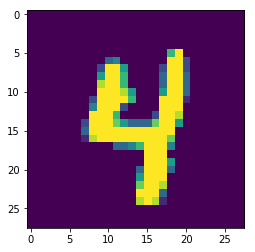

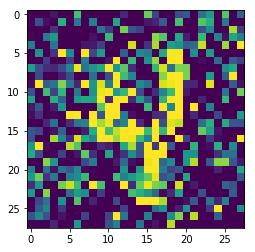

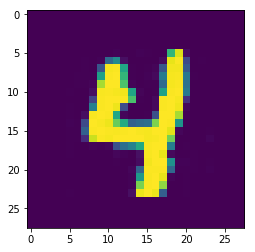

In [12]:
im = sess.run(model.im,feed_dict={model.im: input_x_train})
plt.imshow(im[0,:,:,0])
plt.show()

im_n = sess.run(model.im_n,feed_dict={model.im: input_x_train})
plt.imshow(im_n[0,:,:,0])
plt.show()

recon_im = sess.run(model.recon_im,feed_dict={model.im: input_x_train})
plt.imshow(recon_im[0,:,:,0])
plt.show()